In [2]:
%load_ext autoreload
%autoreload 2

# 绘制TDA和BOF对Acc的相关性

## 首先需要定义一些函数

### 计算相关性的函数

In [3]:
# 这里需要定义一个计算相关性的函数
# 计算的是*spearman correlation*

from scipy.stats import spearmanr

def calculate_spearman_correlation(vector1, vector2):
    """
    Calculate the Spearman correlation between two vectors.

    Parameters:
    - vector1 (array-like): The first vector.
    - vector2 (array-like): The second vector.

    Returns:
    - float: The Spearman correlation coefficient.
    - float: The two-tailed p-value for a hypothesis test whose null hypothesis is that the two samples are uncorrelated.
    """
    correlation_coefficient, p_value = spearmanr(vector1, vector2)
    return correlation_coefficient, p_value

# Example Usage:
vector1 = [1, 2, 3, 4, 5]
vector2 = [2, 3, 1, 4, 5]

correlation, p_value = calculate_spearman_correlation(vector1, vector2)

print(f"Spearman Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")


Spearman Correlation Coefficient: 0.7
P-value: 0.1881204043741873


### 计算数据中的相关性

In [4]:
import pandas as pd
def calculate_correlation_between_excel_sheets(file_path1, sheet_name1, column_name1, file_path2, sheet_name2, column_name2, x:int =100):
    """
    Calculate the Spearman correlation between the first x% of data in two columns in different Excel files.

    Parameters:
    - file_path1 (str): Path to the first Excel file.
    - sheet_name1 (str): Name of the sheet in the first Excel file.
    - column_name1 (str): Name of the column in the first sheet for which correlation is calculated.

    - file_path2 (str): Path to the second Excel file.
    - sheet_name2 (str): Name of the sheet in the second Excel file.
    - column_name2 (str): Name of the column in the second sheet for which correlation is calculated.

    - x (float): The percentage of data to consider for correlation calculation.

    Returns:
    - float: The Spearman correlation coefficient.
    - float: The two-tailed p-value for a hypothesis test whose null hypothesis is that the two samples are uncorrelated.
    """
    # Read data from Excel files
    df1 = pd.read_excel(file_path1, sheet_name=sheet_name1)
    df2 = pd.read_excel(file_path2, sheet_name=sheet_name2)
    # print(df1)
    # print(df2)

    # Calculate the number of rows to select
    num_rows = int(len(df1) * x / 100)

    # Select the first x% of data
    vector1 = df1[column_name1].head(num_rows)
    vector2 = df2[column_name2].head(num_rows)

    # Calculate Spearman correlation
    correlation_coefficient, p_value = calculate_spearman_correlation(vector1, vector2)

    return correlation_coefficient, p_value


# Example Usage:
file_path1 = './input_data/best_val_acc_kaiming.xlsx'
sheet_name1 = 'Angle'
column_name1 = 'ResNet152'

file_path2 = './input_data/TDA_data.xlsx'
sheet_name2 = sheet_name1
column_name2 = ['Data']

correlation, p_value = calculate_correlation_between_excel_sheets(file_path1, sheet_name1, column_name1, file_path2, sheet_name2, column_name2, x=100)

print(f"Spearman Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

Spearman Correlation Coefficient: 0.008535461097340626
P-value: 0.9094601540489842


In [5]:
import pandas as pd
import re

# 自定义排序函数
def sort_by_number(column_name):
    # 从列名中提取数字
    numbers = re.findall(r'\d+', column_name)
    if numbers:
        return int(numbers[0])
    else:
        return 0

# # 将列名按照数字大小排序
# df_pivot_sorted = df_pivot.sort_values(by=lambda x: sort_by_number(x), axis=1)

# # 保存到Excel
# df_pivot_sorted.to_excel(excel_path)


def calculate_correlations_for_all_columns(file_path1, file_path2, sheet_names, column_names1, column_names2, if_data=False, excel_path = 'output_file.xlsx', percentage:int =50):
    """
    Calculate Spearman correlations for all combinations of sheets and columns between two Excel files.

    Parameters:
    - file_path1 (str): Path to the first Excel file.
    - file_path2 (str): Path to the second Excel file.
    - sheet_names (list): List of sheet names present in both Excel files.
    - column_names (list): List of column names present in each sheet.

    Returns:
    - pd.DataFrame: DataFrame containing correlation coefficients for all combinations.
    """
    correlation_data = []

    for sheet_name in sheet_names:
        for column_name1, column_name2 in zip(column_names1, column_names2):
            
            correlation_coefficient, p_value = calculate_correlation_between_excel_sheets(
                    file_path1, sheet_name, column_name1,
                    file_path2, sheet_name, column_name2,
                    x = percentage
                )
            
            correlation_data.append({
                'Sheet': sheet_name,
                'Column': column_name1,
                'Correlation': correlation_coefficient,
                'P-value': p_value
            })

    correlation_df = pd.DataFrame(correlation_data)
    
    # Sample DataFrame
    data = correlation_df

    df = pd.DataFrame(data)

    # Drop the 'P-value' column
    df = df.drop('P-value', axis=1)

    # Pivot the DataFrame
    df_pivot = df.pivot(index='Sheet', columns='Column', values='Correlation')
    # Set 'Sheet' as the index
    # df_pivot.set_index('Column', inplace=True)

    # Save to Excel
    
    df_pivot.to_excel(excel_path)

    print(f'DataFrame saved to {excel_path}')
    return df_pivot



### 绘制柱形图

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.backends.backend_pdf as pdf_backend

def plot_grouped_bar_chart(file_path1, file_path2, row_index, aug_names = ['Angle', 'Scale'],columns_order=['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152'],label1='Data TDA v.s. Acc',label2='Model output v.s. Acc', title_key='TDA'):
    """
    Read specified rows from two Excel files and plot a grouped bar chart.

    Parameters:
    - file_path1 (str): Path to the first Excel file.
    - file_path2 (str): Path to the second Excel file.
    - row_index (int): Index of the row to plot.

    Returns:
    - None
    """
    
    # Read data from Excel files
    df1 = pd.read_excel(file_path1, index_col=0)
    df2 = pd.read_excel(file_path2, index_col=0)
    # 调整列的顺序
    df1 = df1[columns_order]
    df2 = df2[columns_order]

    # Select the specified row
    row_data1 = df1.iloc[row_index]
    row_data2 = df2.iloc[row_index]
    # print(row_data1, '\n', row_data2)

    # Organize data for plotting
    columns = df1.columns
    positions = np.arange(len(columns))
    bar_width = 0.1

    # Plotting
    fig, ax = plt.subplots()
    bars1 = ax.bar(positions - bar_width/2, row_data1, bar_width, label=label1)
    bars2 = ax.bar(positions + bar_width/2, row_data2, bar_width, label=label2)

    # Set labels and title
    ax.set_xlabel('Models')
    ax.set_ylabel('Spearman orrelation')
    ax.set_title(f'Spearman orrelation between Acc and {title_key} in {aug_names[row_index]}')
    ax.set_xticks(positions)
    ax.set_xticklabels(columns)
    ax.legend()

    # Save the plot as PDF
    pdf = pdf_backend.PdfPages(f"Spearman orrelation between Acc and {title_key} in {aug_names[row_index]}.pdf")
    pdf.savefig(fig)
    pdf.close()

    # Show the plot
    plt.show()


## 计算TDA v.s. Acc相关性和画图

In [7]:
# Example Usage:
file_path1 = './input_data/best_val_acc_kaiming.xlsx'
file_path2 = './input_data/TDA_out_2_all_bars_surviver_time.xlsx'
file_path_data = './input_data/TDA_data.xlsx'
sheet_names = ['Scale', 'Angle']
column_names = ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']
percenatge = 50
model_excel_path=f'./output_correlation/TDA_output_correlation_{percenatge}.xlsx'
data_excel_path=f'./output_correlation/TDA_data_correlation_{percenatge}.xlsx'
TDA_correlation_df = calculate_correlations_for_all_columns(file_path1, file_path2, sheet_names, column_names,column_names, excel_path=model_excel_path, percentage=percenatge)
TDA_correlation_df_data = calculate_correlations_for_all_columns(file_path1, file_path_data, sheet_names, column_names,['Data']*7, if_data=True, excel_path=data_excel_path, percentage=percenatge)
# Display the resulting DataFrame
print(TDA_correlation_df)
print(TDA_correlation_df_data)

DataFrame saved to ./output_correlation/TDA_output_correlation_50.xlsx
DataFrame saved to ./output_correlation/TDA_data_correlation_50.xlsx
Column     LeNet       MLP  ResNet101  ResNet152  ResNet18  ResNet34  ResNet50
Sheet                                                                         
Angle   0.333329  0.380527   0.110650  -0.132465  0.137789  0.080418  0.105935
Scale  -0.501236 -0.457129  -0.010872  -0.056832  0.189723 -0.053880 -0.200198
Column     LeNet       MLP  ResNet101  ResNet152  ResNet18  ResNet34  ResNet50
Sheet                                                                         
Angle   0.397718  0.468937   0.093023  -0.151779  0.189819  0.117161  0.134636
Scale   0.260999 -0.051396   0.358290   0.299975  0.402174 -0.183391  0.366782


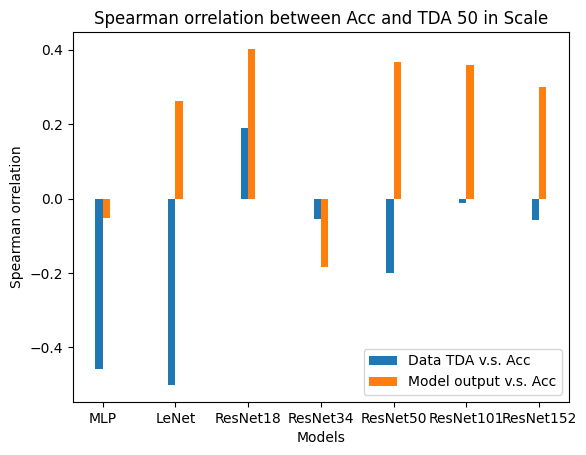

In [8]:
# Example Usage:
TDA_file_path1 = model_excel_path
TDA_file_path2 = data_excel_path
row_index = 1  # Choose the row index to plot

plot_grouped_bar_chart(TDA_file_path1, TDA_file_path2, row_index, title_key=f'TDA {percenatge}')


## 计算BOF v.s. Acc 的相关性和画图

In [9]:
# Example Usage:
BOF_file_path1 = './input_data/best_val_acc_kaiming.xlsx'
# file_path2 = './input_data/BOF_data.xlsx'
BOF_file_path_data = './input_data/BOF_data.xlsx'
sheet_names = ['Scale', 'Angle']
column_names = ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']
percenatge = 100
chose = 'rk_max'
excel_path=f'./output_correlation/{chose}_BOF_data_correlation_{percenatge}.xlsx'
# correlation_df = calculate_correlations_for_all_columns(file_path1, file_path2, sheet_names, column_names,column_names, excel_path='./output_correlation/TDA_output_correlation.xlsx')
correlation_df_data = calculate_correlations_for_all_columns(BOF_file_path1, BOF_file_path_data, sheet_names, column_names,[f'{chose}']*7, if_data=True, excel_path=excel_path, percentage=percenatge)
# Display the resulting DataFrame
# print(correlation_df)
print(correlation_df_data)

DataFrame saved to ./output_correlation/rk_max_BOF_data_correlation_100.xlsx
Column     LeNet       MLP  ResNet101  ResNet152  ResNet18  ResNet34  ResNet50
Sheet                                                                         
Angle  -0.408181 -0.425066  -0.242014  -0.059754 -0.314307 -0.299163 -0.247753
Scale  -0.868324 -0.928305  -0.863178  -0.886059 -0.821277 -0.941224 -0.831997


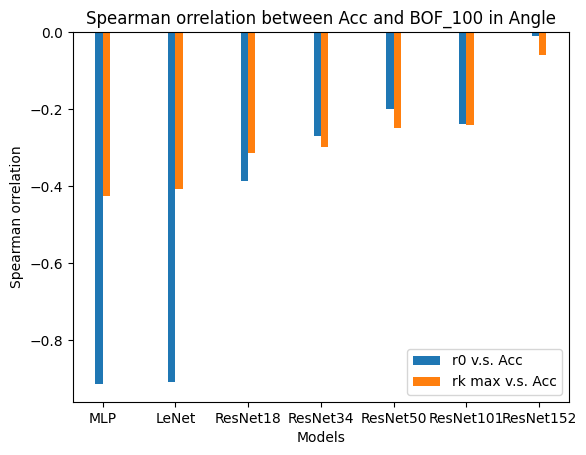

In [10]:
# Example Usage:
file_path1 = f'./output_correlation/r0_BOF_data_correlation_{percenatge}.xlsx'
file_path2 = f'./output_correlation/rk_max_BOF_data_correlation_{percenatge}.xlsx'
row_index = 0  # Choose the row index to plot

plot_grouped_bar_chart(file_path1, file_path2, row_index, label1='r0 v.s. Acc', label2='rk max v.s. Acc', title_key=f'BOF_{percenatge}')


# 绘制输入中的数据

我发现计算得到的相关度和预计的有一些差距，为了研究这个问题，我决定探究一下输入数据的情况。

## 首先定义一些函数用来画图

### 一个读取excle的函数

In [2]:
import pandas as pd

def read_excel(file_path):
    # 读取Excel文件
    xls = pd.ExcelFile(file_path)

    # 获取所有Sheet的名称
    sheet_names = xls.sheet_names

    # 用于存储每个Sheet的DataFrame
    dataframes = []

    # 遍历每个Sheet，读取数据并转换为DataFrame
    for sheet_name in sheet_names:
        df = xls.parse(sheet_name)
        dataframes.append(df)

    return dataframes

file_path = "./input_data/best_val_acc_kaiming.xlsx"
dfs = read_excel(file_path)

# 打印每个DataFrame
for i, df in enumerate(dfs):
    print(f"Sheet {i+1}:\n{df}\n")

Sheet 1:
     LeNet     MLP  ResNet18  ResNet34  ResNet50  ResNet101  ResNet152
0   0.6616  0.5705    0.8641    0.8760    0.8720     0.8750     0.8673
1   0.7033  0.5788    0.8805    0.8866    0.8818     0.8760     0.8818
2   0.7073  0.5856    0.8853    0.8904    0.8942     0.8899     0.8978
3   0.7082  0.5960    0.8933    0.8973    0.9030     0.8941     0.8758
4   0.7120  0.6061    0.9017    0.9067    0.9039     0.9018     0.9072
5   0.7190  0.6005    0.9095    0.9142    0.9068     0.9080     0.9006
6   0.7298  0.6080    0.9098    0.9199    0.9096     0.9153     0.9095
7   0.7377  0.6119    0.9159    0.9231    0.9197     0.9118     0.9065
8   0.7339  0.6150    0.9166    0.9264    0.9213     0.9208     0.9066
9   0.7408  0.6115    0.9204    0.9239    0.9247     0.9127     0.9118
10  0.7390  0.6123    0.9226    0.9245    0.9236     0.9180     0.9184
11  0.7382  0.6138    0.9240    0.9248    0.9224     0.9211     0.9201
12  0.7374  0.6097    0.9248    0.9277    0.9226     0.9159     0.91

### 绘制函数图像

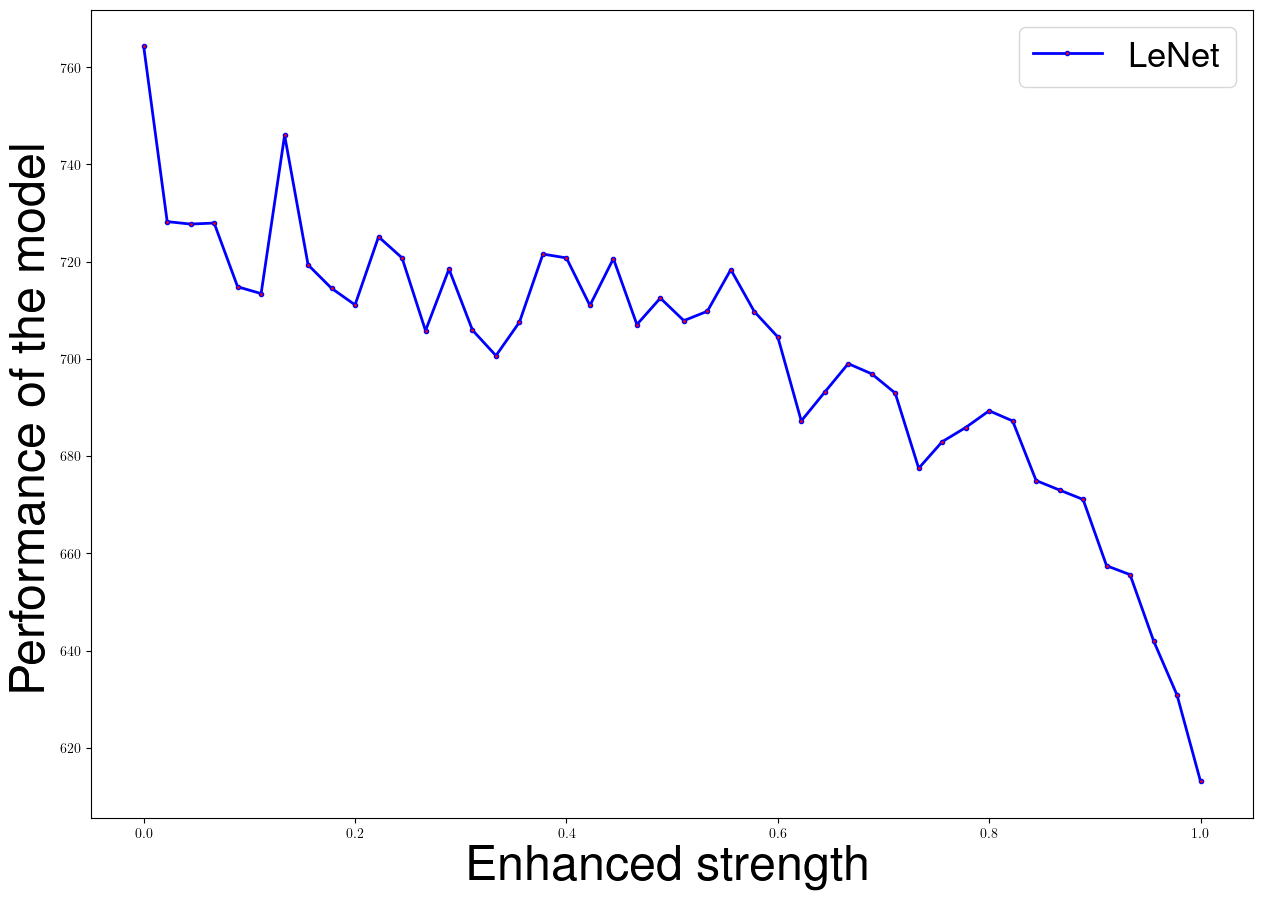

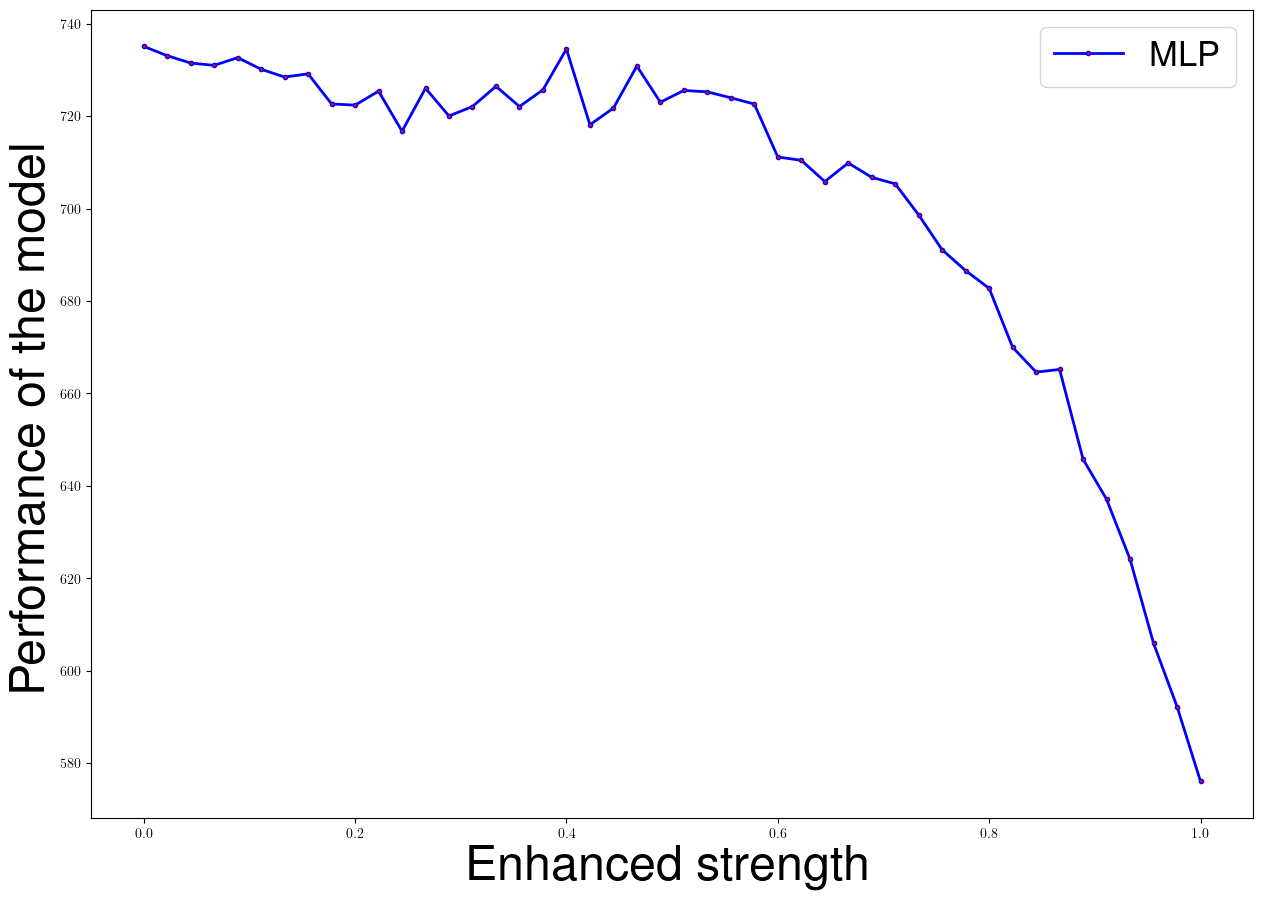

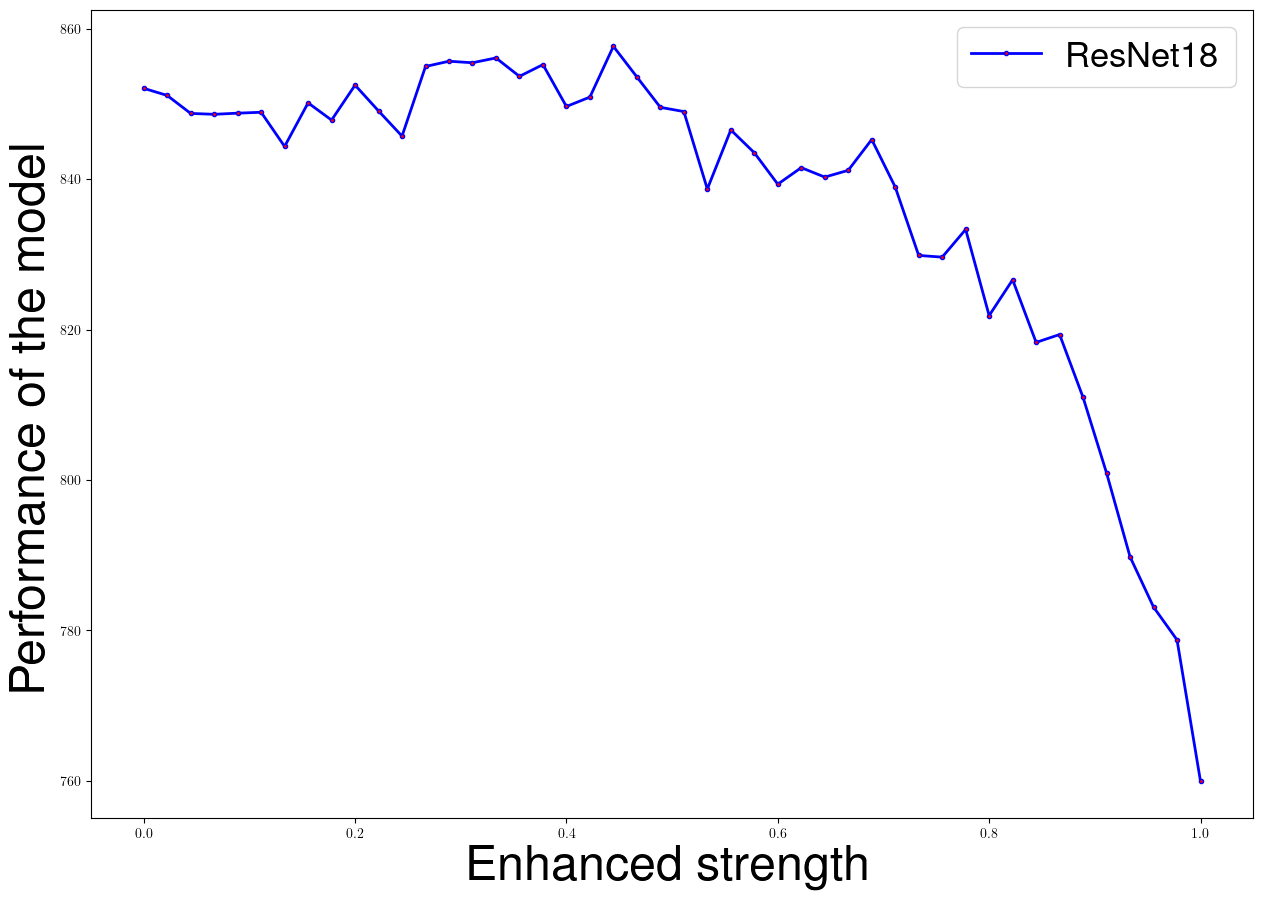

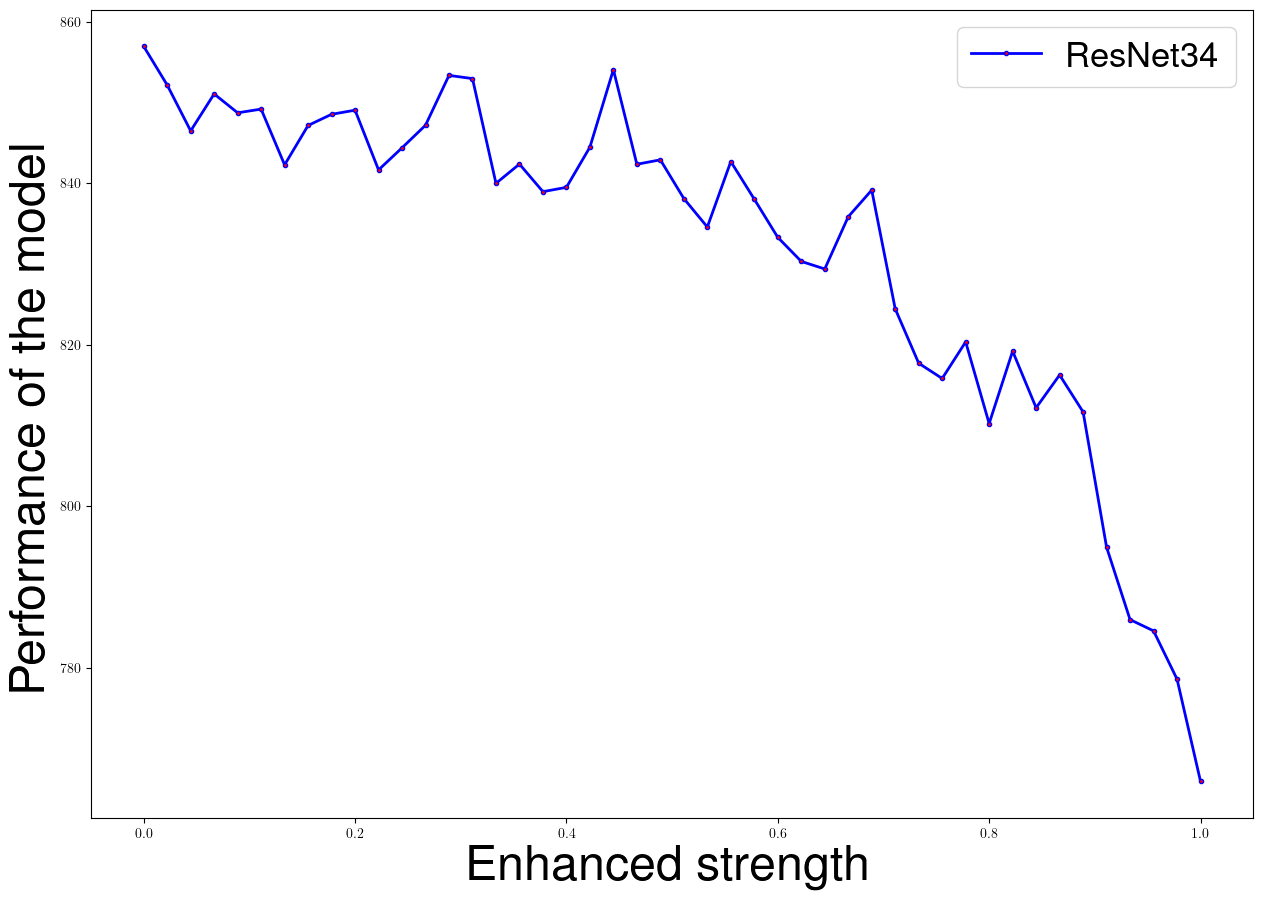

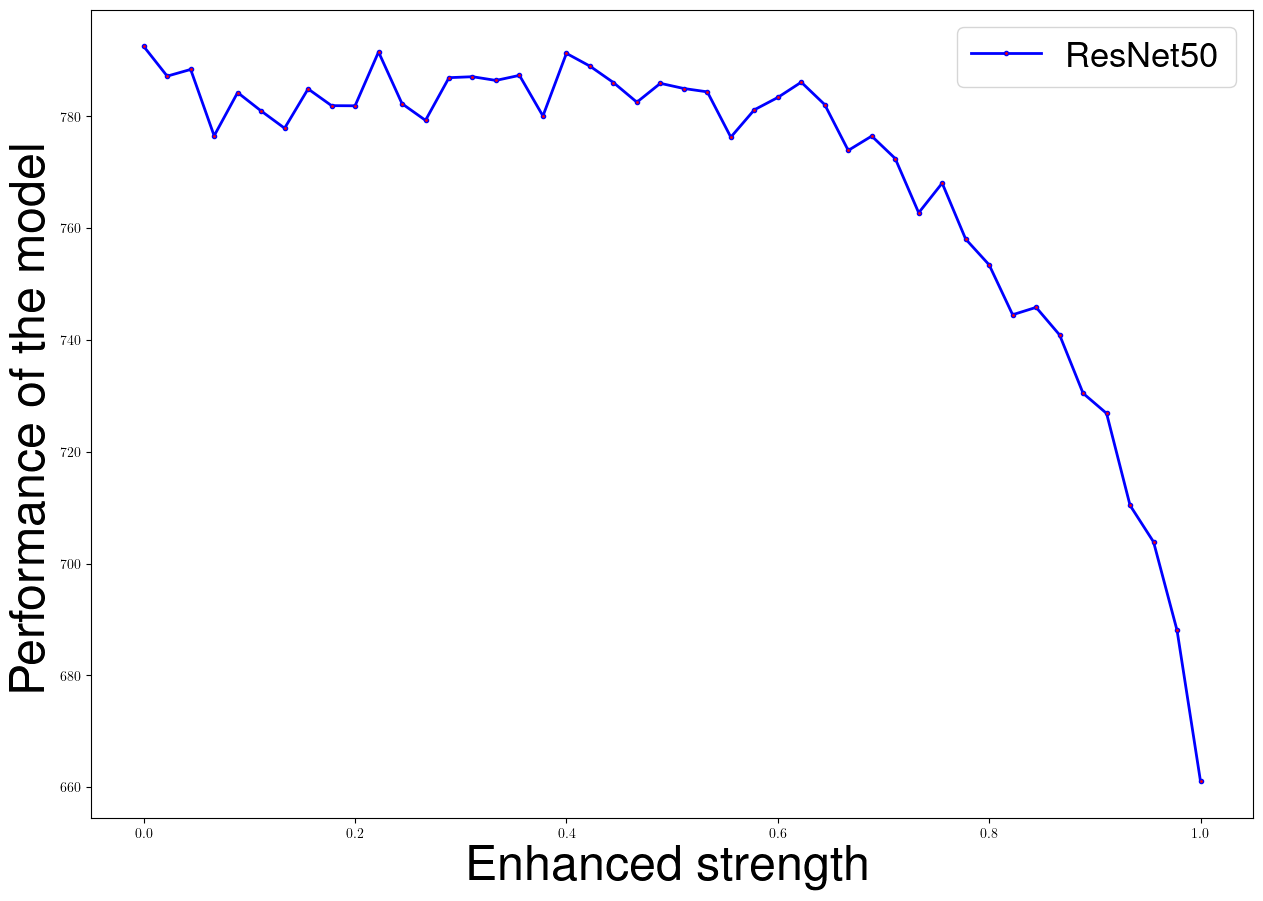

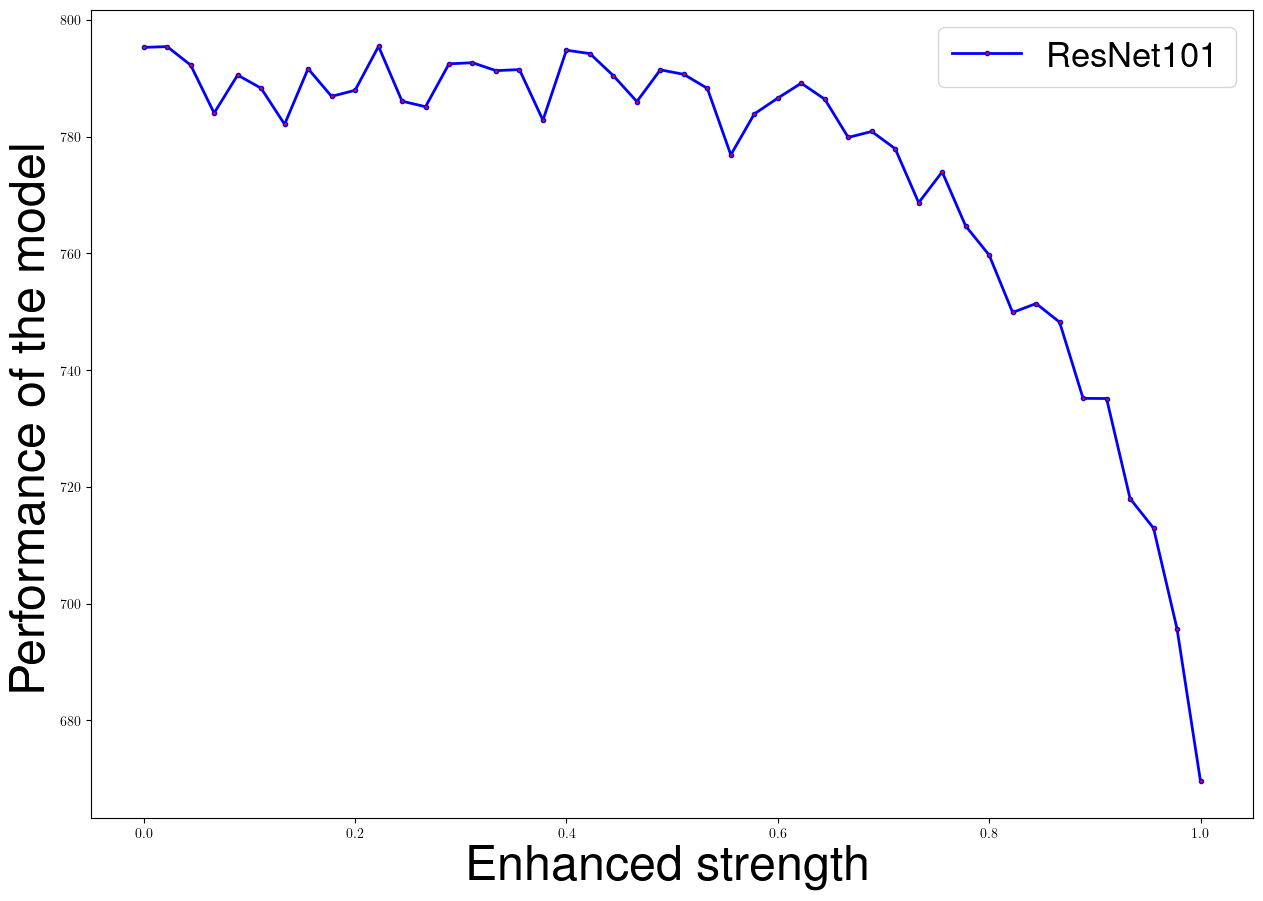

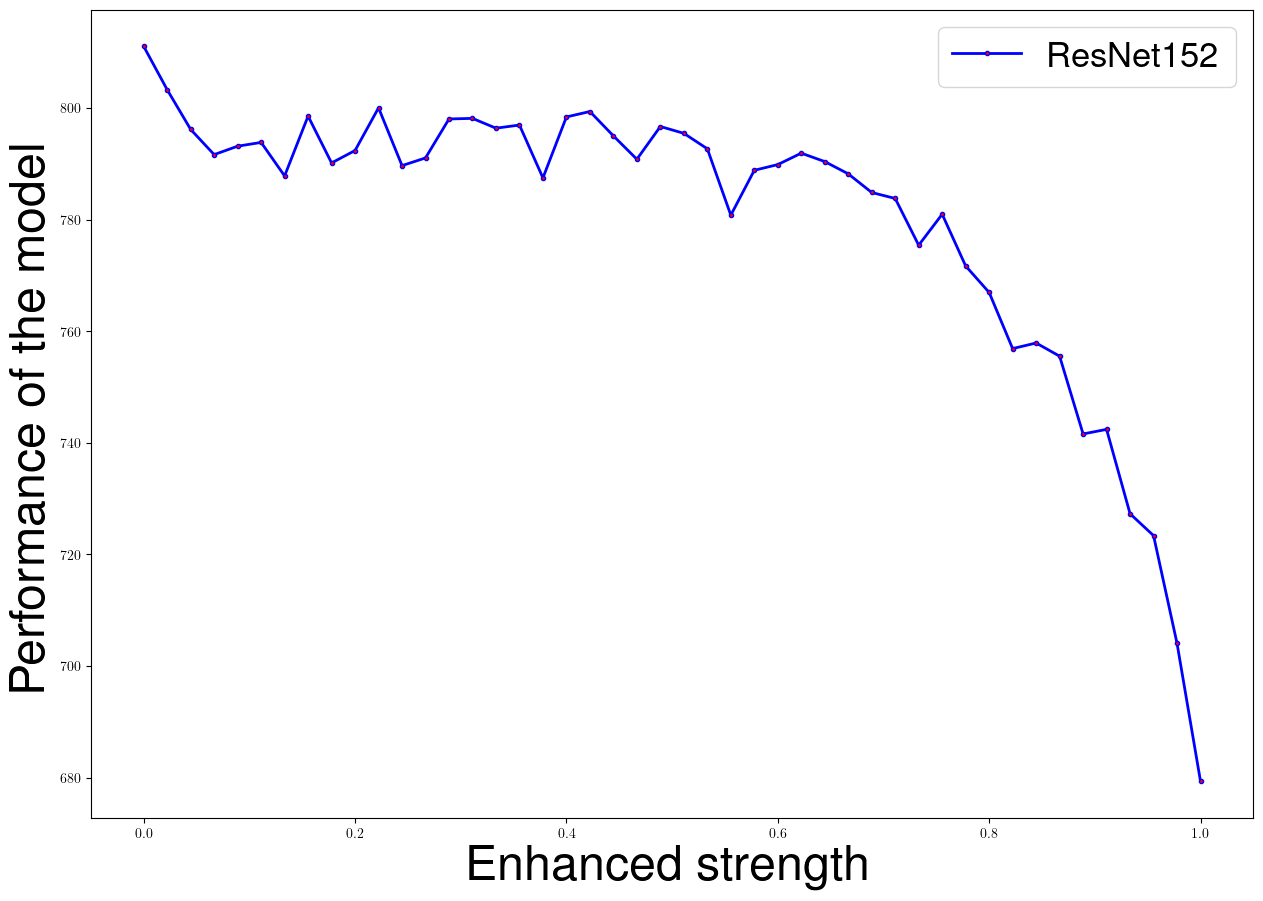

In [81]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_line_graphs(df, output_folder, xlabel: str= 'Enhanced strength', ylabel:str = 'Performance of the model', fig_title:str = 'Optimal performance of the model under', save_name:str = 'Scale'):
    # 创建输出文件夹（如果不存在）
    os.makedirs(output_folder, exist_ok=True)

    # 获取DataFrame的列名
    columns = df.columns
    model_names = ['LeNet', 'MLP', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']
    # 遍历每一列，绘制折线图并保存为PDF
    for column, model_name in zip(columns, model_names):
        # 创建一个新的图形
        plt.figure(figsize=(15, 7 * 1.5))

        # 归一化横坐标
        x = range(len(df))
        x_normalized = [(val - min(x)) / (max(x) - min(x)) for val in x]

        # 设置线和标记的样式
        plt.plot(x_normalized, df[column], linewidth=2, color='blue', marker='o', markersize=3, markerfacecolor='red')


        # 添加标题和轴标签
        # plt.title(fig_title +" " + save_name, fontsize=40)
        plt.xlabel(xlabel=xlabel, fontsize=35)
        plt.ylabel(ylabel=ylabel, fontsize=35)
        plt.legend([column], fontsize=25)
        # 保存为PDF文件
        output_path = os.path.join(output_folder, column + save_name + '.pdf')
        plt.savefig(output_path)
        plt.show()
    
        # 关闭图形
        plt.close()

import pandas as pd

# 创建一个示例DataFrame
data = dfs[0]
df = pd.DataFrame(data)

# 调用函数绘制折线图并保存为PDF
output_folder = "./draw_input/Acc/"
plot_line_graphs(df, output_folder)

## 绘制图像

### 绘制Acc

#### 独立绘制

Sheet 1:
     LeNet     MLP  ResNet18  ResNet34  ResNet50  ResNet101  ResNet152
0   0.6616  0.5705    0.8641    0.8760    0.8720     0.8750     0.8673
1   0.7033  0.5788    0.8805    0.8866    0.8818     0.8760     0.8818
2   0.7073  0.5856    0.8853    0.8904    0.8942     0.8899     0.8978
3   0.7082  0.5960    0.8933    0.8973    0.9030     0.8941     0.8758
4   0.7120  0.6061    0.9017    0.9067    0.9039     0.9018     0.9072
5   0.7190  0.6005    0.9095    0.9142    0.9068     0.9080     0.9006
6   0.7298  0.6080    0.9098    0.9199    0.9096     0.9153     0.9095
7   0.7377  0.6119    0.9159    0.9231    0.9197     0.9118     0.9065
8   0.7339  0.6150    0.9166    0.9264    0.9213     0.9208     0.9066
9   0.7408  0.6115    0.9204    0.9239    0.9247     0.9127     0.9118
10  0.7390  0.6123    0.9226    0.9245    0.9236     0.9180     0.9184
11  0.7382  0.6138    0.9240    0.9248    0.9224     0.9211     0.9201
12  0.7374  0.6097    0.9248    0.9277    0.9226     0.9159     0.91

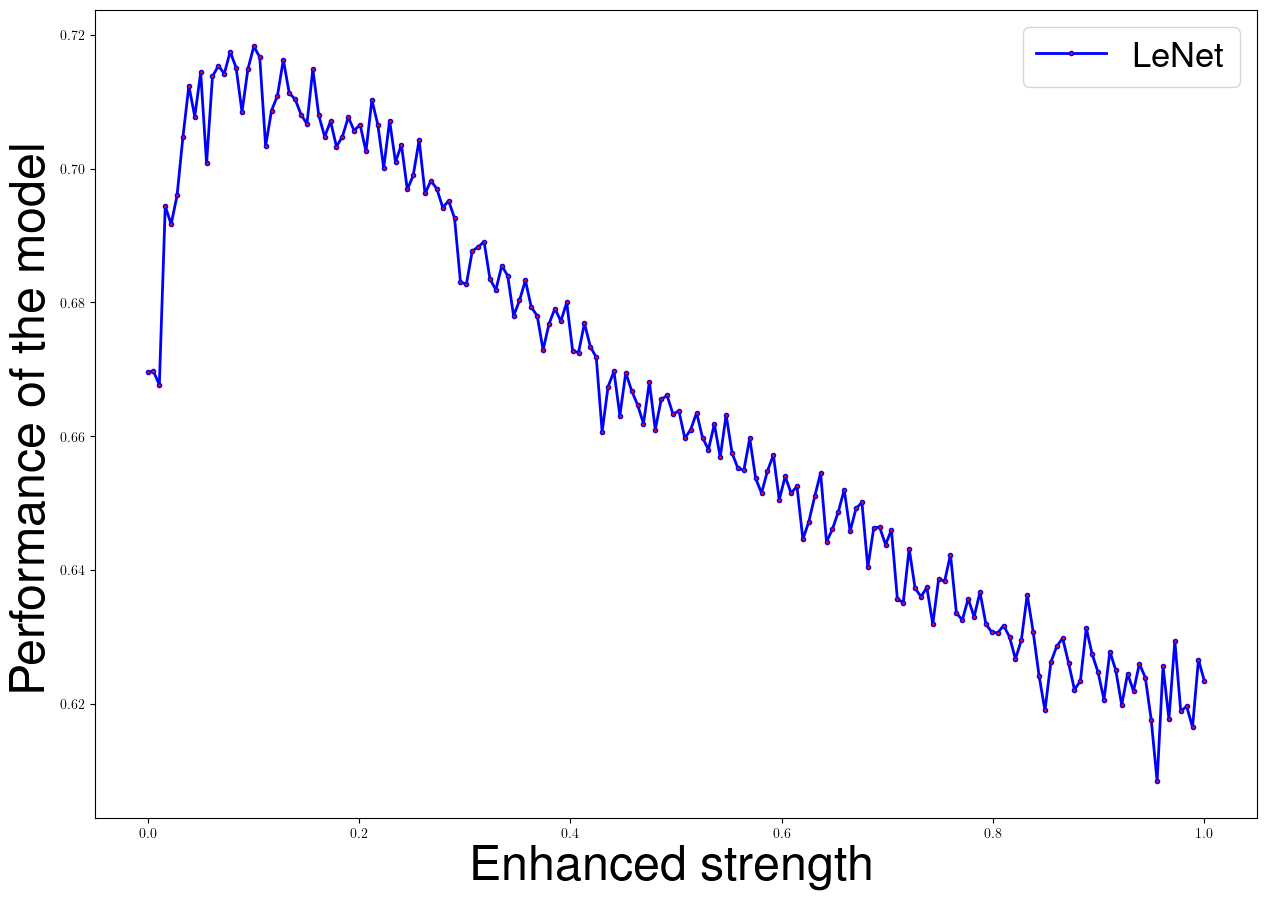

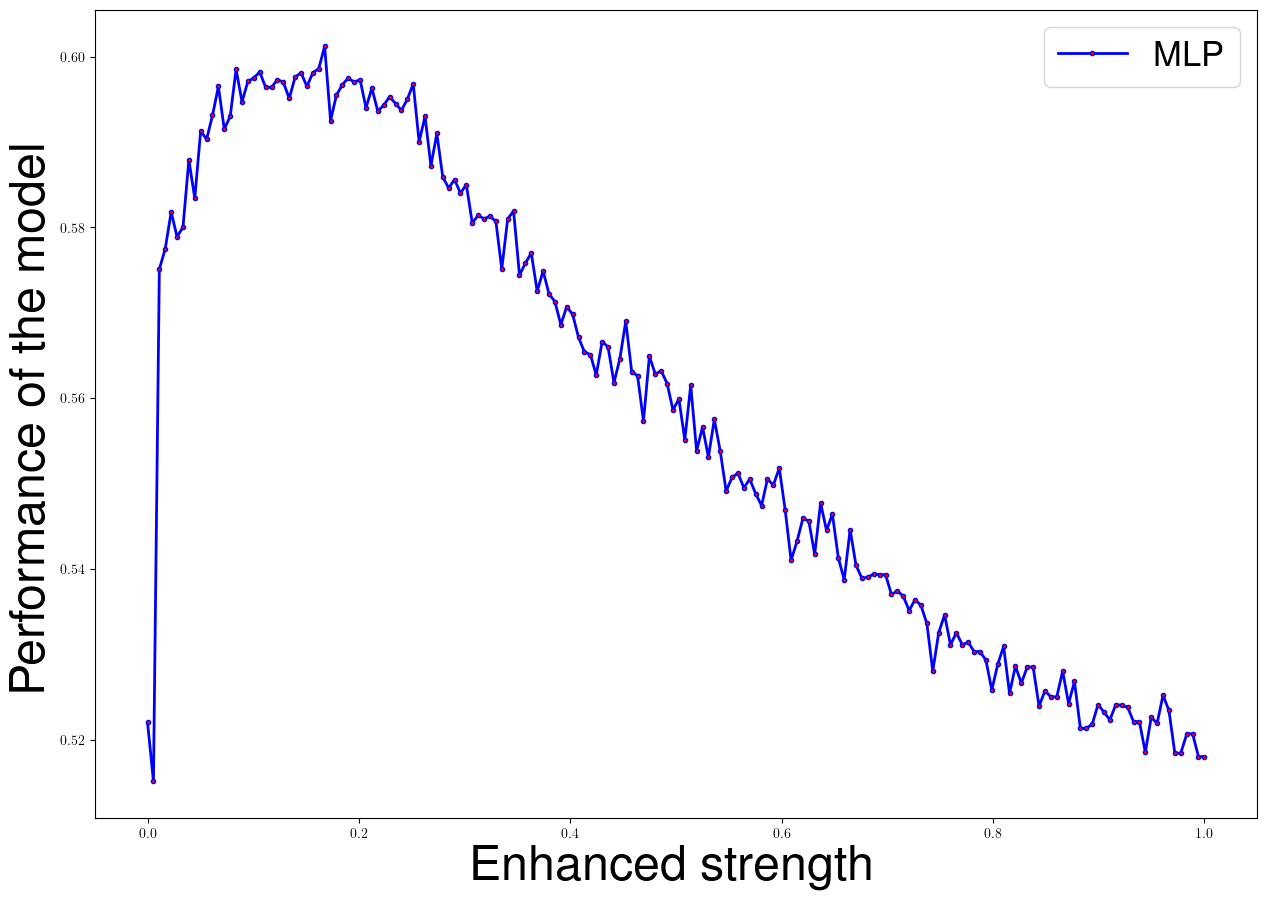

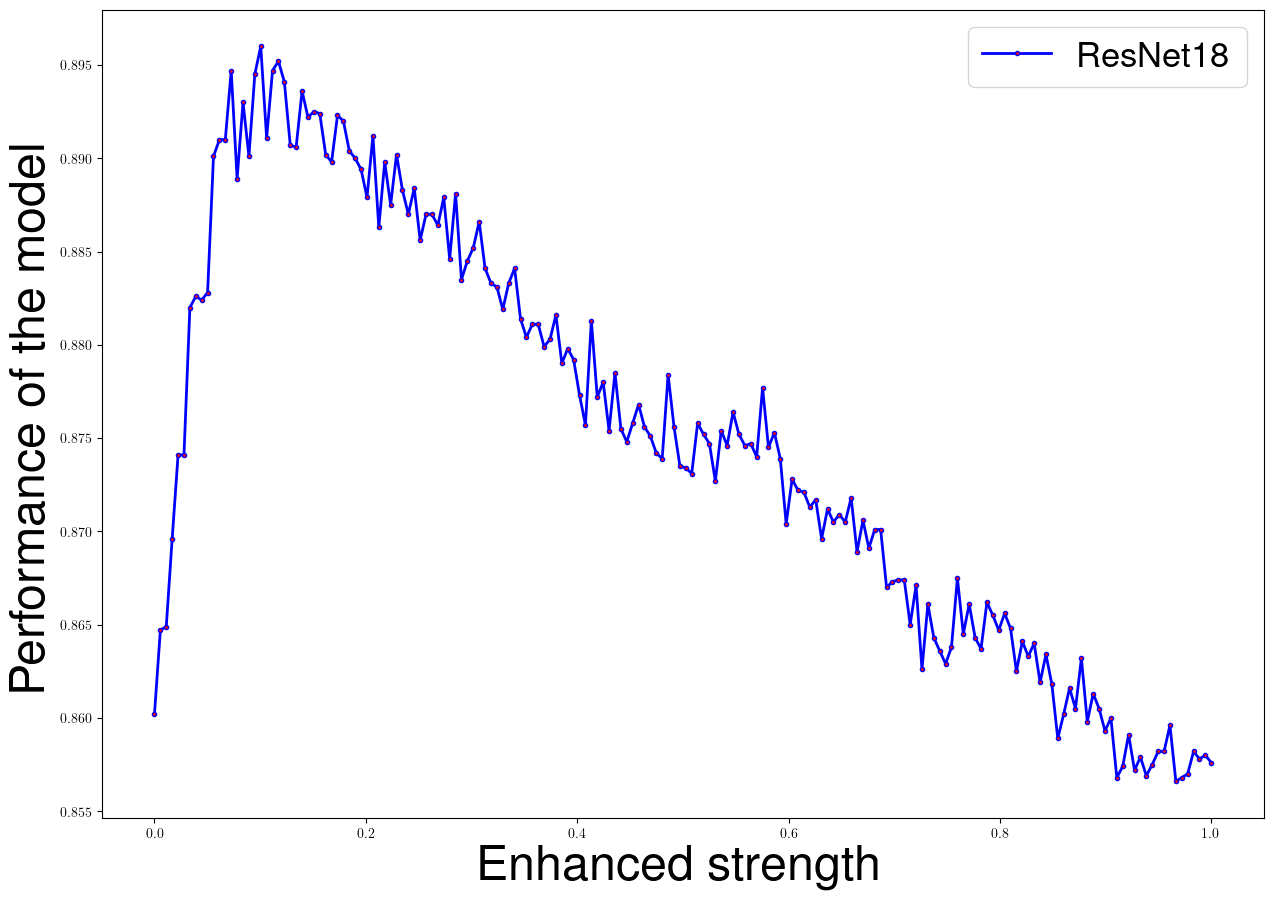

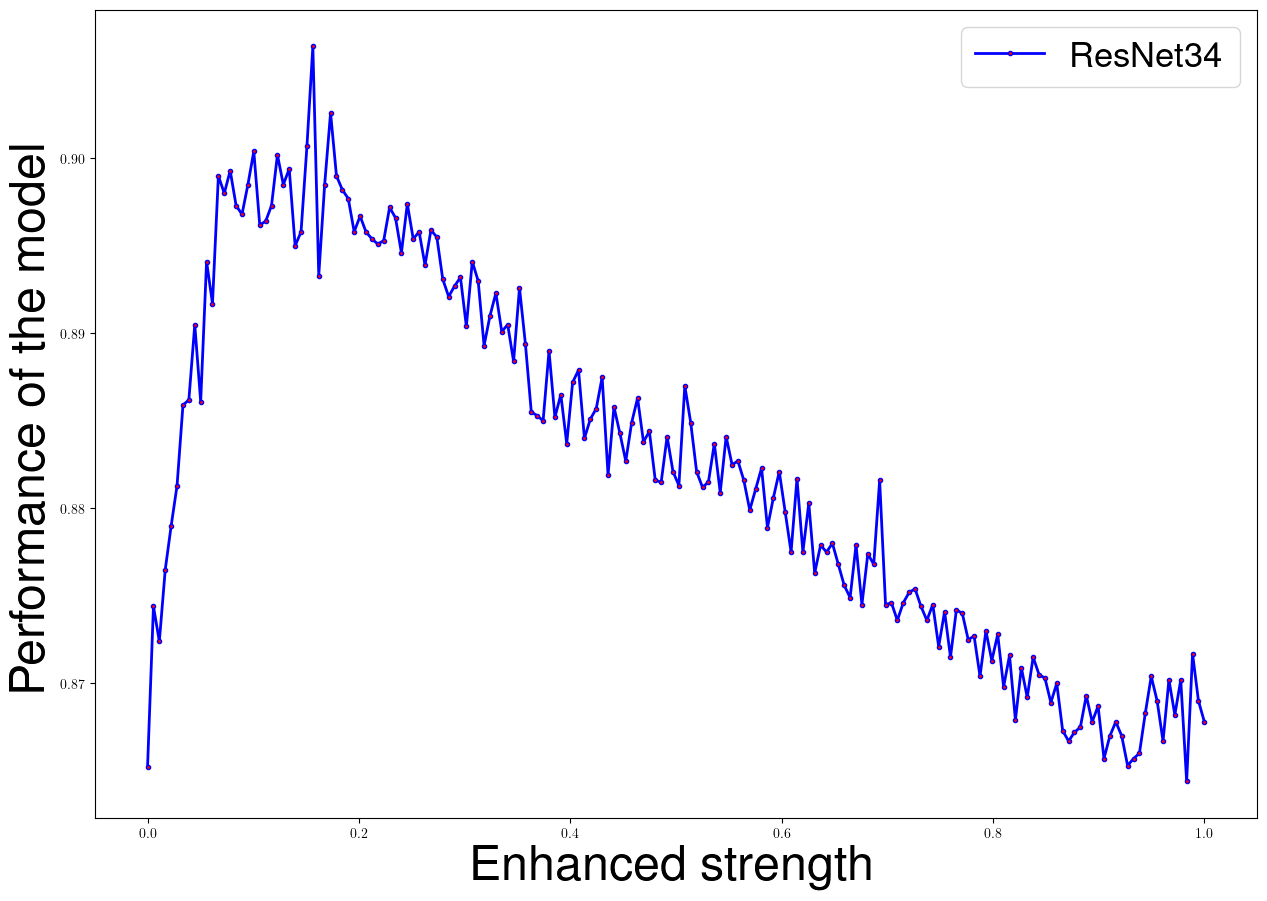

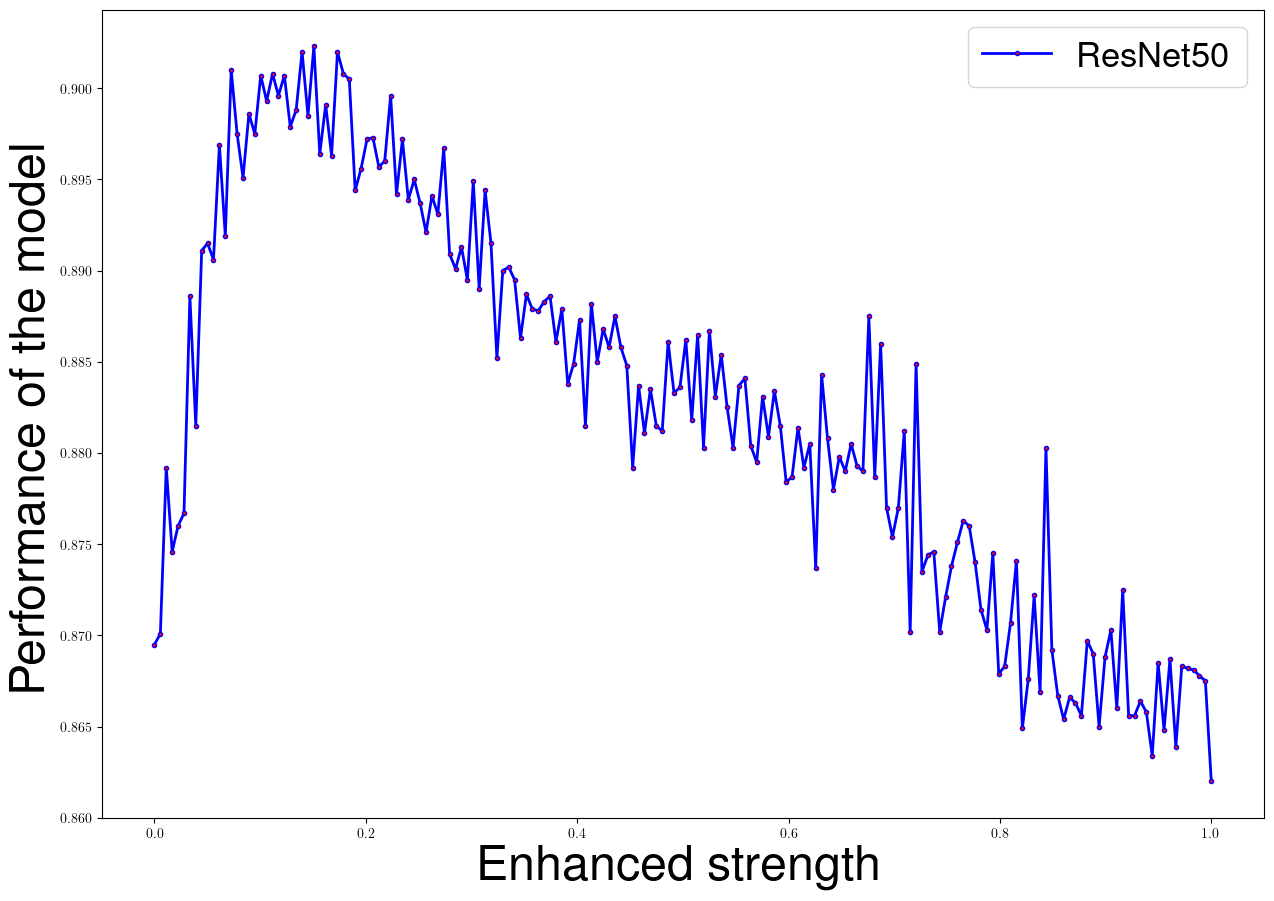

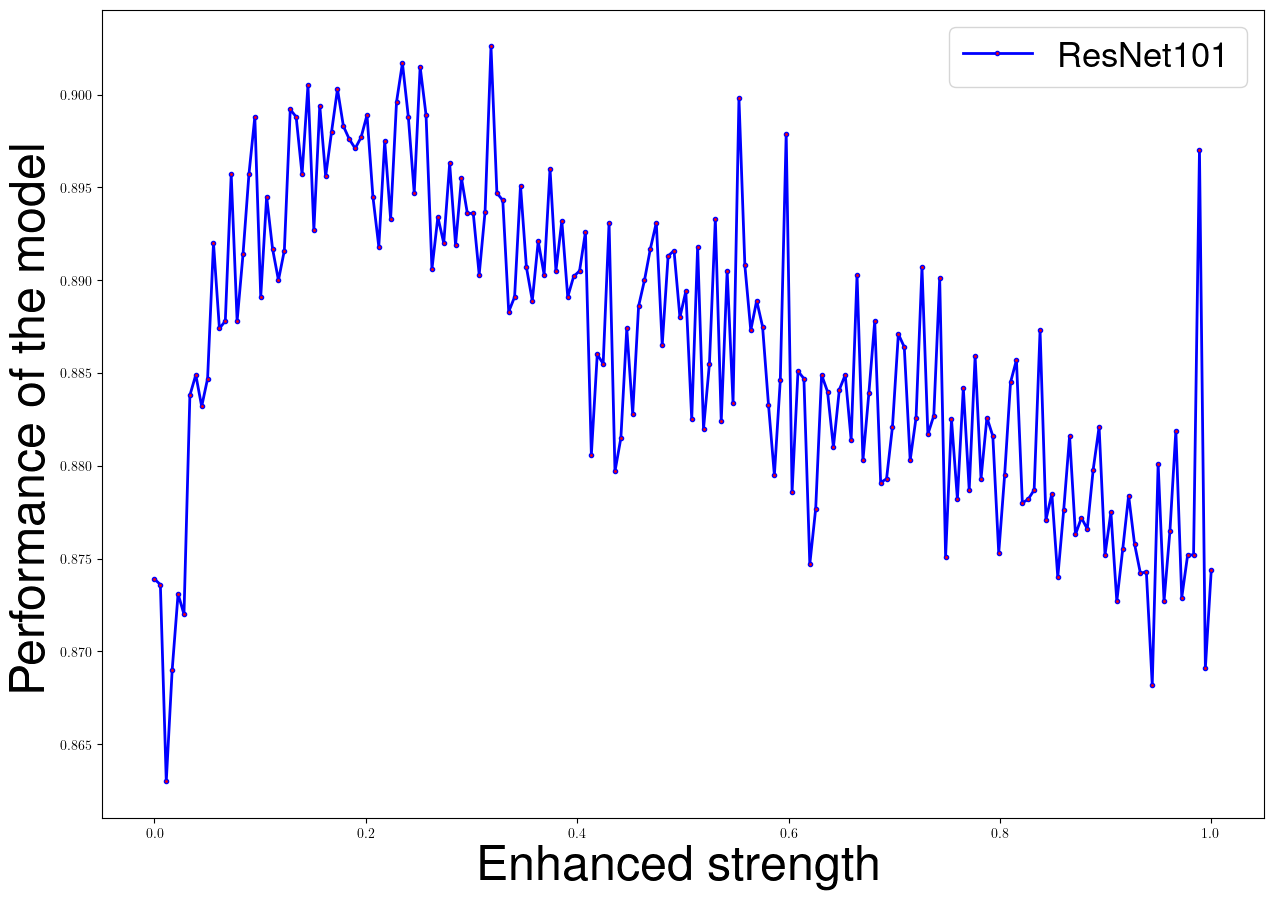

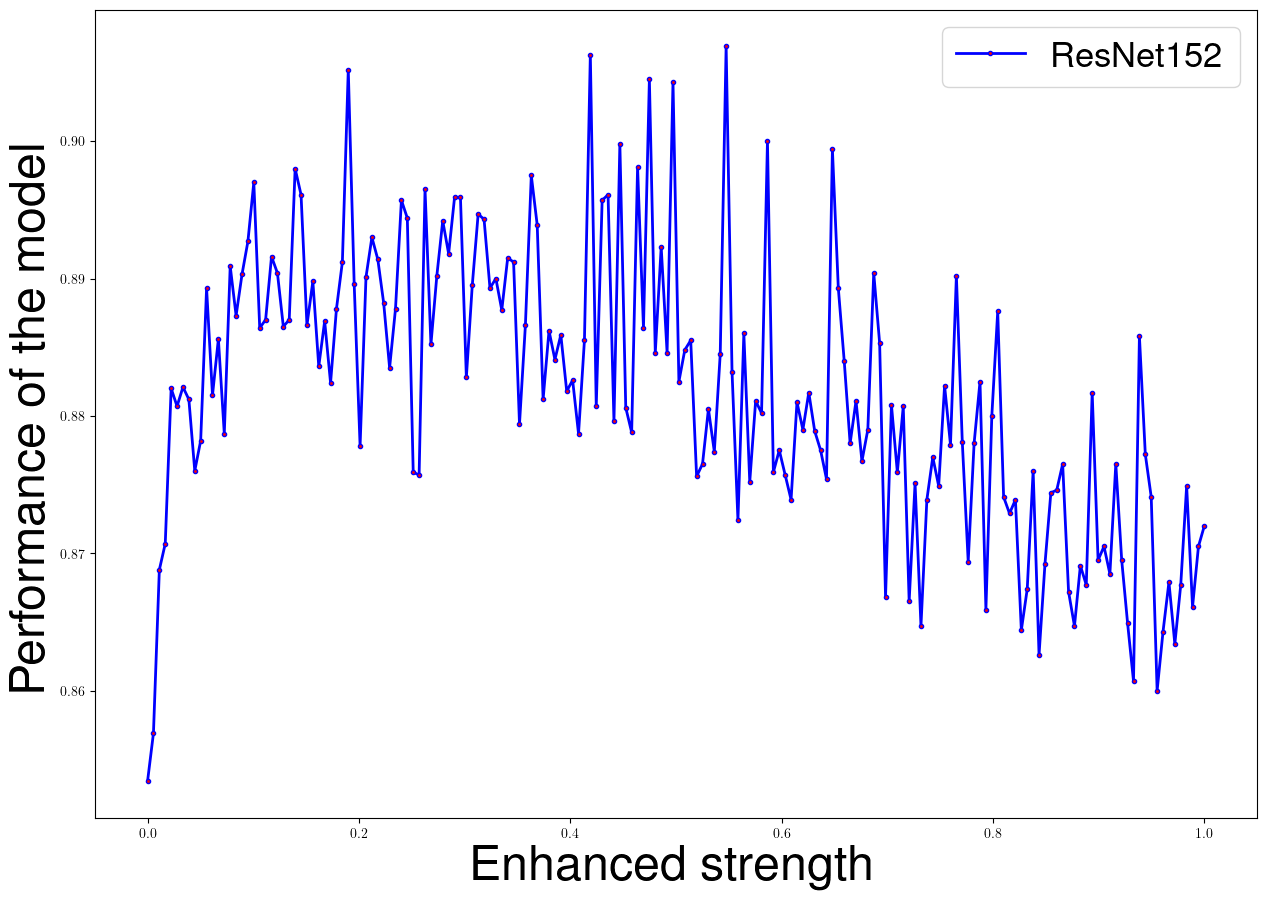

In [66]:
# 加载数据到df
file_path = "./input_data/best_val_acc_kaiming.xlsx"
dfs = read_excel(file_path)

# 打印每个DataFrame
for i, df in enumerate(dfs):
    print(f"Sheet {i+1}:\n{df}\n")

# 绘制图像为pdf
data = dfs[1]
df = pd.DataFrame(data)

# 调用函数绘制折线图并保存为PDF
output_folder = "./draw_input/Acc_all"
plot_line_graphs(df, output_folder, save_name='Angle')

#### 一起绘制

In [63]:
import numpy as np

MLP
LeNet
ResNet18


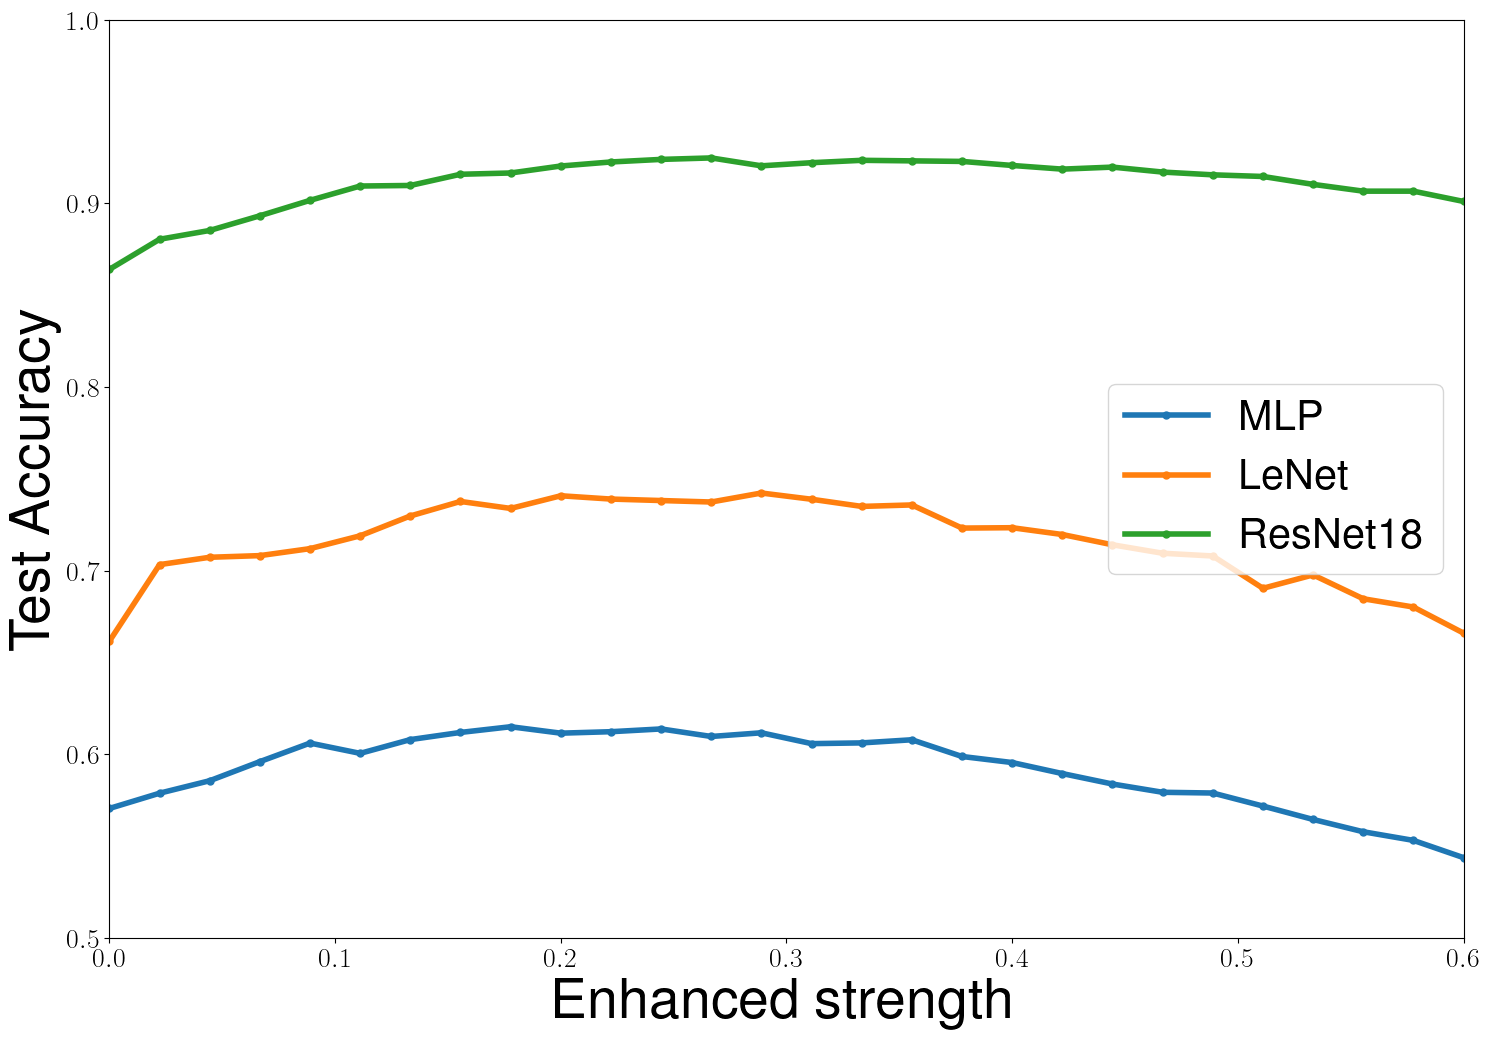

In [64]:
def plot_line_graphs_all_in_one(df, output_folder='./draw_input/acc_all_in_one', xlabel='Enhanced strength', ylabel='Performance of the model', fig_title='Optimal performance of the model under', save_name='Scale', care_columns=['MLP', 'LeNet', 'ResNet18']):
    # 创建输出文件夹（如果不存在）
    os.makedirs(output_folder, exist_ok=True)
    
    # 创建一个新的图形
    plt.figure(figsize=(15, len(df.columns) * 1.5))

    # 获取DataFrame的列名
    if not care_columns:
        columns = df.columns
    else:
        columns = care_columns

    # 归一化横坐标
    if save_name == 'Scale':
        x = range(len(df))
        x_normalized = [(val - min(x)) / (max(x) - min(x)) for val in x]
        plt.xlim([0, 0.6])
        plt.ylim([0.5, 1.0])
        # my_x_ticks = np.arange(0, 0.5, 10)
        # plt.xticks(my_x_ticks)
    elif save_name == 'Angle':
        x_normalized = range(len(df))
        plt.ylim([0.5, 1.0])
        plt.xlim([0, 180])
        my_x_ticks = np.arange(0, 180, 10)
        plt.xticks(my_x_ticks)

    # 遍历每一列，绘制折线图
    for column in columns:
        print(column)
        if column != 'Index':
            # 设置线和标记的样式，每条曲线使用不同的颜色
            plt.plot(x_normalized, df[column], label=column, linewidth=4, marker='o', markersize=5)

    # 添加标题和轴标签
    my_font_size = 40
    # plt.title(fig_title + " " + save_name, fontsize=my_font_size)
    plt.xlabel(xlabel=xlabel,fontsize=my_font_size)
    plt.ylabel(ylabel=ylabel, fontsize=my_font_size)

    plt.xticks(fontproperties = 'Times New Roman', size = 20)
    plt.yticks(fontproperties = 'Times New Roman', size = 20)
    #刻度线的大小长短粗细
    # plt.tick_params(axis="both", which="major", direction="in", width=1, length=5, pad=10)

    # 添加图例，将图例放在图形的右上角
    plt.legend(fontsize=30)
    # plt.rcParams.update({'font.size': 75})     #设置图例字体大小        #定义图标所处位置，这里表示右上
    # 设置横坐标的范围为[0, 0.5]
    
    
    # 自动调整布局
    plt.tight_layout()
    # plt.show()
    # 保存为PDF文件
    output_path = os.path.join(output_folder, f'combined_plot_{save_name}.pdf')
    plt.savefig(output_path)
    plt.show()
    # 关闭图形
    plt.close()




# 加载数据到df
file_path = "./input_data/best_val_acc_kaiming.xlsx"
dfs = read_excel(file_path)


# 绘制图像为pdf
data = dfs[0]
df = pd.DataFrame(data)
# 调用函数绘制折线图并保存为PDF
my_y_label = 'Test Accuracy'
my_title = '-'
plot_line_graphs_all_in_one(df, save_name='Scale', fig_title=my_title, ylabel=my_y_label)



### 绘制BOF

In [73]:
import os
import matplotlib.pyplot as plt

def plot_line_graphs_BOF(df, output_folder, xlabel: str='Enhanced strength', ylabel: str='Performance of the model', fig_title: str='Optimal performance of the model under', save_name: str='Scale'):
    # 创建输出文件夹（如果不存在）
    os.makedirs(output_folder, exist_ok=True)

    # 获取DataFrame的列名
    columns = df.columns
    
    i = 0
    # 遍历每一列，绘制折线图并保存为PDF
    for column in columns:
        i += 1
        # 创建一个新的图形
        plt.figure(figsize=(12, 9))

        # 归一化横坐标
        if save_name == 'Scale':
            x = range(len(df))
            x_normalized = [(val - min(x)) / (max(x) - min(x)) for val in x]
            plt.xlim([0, 0.6])
            # plt.ylim([0.5, 1.0])
            my_x_ticks = np.arange(0, 0.6, 0.1)
            plt.xlabel(xlabel='Crop Ratio',fontsize=30)
            plt.xticks(my_x_ticks,fontsize=20)
        elif save_name == 'Angle':
            x_normalized = range(len(df))
            # plt.ylim([0.5, 1.0])
            plt.xlim([0, 180])
            my_x_ticks = np.arange(0, 180, 20)
            plt.xticks(my_x_ticks,fontsize=20)
            plt.xlabel(xlabel='Rotation Angle',fontsize=30)

        # 设置线和标记的样式
        plt.plot(x_normalized, df[column], linewidth=2, color='blue', marker='o', markersize=3, markerfacecolor='red')

        # 添加标题和轴标签
        # plt.title(f'{fig_title} {save_name}' , fontsize = 25)
        # 添加标题和轴标签
        my_font_size = 20
        # plt.title(fig_title + " " + save_name, fontsize=my_font_size)
        if not ylabel:
            plt.ylabel(ylabel=column,fontsize=40)
        else:
            plt.ylabel(ylabel=ylabel, fontsize=40)

        plt.xticks(fontproperties = 'Times New Roman', size = 20)
        plt.yticks(fontproperties = 'Times New Roman', size = 20)
        #刻度线的大小长短粗细
        # plt.tick_params(axis="both", which="major", direction="in", width=1, length=5, pad=10)

        # 添加图例，将图例放在图形的右上角
        # plt.legend(fontsize=15)

        # 保存为PDF文件
        output_path = os.path.join(output_folder, f'{i}_{column}_{save_name}.pdf')
        plt.savefig(output_path)
        plt.show()

        # 关闭图形
        plt.close()

# 调用函数并传入你的DataFrame
# plot_line_graphs(your_dataframe, your_output_folder)


Sheet 1:
          r0        R0  rk_max_index      rk_max       Rk_max
0   3.436844  9.225692    933.000000  341.117767   672.763733
1   3.413863  9.056010    934.599976  334.460754   661.249878
2   3.412494  9.002722    999.799988  327.374146   647.545837
3   3.426091  9.025197    980.700012  322.459290   638.184448
4   3.449736  9.092059   1339.900024  319.594452   628.856140
5   3.471112  9.155492   1747.599976  319.005188   621.564087
6   3.496571  9.233131   1783.900024  319.837219   621.670898
7   3.521122  9.310081   1786.500000  322.247742   624.957520
8   3.543707  9.378830   1804.099976  322.909851   626.623657
9   3.566939  9.448359   1788.500000  325.439392   631.996704
10  3.591511  9.523071   1816.599976  327.901184   632.762146
11  3.610572  9.579646   1834.500000  330.086853   635.375305
12  3.628019  9.616961   1879.099976  333.850006   636.865967
13  3.645803  9.645788   1943.900024  339.183289   638.848206
14  3.660711  9.674059   1937.400024  344.631409   651.442383

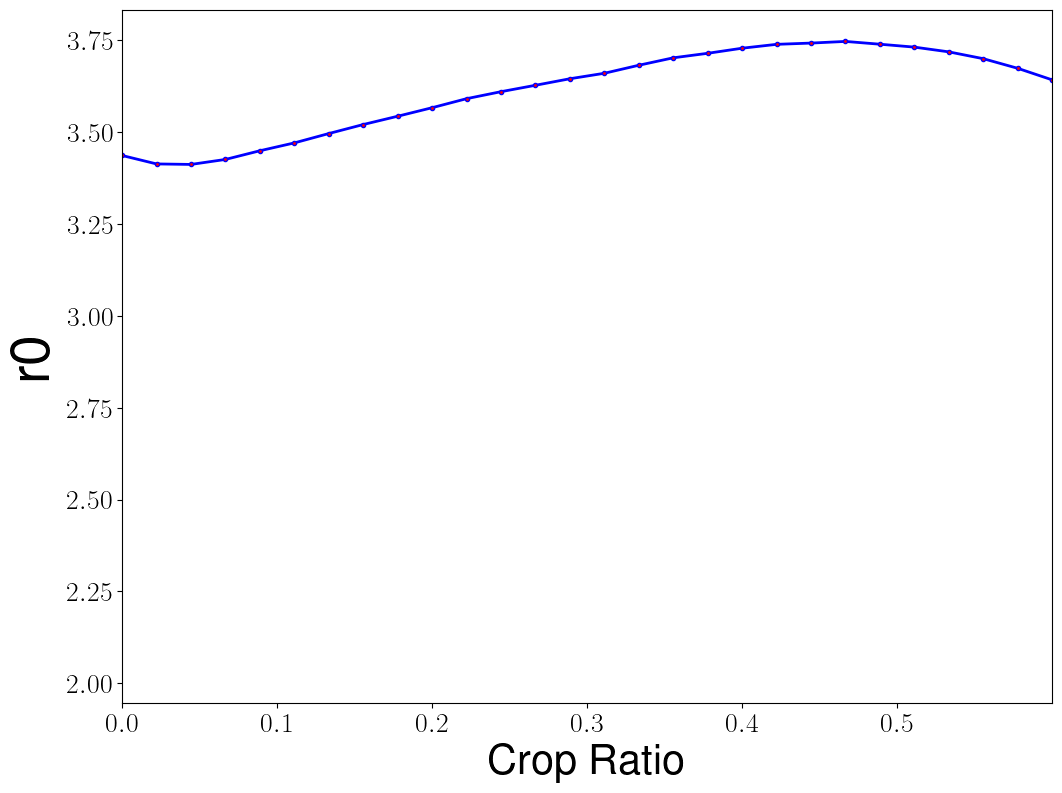

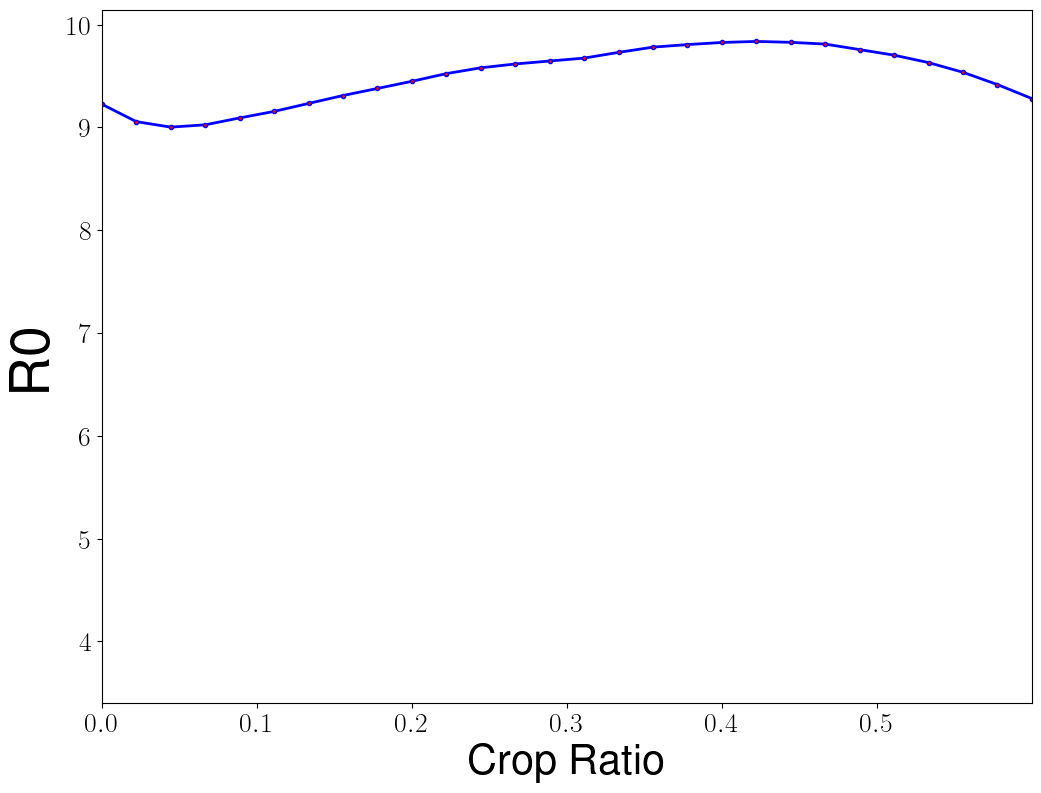

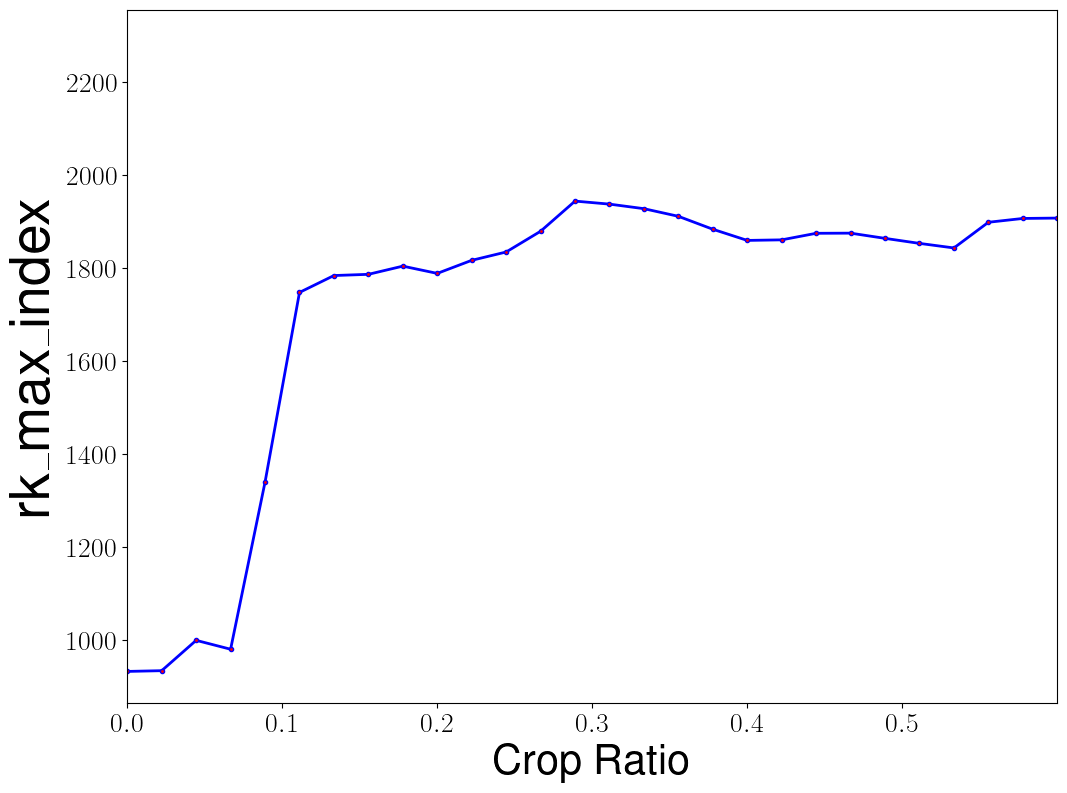

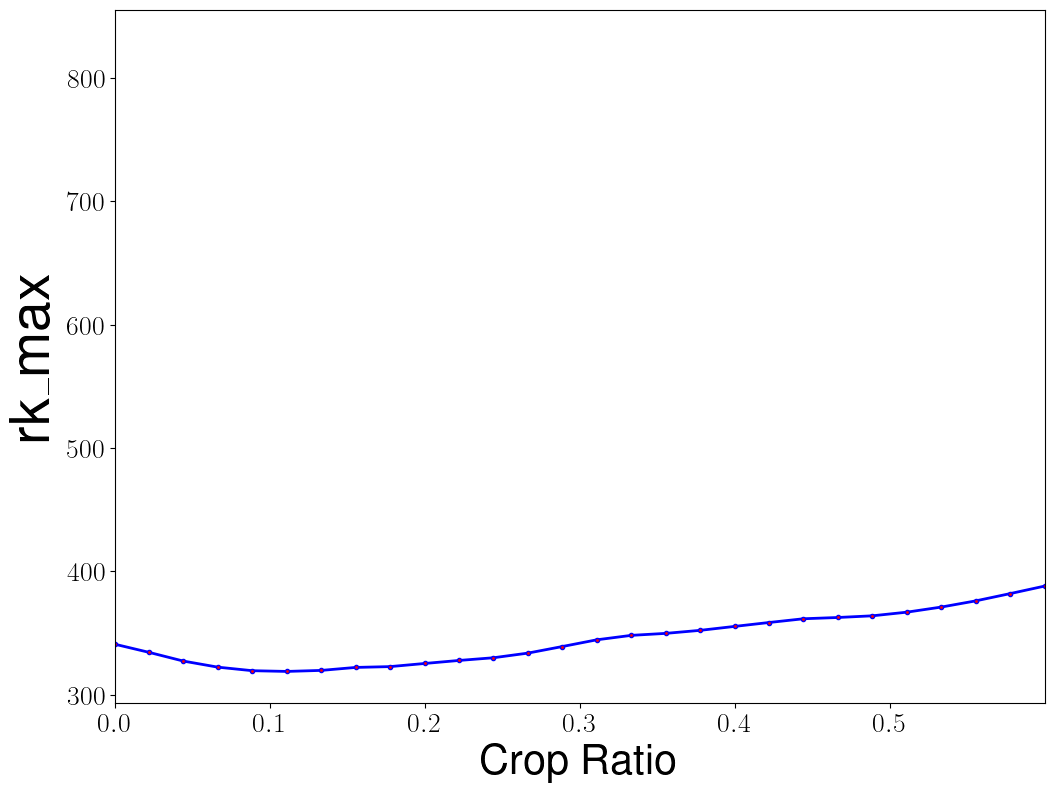

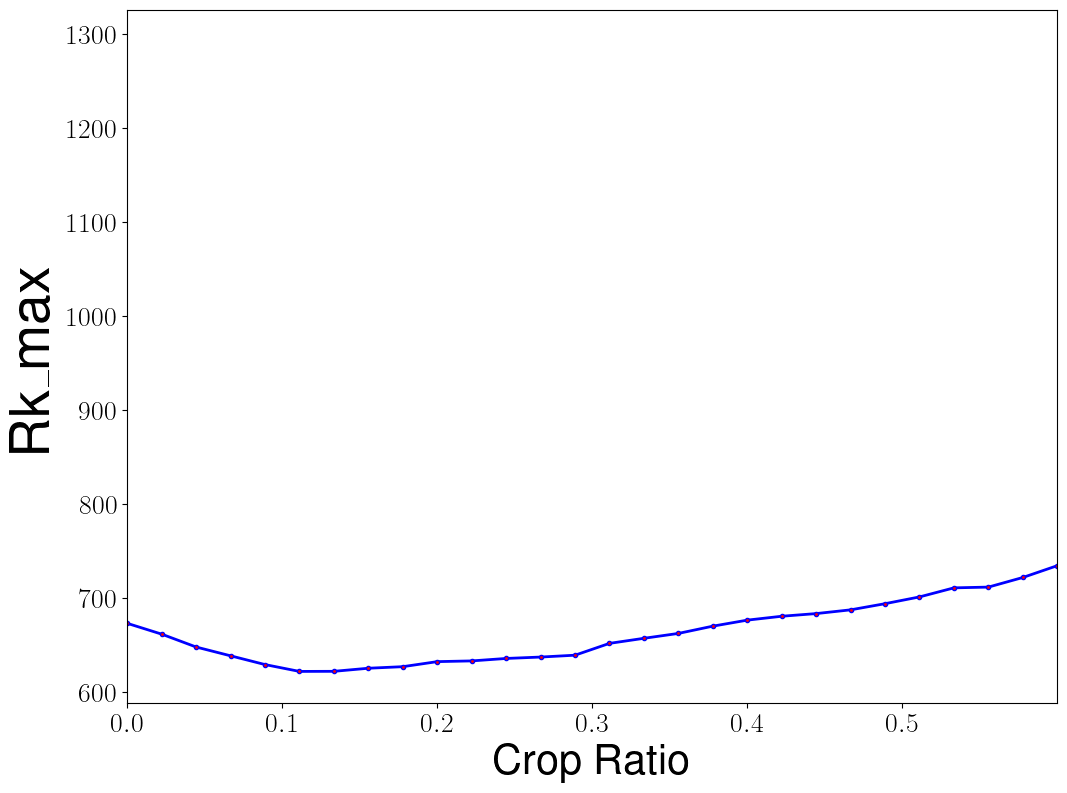

In [74]:
# 绘制Data BOF
# 加载数据到df
file_path = "./input_data/BOF_data.xlsx"
dfs = read_excel(file_path)

# 打印每个DataFrame
for i, df in enumerate(dfs):
    print(f"Sheet {i+1}:\n{df}\n")

# 绘制图像为pdf
data = dfs[0]
df = pd.DataFrame(data)

# 调用函数绘制折线图并保存为PDF
output_folder = "./draw_input/BOF"
plot_line_graphs_BOF(df, output_folder, save_name='Scale', ylabel=None, fig_title='BOF of Data')

Sheet 1:
          r0        R0  rk_max_index      rk_max       Rk_max
0   3.436844  9.225692    933.000000  341.117767   672.763733
1   3.413863  9.056010    934.599976  334.460754   661.249878
2   3.412494  9.002722    999.799988  327.374146   647.545837
3   3.426091  9.025197    980.700012  322.459290   638.184448
4   3.449736  9.092059   1339.900024  319.594452   628.856140
5   3.471112  9.155492   1747.599976  319.005188   621.564087
6   3.496571  9.233131   1783.900024  319.837219   621.670898
7   3.521122  9.310081   1786.500000  322.247742   624.957520
8   3.543707  9.378830   1804.099976  322.909851   626.623657
9   3.566939  9.448359   1788.500000  325.439392   631.996704
10  3.591511  9.523071   1816.599976  327.901184   632.762146
11  3.610572  9.579646   1834.500000  330.086853   635.375305
12  3.628019  9.616961   1879.099976  333.850006   636.865967
13  3.645803  9.645788   1943.900024  339.183289   638.848206
14  3.660711  9.674059   1937.400024  344.631409   651.442383

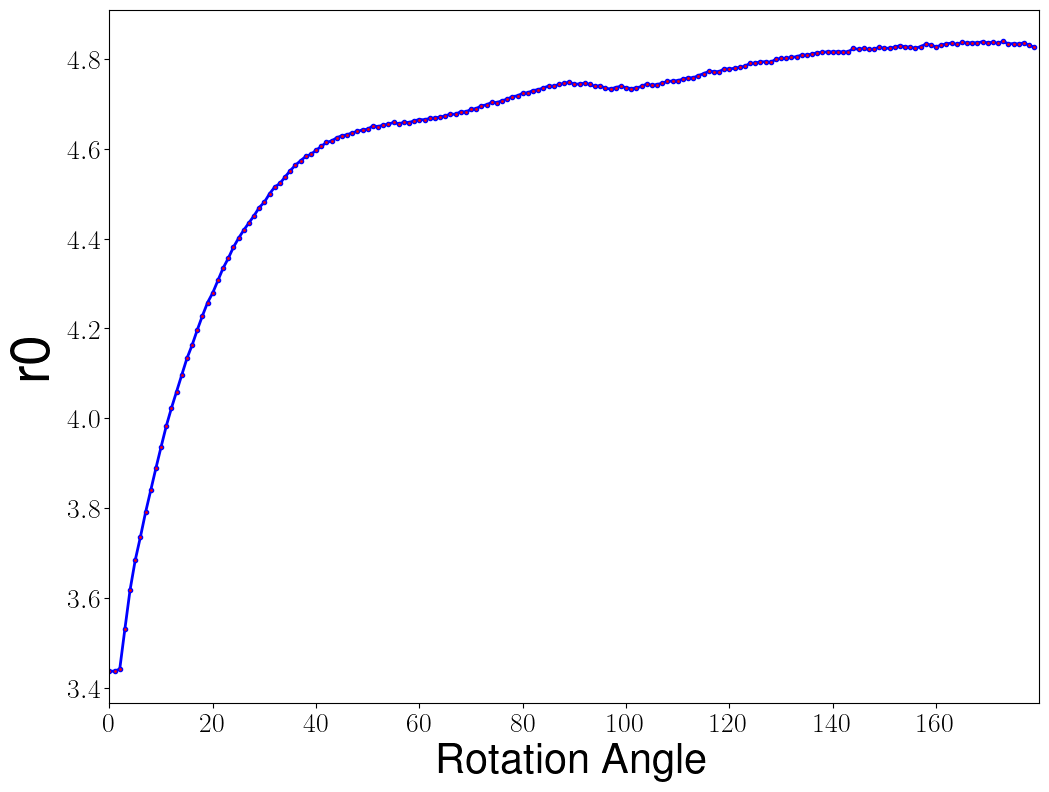

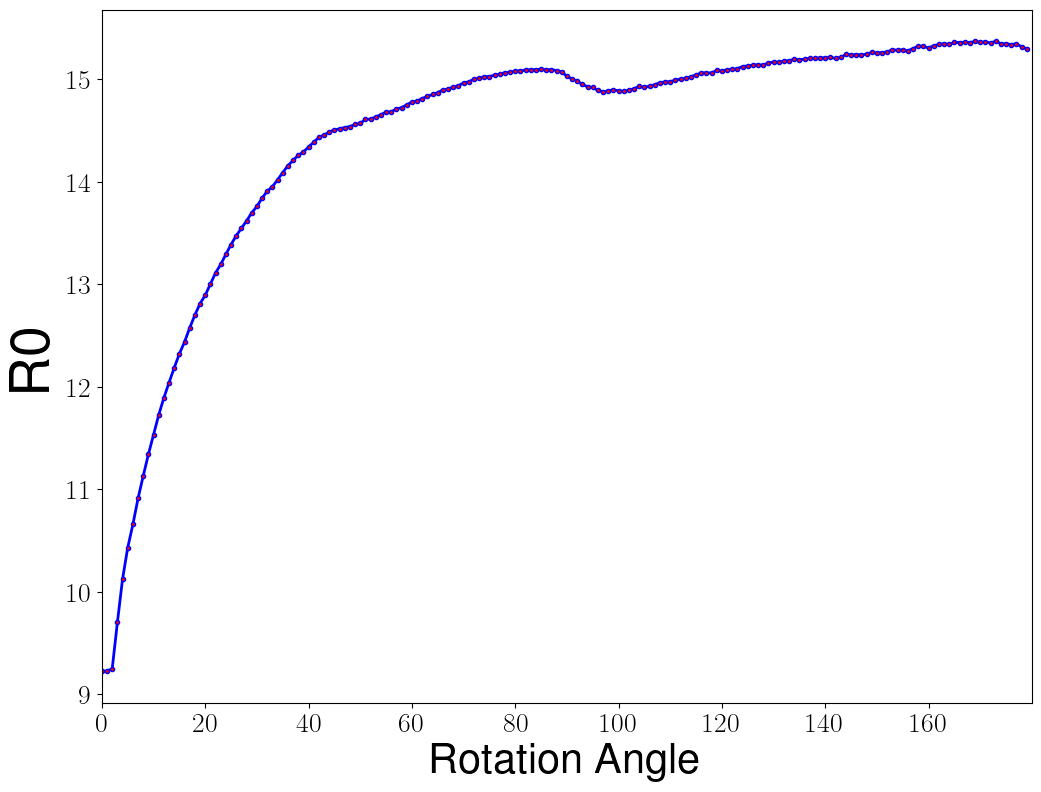

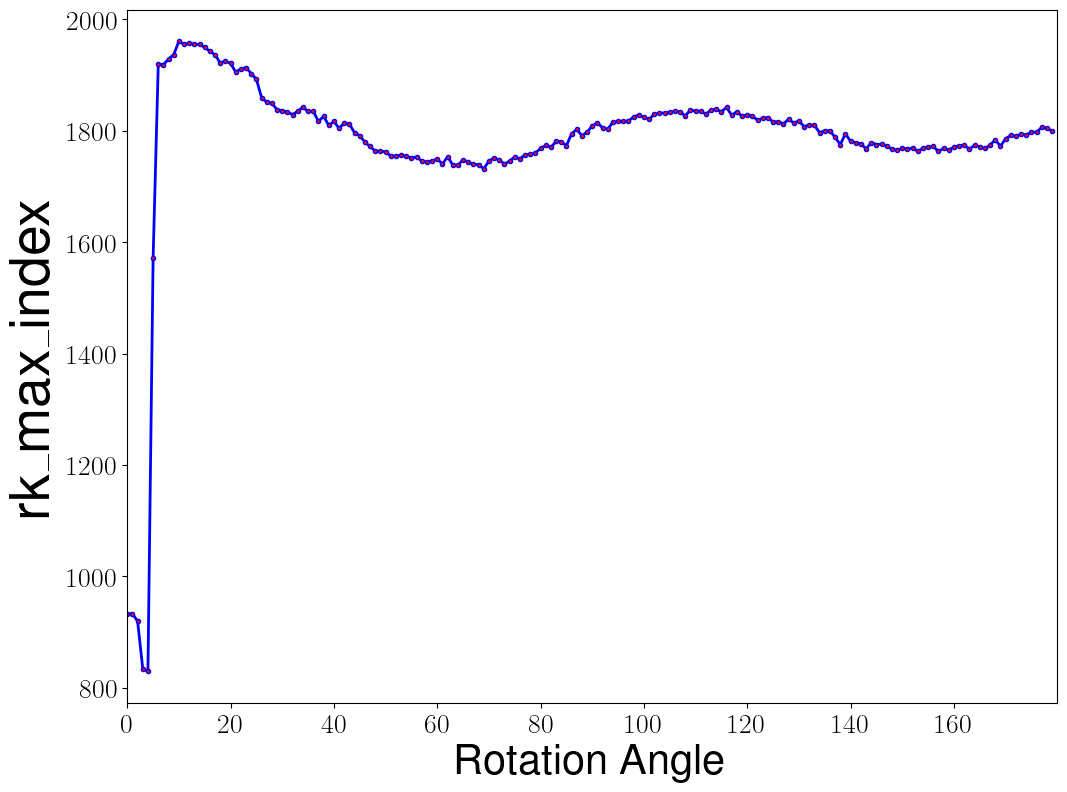

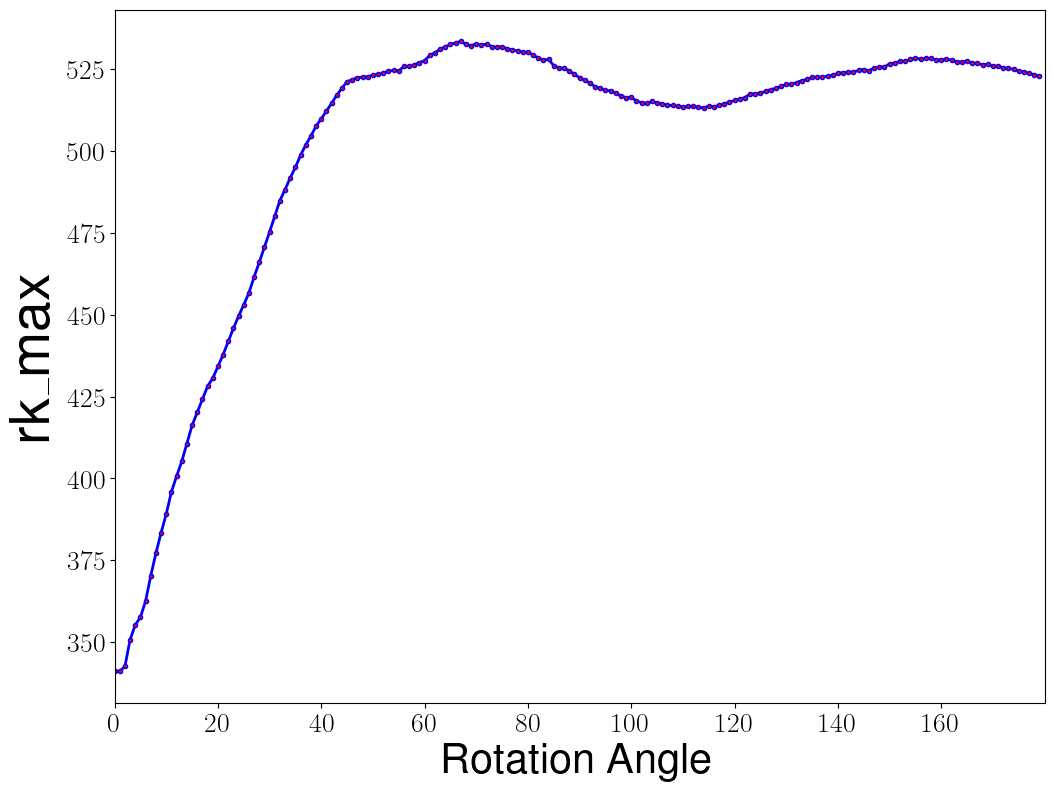

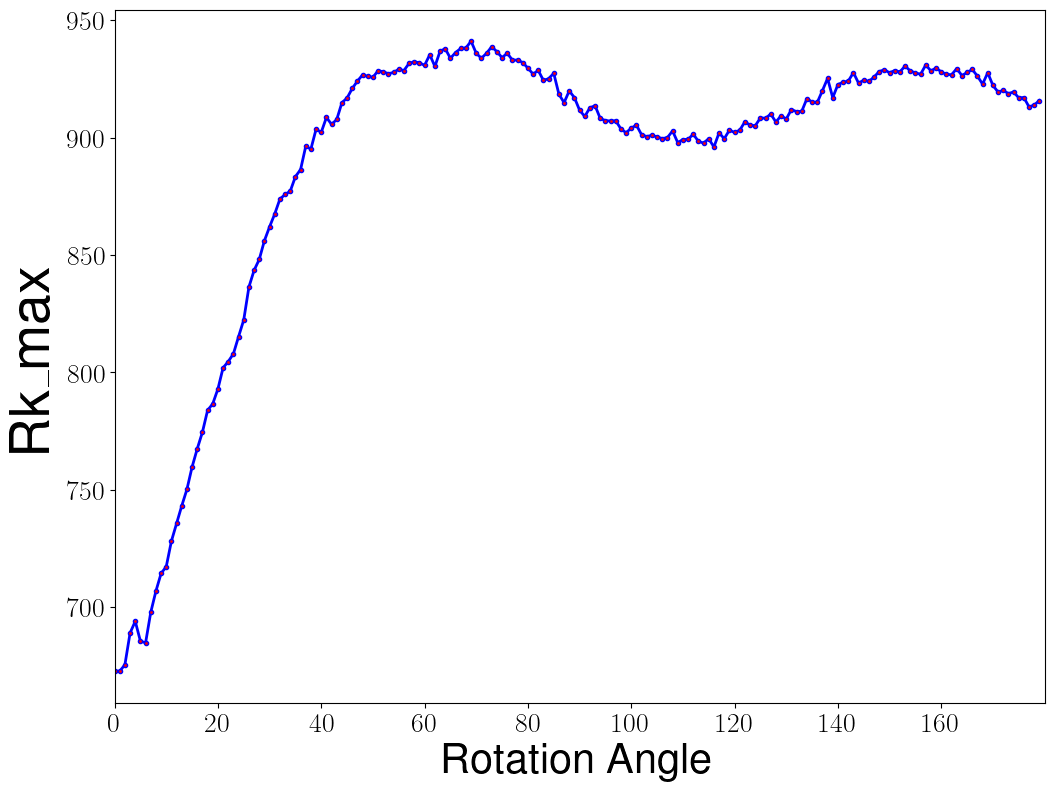

In [75]:
# 绘制Data BOF
# 加载数据到df
file_path = "./input_data/BOF_data.xlsx"
dfs = read_excel(file_path)

# 打印每个DataFrame
for i, df in enumerate(dfs):
    print(f"Sheet {i+1}:\n{df}\n")

# 绘制图像为pdf
data = dfs[1]
df = pd.DataFrame(data)

# 调用函数绘制折线图并保存为PDF
output_folder = "./draw_input/BOF"
plot_line_graphs_BOF(df, output_folder, save_name='Angle', ylabel=None, fig_title='BOF of Data')

### 绘制TDA

Sheet 1:
          Data
0   692.552284
1   687.346969
2   688.396944
3   687.657427
4   691.318258
5   696.467763
6   688.518457
7   696.477020
8   692.843704
9   702.311659
10  702.346823
11  695.016732
12  695.719293
13  701.916926
14  703.176895
15  700.250126
16  701.874007
17  705.502274
18  704.909208
19  701.585905
20  708.894286
21  704.751849
22  703.437700
23  695.001254
24  703.134517
25  697.968605
26  692.363449
27  694.228293
28  691.691386
29  686.135951
30  684.079643
31  681.499469
32  674.154918
33  677.947637
34  670.924781
35  653.665044
36  656.900672
37  648.039264
38  631.638360
39  624.044938
40  621.189725
41  609.283009
42  584.333142
43  582.201653
44  568.525133
45  543.987371

Sheet 2:
           Data
0    692.552284
1    692.552284
2    693.434436
3    702.030693
4    706.116692
..          ...
175  644.969608
176  650.599491
177  636.412558
178  644.287663
179  647.956338

[180 rows x 1 columns]



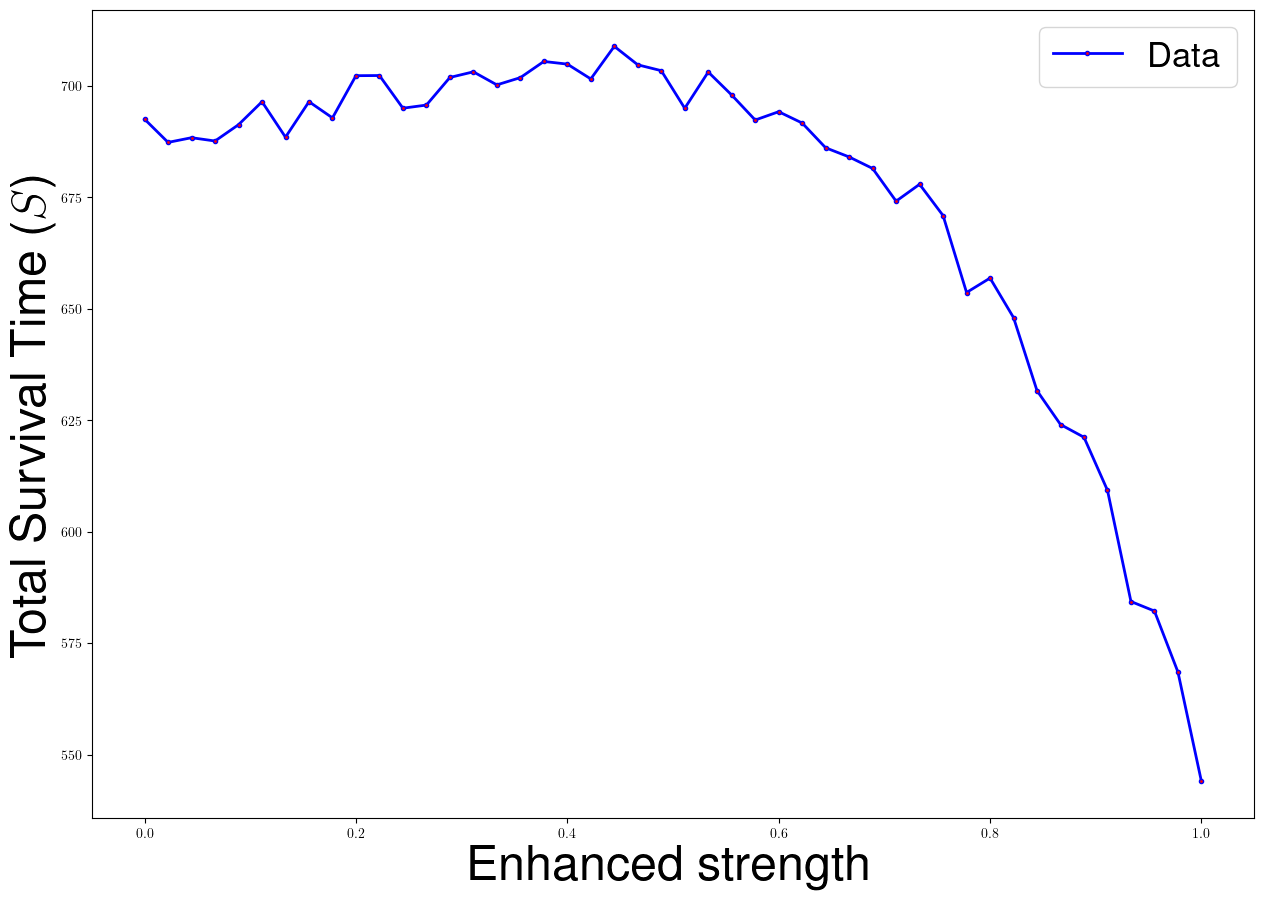

Sheet 1:
         LeNet         MLP    ResNet18    ResNet34    ResNet50   ResNet101  \
0   764.291504  735.097290  852.075195  856.924744  792.492188  795.289612   
1   728.243225  733.074402  851.123962  852.138855  787.164917  795.423218   
2   727.732422  731.487488  848.735840  846.457520  788.359802  792.252441   
3   727.949341  730.976074  848.616943  851.033691  776.492249  784.035828   
4   714.835266  732.650757  848.768494  848.694336  784.229370  790.551880   
5   713.442566  730.146606  848.889038  849.152649  780.938599  788.291138   
6   746.007263  728.448730  844.342773  842.252502  777.852783  782.106873   
7   719.343811  729.145996  850.138428  847.128906  784.883057  791.635864   
8   714.525818  722.642212  847.848022  848.509521  781.885376  786.900757   
9   711.118164  722.364929  852.497925  849.020386  781.861267  787.934753   
10  725.121216  725.401001  849.064331  841.624512  791.490417  795.466248   
11  720.786072  716.718384  845.717041  844.359192  782

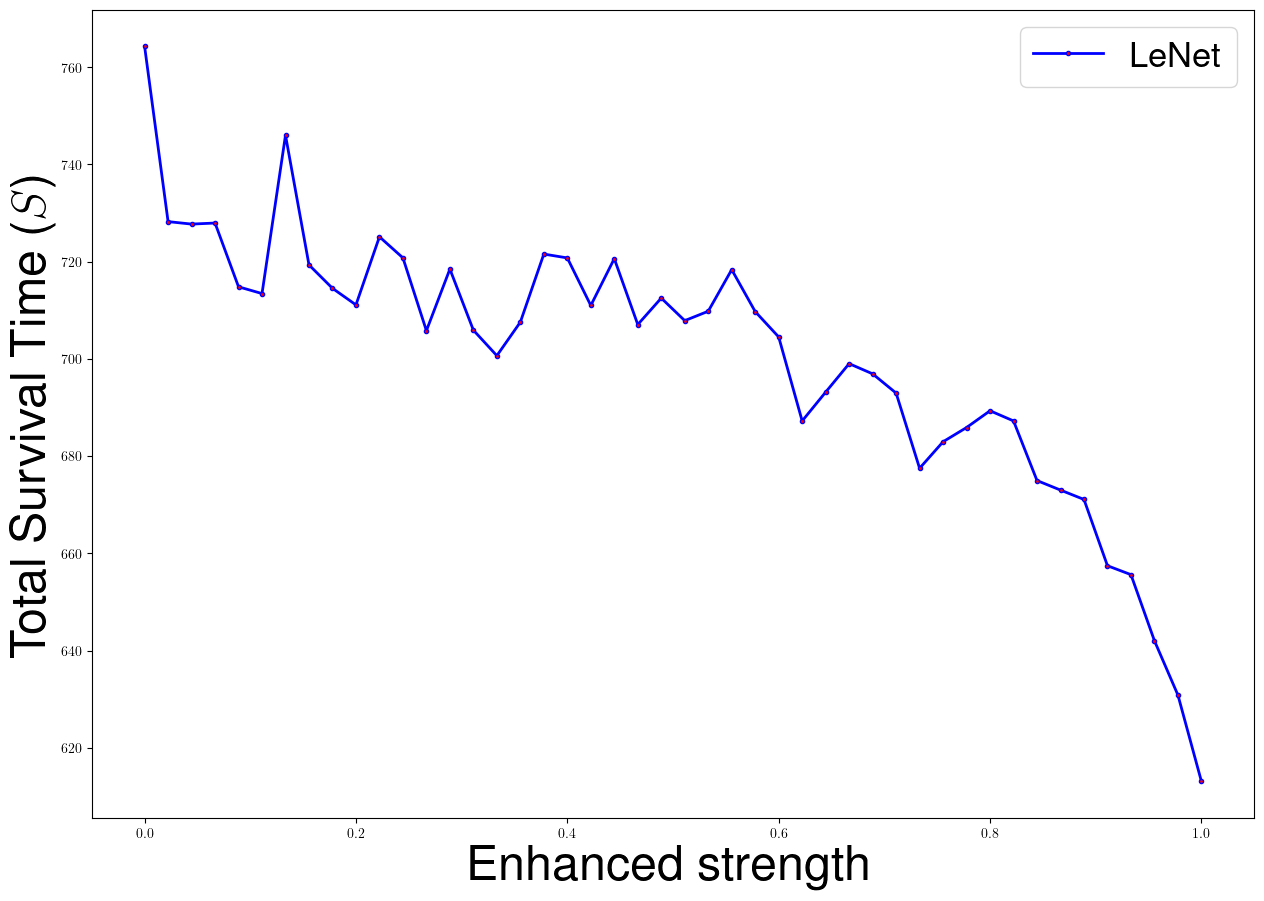

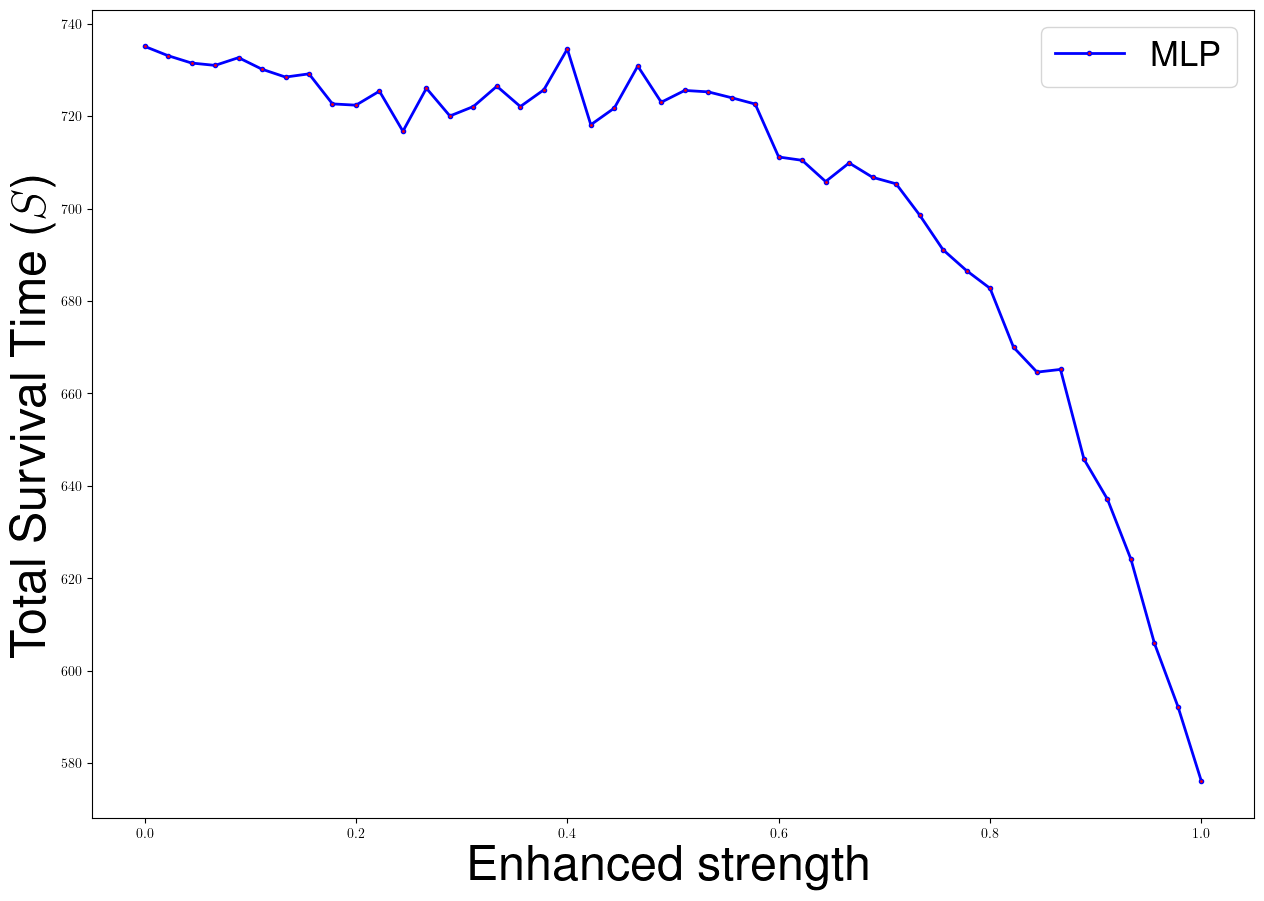

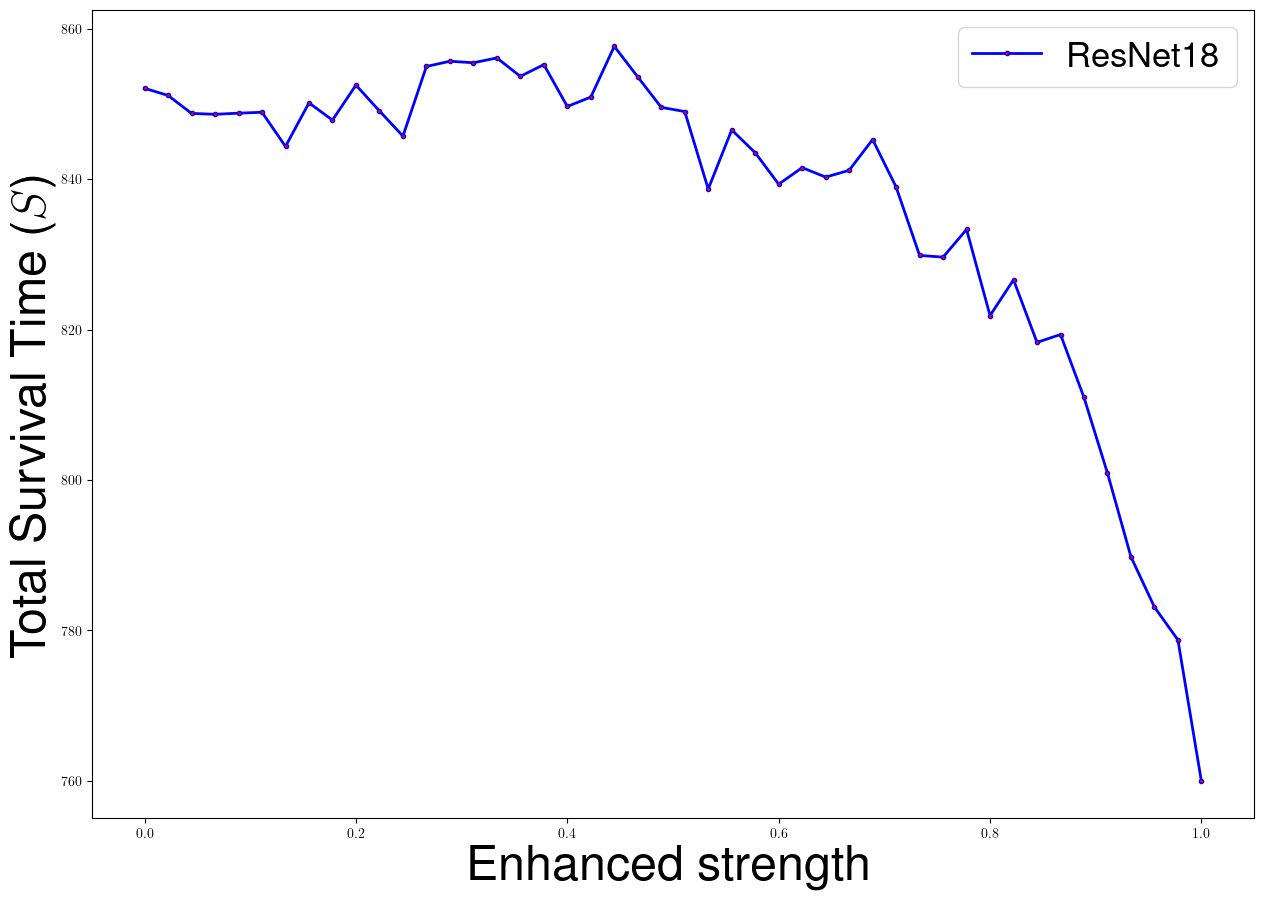

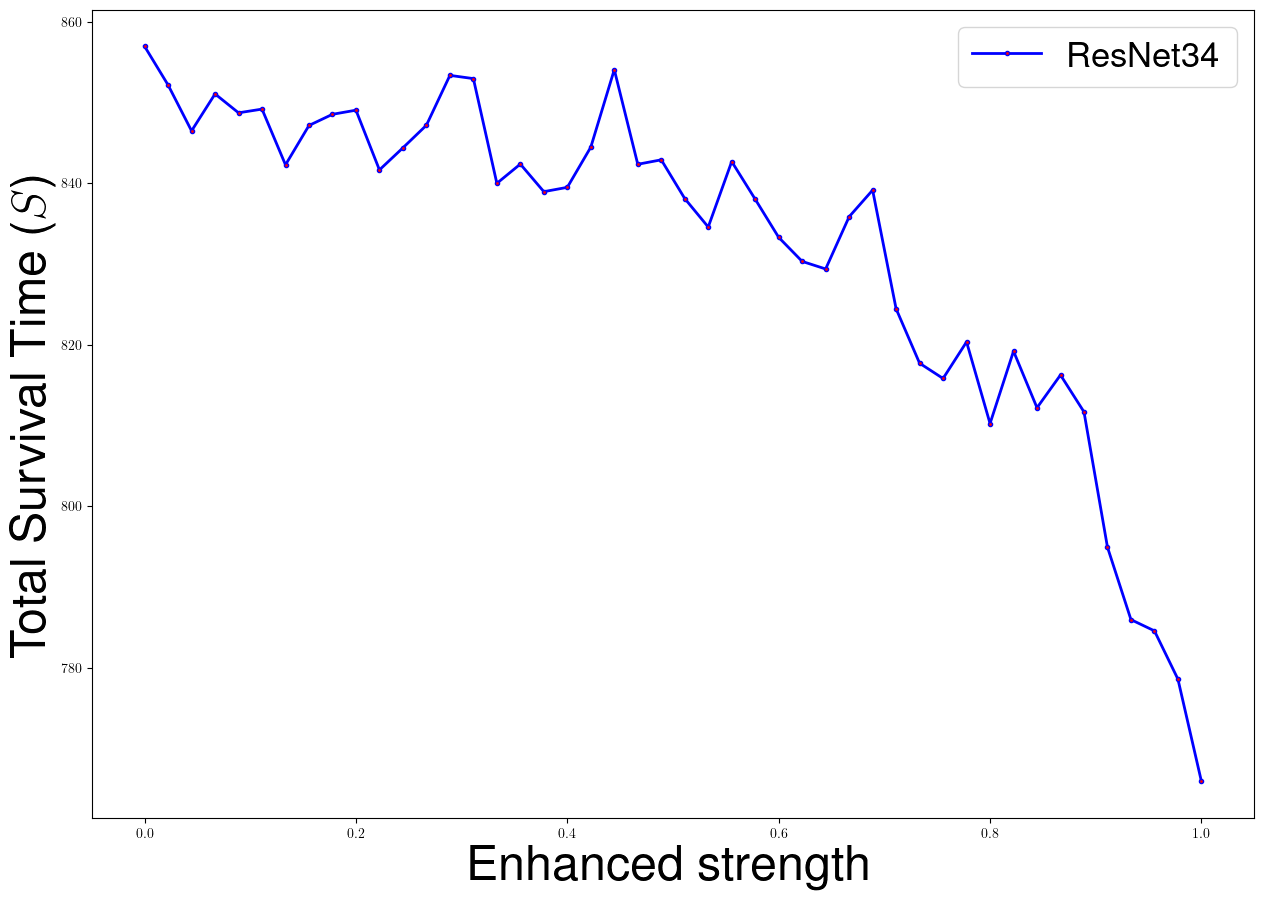

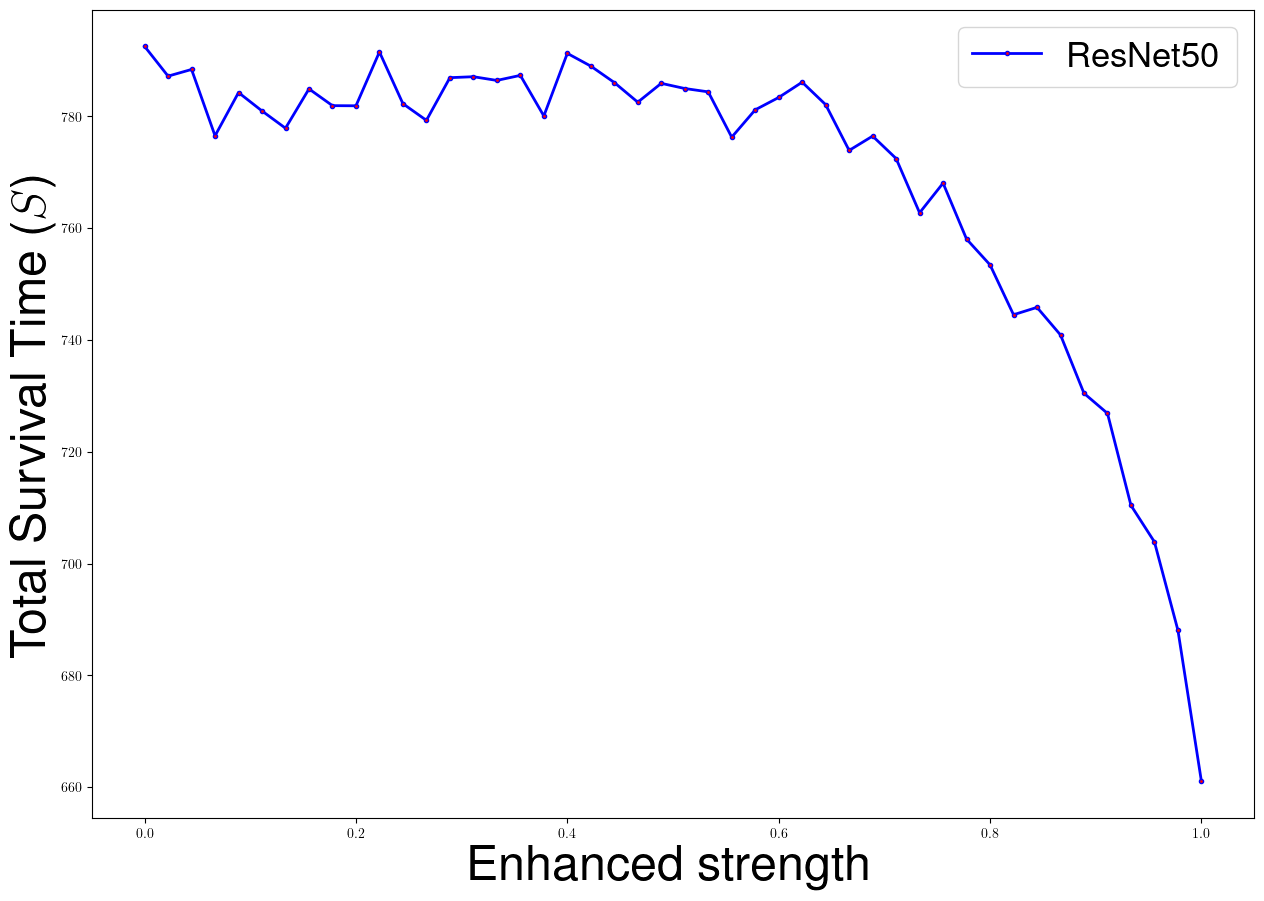

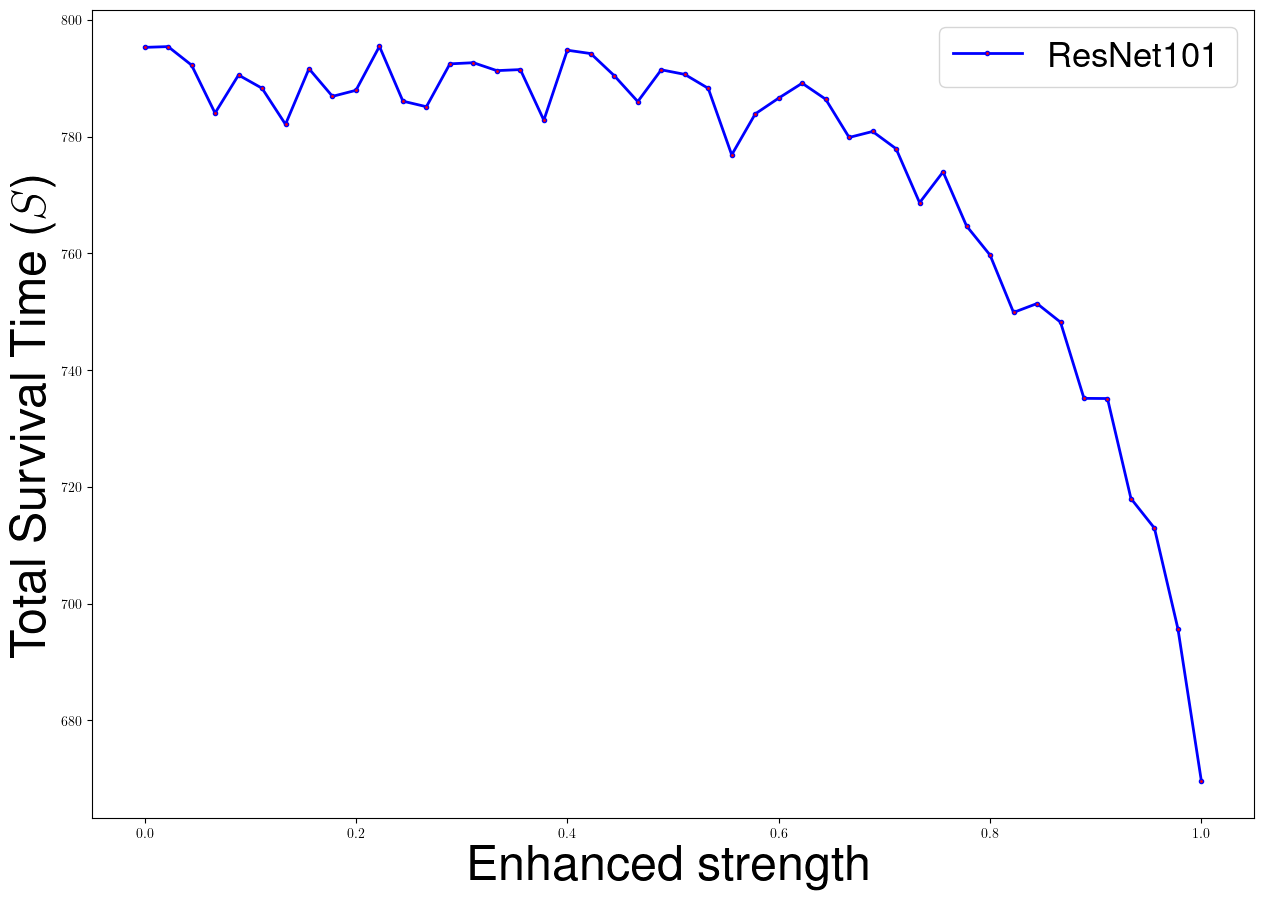

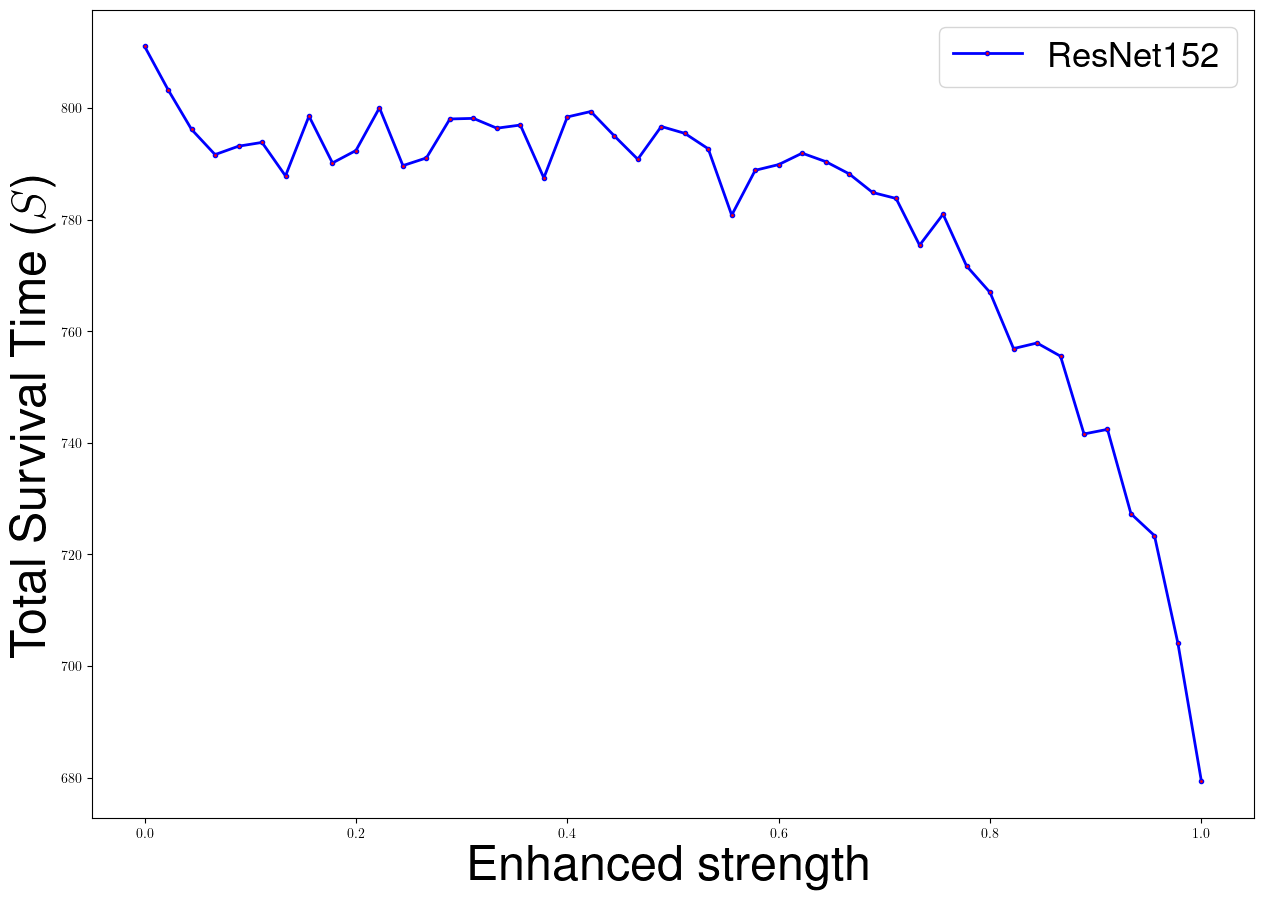

In [89]:
# 绘制Data TDA
# 加载数据到df
file_path = "./input_data/TDA_data.xlsx"
dfs = read_excel(file_path)

# 打印每个DataFrame
for i, df in enumerate(dfs):
    print(f"Sheet {i+1}:\n{df}\n")

# 绘制图像为pdf
data = dfs[0]
df = pd.DataFrame(data)

# 调用函数绘制折线图并保存为PDF
output_folder = "./draw_input/TDA"
plot_line_graphs(df, output_folder, save_name='Scale', ylabel=r'Total Survival Time ($S$)', fig_title='TDA of Data')

# 绘制model TDA
file_path = "./input_data/TDA_out_2_all_bars_surviver_time.xlsx"
dfs = read_excel(file_path)

# 打印每个DataFrame
for i, df in enumerate(dfs):
    print(f"Sheet {i+1}:\n{df}\n")

# 绘制图像为pdf
data = dfs[0]
df = pd.DataFrame(data)

# 调用函数绘制折线图并保存为PDF
output_folder = "./draw_input/TDA"
plot_line_graphs(df, output_folder, save_name='Scale', fig_title='TDA of Model', ylabel=r'Total Survival Time ($S$)')


### TDA 3连

In [87]:
# 绘制Data TDA
# 加载数据到df
data_file_path = "./input_data/TDA_data.xlsx"
data_dfs = read_excel(data_file_path)

# 绘制图像为pdf
data = data_dfs[0]
data_df = pd.DataFrame(data)
print(data_df)

# 调用函数绘制折线图并保存为PDF
output_folder = "./draw_input/TDA"

# 绘制model TDA
model_file_path = "./input_data/TDA_out_2_all_bars_surviver_time.xlsx"
model_dfs = read_excel(file_path)

# 绘制图像为pdf
data = model_dfs[0]
model_df = pd.DataFrame(data)
print(model_df)
# 调用函数绘制折线图并保存为PDF
output_folder = "./draw_input/TDA"

# 使用 pd.concat() 沿着列方向拼接它们
combined_df = pd.concat([data_df, model_df], axis=1)

# 显示合并后的 DataFrame
print(combined_df)

          Data
0   692.552284
1   687.346969
2   688.396944
3   687.657427
4   691.318258
5   696.467763
6   688.518457
7   696.477020
8   692.843704
9   702.311659
10  702.346823
11  695.016732
12  695.719293
13  701.916926
14  703.176895
15  700.250126
16  701.874007
17  705.502274
18  704.909208
19  701.585905
20  708.894286
21  704.751849
22  703.437700
23  695.001254
24  703.134517
25  697.968605
26  692.363449
27  694.228293
28  691.691386
29  686.135951
30  684.079643
31  681.499469
32  674.154918
33  677.947637
34  670.924781
35  653.665044
36  656.900672
37  648.039264
38  631.638360
39  624.044938
40  621.189725
41  609.283009
42  584.333142
43  582.201653
44  568.525133
45  543.987371
         LeNet         MLP    ResNet18    ResNet34    ResNet50   ResNet101  \
0   764.291504  735.097290  852.075195  856.924744  792.492188  795.289612   
1   728.243225  733.074402  851.123962  852.138855  787.164917  795.423218   
2   727.732422  731.487488  848.735840  846.457520  788.35980

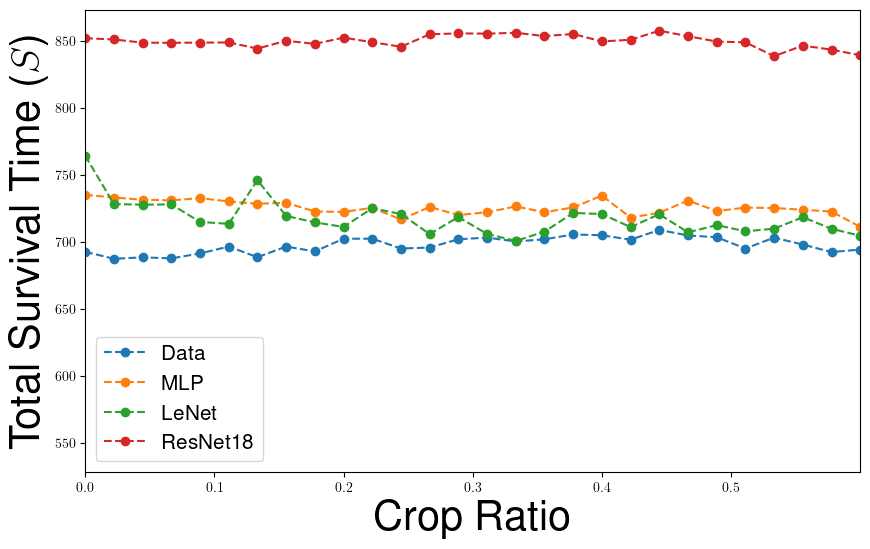

In [88]:
import os
import matplotlib.pyplot as plt
import pandas as pd

def plot_interesting_columns(df, interest_columns, save_name='Angle', save_folder='./draw_input/TDA', save_filename='Angle4'):
    """
    绘制 DataFrame 中指定的感兴趣列的点线图，并保存为PDF文件。

    Args:
    - df (pd.DataFrame): 包含数据的 DataFrame。
    - interest_columns (list): 包含感兴趣列名的列表。
    - save_name (str): 图形类型，用于确定横坐标的类型（'Scale' 或 'Angle'）。
    - save_folder (str): 图片保存的文件夹路径，默认为当前文件夹下的 'output' 文件夹。
    - save_filename (str): 图片保存的文件名，默认为 'plot'。

    Returns:
    - None
    """
    # 创建保存文件夹
    os.makedirs(save_folder, exist_ok=True)

    # 创建一个新的图形
    plt.figure(figsize=(10, 6))
    # 归一化横坐标
    if save_name == 'Scale':
        x = range(len(df))
        x_normalized = [(val - min(x)) / (max(x) - min(x)) for val in x]
        plt.xlim([0, 0.6])
        my_x_ticks = np.arange(0, 0.6, 0.1)
        plt.xlabel(xlabel='Crop Ratio', fontsize=30)
        plt.xticks(my_x_ticks)
    elif save_name == 'Angle':
        x_normalized = range(len(df))
        plt.xlim([0, 180])
        my_x_ticks = np.arange(0, 180, 20)
        plt.xticks(my_x_ticks)
        plt.xlabel(xlabel='Rotation Angle', fontsize=30)

    # 遍历感兴趣列，绘制点线图
    for column in interest_columns:
        plt.plot(x_normalized, df[column], label=column, marker='o', linestyle='--')

    # 添加标题和标签
    plt.title('', fontsize=25)
    plt.ylabel(r'Total Survival Time ($S$)', fontsize=30)

    # 添加图例
    plt.legend(fontsize=15)

    # 调整坐标轴刻度的字体大小
    plt.tick_params(axis='both', labelsize=10)

    # 保存为PDF文件
    save_path = os.path.join(save_folder, f'{save_filename}_{save_name}.pdf')
    plt.savefig(save_path)

    # 显示图形
    plt.show()

# 示例用法
# 假设 combined_df 是你的 DataFrame，interest_columns 是包含感兴趣列名的列表
# 图片将保存在当前文件夹下的 'output' 文件夹中，文件名为 'plot_Angle.pdf'
plot_interesting_columns(combined_df, interest_columns=['Data', 'MLP', 'LeNet', 'ResNet18'], save_name='Scale', save_filename='Scale')


# 绘制两个变量之间的关系

我们发现，有一些变量关系之间的相关度很奇怪，为了稳妥起见，我们决定绘制出对应的**散点图**来辅助观察。

## 首先定义一些函数

### 定义读取数据的函数

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import uuid

def calculate_correlation_and_plot_scatter(file_path1, sheet_name1, column_name1, file_path2, sheet_name2, column_name2, x:int =100, save_path:str='./scatter_diagram', my_title:str='Scale', my_xlabel:str='Performance of the ', my_ylabel:str=' on data'):
    """
    Calculate the Spearman correlation between the first x% of data in two columns in different Excel files,
    plot a scatter plot with control over point size and color, and save the plot as a PDF.

    Parameters:
    - file_path1 (str): Path to the first Excel file.
    - sheet_name1 (str): Name of the sheet in the first Excel file.
    - column_name1 (str): Name of the column in the first sheet for which correlation is calculated.

    - file_path2 (str): Path to the second Excel file.
    - sheet_name2 (str): Name of the sheet in the second Excel file.
    - column_name2 (str): Name of the column in the second sheet for which correlation is calculated.

    - x (float): The percentage of data to consider for correlation calculation.

    - save_path (str, optional): Path to save the plot as a PDF. If None, the plot will be displayed but not saved.

    Returns:
    - float: The Spearman correlation coefficient.
    - float: The two-tailed p-value for a hypothesis test whose null hypothesis is that the two samples are uncorrelated.
    """
    # 创建输出文件夹（如果不存在）
    # if not os.path.exists(save_path):
    #     os.makedirs(save_path, exist_ok=True)

    # Read data from Excel files
    df1 = pd.read_excel(file_path1, sheet_name=sheet_name1)
    df2 = pd.read_excel(file_path2, sheet_name=sheet_name2)

    # Calculate the number of rows to select
    num_rows = int(len(df1) * x / 100)

    # Select the first x% of data
    vector1 = df1[column_name1].head(num_rows).squeeze()  # 使用 .squeeze() 将二维转为一维
    vector2 = df2[column_name2].head(num_rows).squeeze()  # 使用 .squeeze() 将二维转为一维

    # Calculate Spearman correlation
    correlation_coefficient, p_value = calculate_spearman_correlation(vector1, vector2)

    # Plot scatter plot with control over point size and color
    plt.figure(figsize=(10, 6))

    # Set a constant color for all points
    color = 'blue'
    size = 50

    # Plot scatter plot
    sns.scatterplot(x=vector1, y=vector2, color=color, size=size)

    # Add legend with correlation_coefficient
    plt.legend([f'Correlation: {correlation_coefficient:.2f}'], loc='upper right')
    pdf_title = f'On {x}% of the data Correlation between {my_xlabel} {column_name1} and {column_name2} {my_ylabel} with {my_title}'
    # 将字符串中的所有空格替换为下划线
    pdf_title_with_underscores = pdf_title.replace(" ", "_")
    plt.title(pdf_title)
    plt.xlabel(f'{my_xlabel} {column_name1}')
    plt.ylabel(f'{column_name2} {my_ylabel}')

    # Save plot as PDF if save_path is provided
    if save_path:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        # Generate a unique filename using uuid
        unique_filename = str(uuid.uuid4())
        pdf_filepath = os.path.join(save_path, f'{pdf_title_with_underscores}.pdf')

        plt.savefig(pdf_filepath, format='pdf')
        plt.close()  # 关闭绘图，确保图像文件已保存
    else:
        plt.show()

    return correlation_coefficient, p_value


# Example Usage:
percenatge = 100
file_path1 = './input_data/best_val_acc_kaiming.xlsx'
sheet_name1 = 'Scale'
column_name1 = 'ResNet152'

file_path2 = './input_data/TDA_data.xlsx'
sheet_name2 = sheet_name1
column_name2 = ['Data']

correlation, p_value = calculate_correlation_and_plot_scatter(file_path1, sheet_name1, column_name1, file_path2, sheet_name2, column_name2, x=percenatge)

print(f"Spearman Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

NameError: name 'calculate_spearman_correlation' is not defined

## 绘制相关性

### 绘制BOF和Acc之间的关系

In [ ]:
# Example Usage:
percenatge = 100
file_path1 = './input_data/best_val_acc_kaiming.xlsx'
sheet_name1 = 'Scale'
column_name1 = 'ResNet152'

file_path2 = './input_data/BOF_data.xlsx'
sheet_name2 = sheet_name1
column_name2 = ['r0']

sheet_names = ['Scale', 'Angle']
column_names = ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']
for sheet_name1 in sheet_names:
    for column_name1 in column_names:
        sheet_name2 = sheet_name1
        correlation, p_value = calculate_correlation_and_plot_scatter(file_path1, sheet_name1, column_name1, file_path2, sheet_name2, column_name2, x=percenatge, my_title=sheet_name1, save_path='./scatter_diagram/BOF')
        print(column_name1)
        print(f"Spearman Correlation Coefficient: {correlation}")
        print(f"P-value: {p_value}")

MLP
Spearman Correlation Coefficient: 0.6398593854224782
P-value: 1.6868199313592621e-06
LeNet
Spearman Correlation Coefficient: 0.7214752696588459
P-value: 1.5418028701521817e-08
ResNet18
Spearman Correlation Coefficient: 0.7786000616712919
P-value: 1.8885149337629423e-10
ResNet34
Spearman Correlation Coefficient: 0.6253854705369036
P-value: 3.371583926725079e-06
ResNet50
Spearman Correlation Coefficient: 0.7624275332127417
P-value: 7.429272229878632e-10
ResNet101
Spearman Correlation Coefficient: 0.7385981686573105
P-value: 4.644712590167862e-09
ResNet152
Spearman Correlation Coefficient: 0.71146196339602
P-value: 2.9878296642139535e-08
MLP
Spearman Correlation Coefficient: -0.9135293633874494
P-value: 1.9035205535483814e-71
LeNet
Spearman Correlation Coefficient: -0.9083509781868566
P-value: 2.6626746036378277e-69
ResNet18
Spearman Correlation Coefficient: -0.3851815059804819
P-value: 9.335283755542201e-08
ResNet34
Spearman Correlation Coefficient: -0.2695942246060389
P-value: 0.000

### 绘制TDA和Acc之间的关系

In [ ]:
# 首先考察的Data TDA
percenatge = 100
file_path1 = './input_data/best_val_acc_kaiming.xlsx'
sheet_name1 = 'Scale'
column_name1 = 'ResNet152'

file_path2 = './input_data/TDA_data.xlsx'
sheet_name2 = sheet_name1
column_name2 = ['Data']

sheet_names = ['Scale', 'Angle']
column_names = ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']
for sheet_name1 in sheet_names:
    for column_name1 in column_names:
        sheet_name2 = sheet_name1
        correlation, p_value = calculate_correlation_and_plot_scatter(file_path1, sheet_name1, column_name1, file_path2, sheet_name2, column_name2, x=percenatge, my_title=sheet_name1, save_path='./scatter_diagram/TDA')
        print(column_name1)
        print(f"Spearman Correlation Coefficient: {correlation}")
        print(f"P-value: {p_value}")

MLP
Spearman Correlation Coefficient: 0.7803509208434328
P-value: 1.6171596511385909e-10
LeNet
Spearman Correlation Coefficient: 0.8362526227820389
P-value: 4.675038838286368e-13
ResNet18
Spearman Correlation Coefficient: 0.879740980573543
P-value: 8.383378255754172e-16
ResNet34
Spearman Correlation Coefficient: 0.7613173814898953
P-value: 8.12938614129421e-10
ResNet50
Spearman Correlation Coefficient: 0.8684470227445895
P-value: 5.3551124903168435e-15
ResNet101
Spearman Correlation Coefficient: 0.8591075892949513
P-value: 2.1909591288141688e-14
ResNet152
Spearman Correlation Coefficient: 0.8480064144153323
P-value: 1.0312485161095923e-13
MLP
Spearman Correlation Coefficient: 0.20529239887295175
P-value: 0.005699143454576815
LeNet
Spearman Correlation Coefficient: 0.18283506078594
P-value: 0.014024138575263722
ResNet18
Spearman Correlation Coefficient: 0.1843586552232163
P-value: 0.01323164870236103
ResNet34
Spearman Correlation Coefficient: 0.1925802392076222
P-value: 0.00959688557307

In [ ]:
# 然后考察Model TDA

percenatge = 50
file_path1 = './input_data/best_val_acc_kaiming.xlsx'
sheet_name1 = 'Scale'
column_name1 = 'ResNet152'

file_path2 = './input_data/TDA_out_2_all_bars_surviver_time.xlsx'
sheet_name2 = sheet_name1
column_name2 = ['Data']

sheet_names = ['Scale', 'Angle']
column_names = ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']
for sheet_name1 in sheet_names:
    for column_name1 in column_names:
        sheet_name2 = sheet_name1
        column_name2 = column_name1
        correlation, p_value = calculate_correlation_and_plot_scatter(file_path1, sheet_name1, column_name1, file_path2, sheet_name2, column_name2, x=percenatge, my_title=sheet_name1, save_path='./scatter_diagram/TDA_model', my_ylabel=' out TDA')
        print(column_name1)
        print(f"Spearman Correlation Coefficient: {correlation}")
        print(f"P-value: {p_value}")

MLP
Spearman Correlation Coefficient: -0.45712875129169367
P-value: 0.028307791608679373
LeNet
Spearman Correlation Coefficient: -0.5012358496709346
P-value: 0.014829825465986442
ResNet18
Spearman Correlation Coefficient: 0.18972332015810275
P-value: 0.3859122459775909
ResNet34
Spearman Correlation Coefficient: -0.05388038226245747
P-value: 0.8071006184247151
ResNet50
Spearman Correlation Coefficient: -0.20019775060821351
P-value: 0.35972312051695254
ResNet101
Spearman Correlation Coefficient: -0.010872251382072715
P-value: 0.9607320323459436
ResNet152
Spearman Correlation Coefficient: -0.05683222313356192
P-value: 0.796741819492141
MLP
Spearman Correlation Coefficient: 0.3805266757147787
P-value: 0.00021582439155912886
LeNet
Spearman Correlation Coefficient: 0.3333292175847673
P-value: 0.0013256305981730395
ResNet18
Spearman Correlation Coefficient: 0.13778881056623568
P-value: 0.1952877421718252
ResNet34
Spearman Correlation Coefficient: 0.08041789737246913
P-value: 0.451168532798720

# 得到有用半径

## 定义相关函数

### 得到目标数据

我需要一个函数，这个函数的输入可以是一个list，一个numpy向量，df的一列数据等，总之它表示了一些数据。这个函数可以根据我的选择，也就是传入的两个参数，返回这串数据的全局最大值、全局最小值、局部最大值、局部最小值中的某一个；如果局部最大或者局部最小值不止一个，就需要返回第一个值。而且返回的不仅仅是这个值，也要返回这个value对应的index

In [34]:
import numpy as np
import pandas as pd

def find_extrema(data, extrema_type):
    """
    寻找数据的极值。

    参数:
    - data: 输入数据，可以是列表、NumPy数组或Pandas DataFrame的列。
    - extrema_type: 极值类型，可以是 'global_max'、'global_min'、'local_max' 或 'local_min'。

    返回:
    - tuple: 包含找到的极值和其对应的归一化索引。如果是局部最大或局部最小，只返回第一个。
    """

    if isinstance(data, list):
        data = np.array(data)
    elif isinstance(data, pd.Series):
        data = data.values

    if extrema_type == 'global_max':
        global_max_index = np.argmax(data)
        normalized_index = round(global_max_index / len(data), 4)
        return data[global_max_index], normalized_index
    elif extrema_type == 'global_min':
        global_min_index = np.argmin(data)
        normalized_index = round(global_min_index / len(data), 4)
        return data[global_min_index], normalized_index
    elif extrema_type == 'local_max':
        local_max_indices = np.where((data[1:-1] > data[:-2]) & (data[1:-1] > data[2:]))[0]
        if len(local_max_indices) > 0:
            normalized_index = round((local_max_indices[0] + 1) / len(data), 4)
            return data[local_max_indices[0] + 1], normalized_index
        else:
            return None
    elif extrema_type == 'local_min':
        local_min_indices = np.where((data[1:-1] < data[:-2]) & (data[1:-1] < data[2:]))[0]
        if len(local_min_indices) > 0:
            normalized_index = round((local_min_indices[0] + 1) / len(data), 4)
            return data[local_min_indices[0] + 1], normalized_index
        else:
            return None
    else:
        raise ValueError("Invalid extrema_type. Choose from 'global_max', 'global_min', 'local_max', 'local_min'.")

# ---------测试函数---------------
# 例子
data_list = [1, 1, 7, 0, 2, 6, 8, 4, -1, 2]
data_array = np.array(data_list)
data_df = pd.DataFrame({'column_name': data_list})

global_max, global_max_index = find_extrema(data_list, 'global_max')
print(f"Global Max: {global_max}, Index: {global_max_index}")

local_max, local_max_index = find_extrema(data_list, 'local_max')
print(f"Local Max: {local_max}, Index: {local_max_index}")

# 对于其他数据类型，也可以使用
global_min, global_min_index = find_extrema(data_array, 'global_min')
print(f"Global Min: {global_min}, Index: {global_min_index}")

local_min, local_min_index = find_extrema(data_df['column_name'], 'local_min')
print(f"Local Min: {local_min}, Index: {local_min_index}")

# 创建一个示例 DataFrame
data = {
    'col1': [1, 3, 7, 1, 2, 6, 8, 4, 9, 2],
    'col2': [5, 3, 2, 8, 1, 7, 6, 9, 4, 2],
    'col3': [9, 2, 6, 4, 8, 1, 5, 7, 3, 2]
}

df = pd.DataFrame(data)

# 对每一列应用 find_extrema 函数
result = df.apply(lambda column: find_extrema(column, 'global_min'))

# 打印结果
print(result)


Global Max: 8, Index: 0.6
Local Max: 7, Index: 0.2
Global Min: -1, Index: 0.8
Local Min: 0, Index: 0.3
   col1  col2  col3
0   1.0   1.0   1.0
1   0.0   0.4   0.5


### 得到某种数据的极值

In [35]:
import pandas as pd

import pandas as pd

def process_extreme_value(file_path, extreme_type='global_max'):
    """
    Process extreme values in each sheet of an Excel file.

    Parameters:
    - file_path (str): Path to the Excel file.
    - extreme_type (str): Type of extreme value to extract. Default is 'global_max'.
    - extrema_type: 极值类型，可以是 'global_max'、'global_min'、'local_max' 或 'local_min'

    Returns:
    - dict: A dictionary containing extreme values for each sheet.
            The keys are sheet names, and the values are dictionaries with columns and their extreme values as lists.
    """

    # Read Excel file
    dfs = pd.read_excel(file_path, sheet_name=None)

    # Initialize result dictionary
    save_dic = {}

    # Process each DataFrame
    for sheet_name, df in dfs.items():
        # Apply find_extrema function to each column
        if sheet_name == "R0":
            print(sheet_name)
            extreme_type = 'local_max'
        # result = df.apply(lambda column: find_extrema(column, extreme_type))
        result = df.apply(lambda column: find_extrema(column, extreme_type) if column.name != 'R0' else find_extrema(column, extrema_type='local_max'))
        print(result)
        result_dict = result.iloc[1].to_dict()

        # Convert dictionary values to lists
        result_dict_as_list = {key: [value] for key, value in result_dict.items()}
        save_dic[sheet_name] = result_dict_as_list

    return save_dic
# 调用函数
BOF_data_file_path = "./input_data/BOF_data.xlsx"
BOF_data_save_dic = process_extreme_value(BOF_data_file_path, 'local_min')
print(BOF_data_save_dic)


         r0        R0  rk_max_index      rk_max      Rk_max
0  3.412494  9.836319    980.700012  319.005188  621.564087
1  0.043500  0.413000      0.065200    0.108700    0.108700
         r0         R0  rk_max_index      rk_max      Rk_max
0  4.649371  15.025469    829.799988  524.444824  684.835266
1  0.288900   0.411100      0.022200    0.305600    0.033300
{'Scale': {'r0': [0.0435], 'R0': [0.413], 'rk_max_index': [0.0652], 'rk_max': [0.1087], 'Rk_max': [0.1087]}, 'Angle': {'r0': [0.2889], 'R0': [0.4111], 'rk_max_index': [0.0222], 'rk_max': [0.3056], 'Rk_max': [0.0333]}}


### 得到邻域

In [36]:
import pandas as pd

def calculate_radius_min(df_data, df_r_values, ratio=1.0):
    # 初始化结果的DataFrame
    result_df = pd.DataFrame(index=df_r_values.columns, columns=df_data.columns)

    for i in df_data.columns:
        for j in df_r_values.columns:
            r_value = df_r_values[j].iloc[0]
            center_index = df_data[i].iloc[0]
            r = abs(r_value - center_index) * ratio
            min_index = round(max(0, center_index - r), 4)
            max_index = round(center_index + r, 4)
            result_df[f'{i}'][f'{j}'] = np.array([center_index, r_value])

    return result_df


# 示例数据
data2 = {'LeNet': [14.0], 'MLP': [8.0], 'ResNet18': [10.0], 'ResNet34': [8.0], 'ResNet50': [9.0], 'ResNet101': [14.0], 'ResNet152': [10.0]}

data1 = {
    'r0': [2.0],
    'rk_max': [5.0]
}

df_data = pd.DataFrame(data1)
df_r_values = pd.DataFrame(data2)

# 调用函数
result_df = calculate_radius_min(df_data, df_r_values)
print(result_df)


                    r0       rk_max
LeNet      [2.0, 14.0]  [5.0, 14.0]
MLP         [2.0, 8.0]   [5.0, 8.0]
ResNet18   [2.0, 10.0]  [5.0, 10.0]
ResNet34    [2.0, 8.0]   [5.0, 8.0]
ResNet50    [2.0, 9.0]   [5.0, 9.0]
ResNet101  [2.0, 14.0]  [5.0, 14.0]
ResNet152  [2.0, 10.0]  [5.0, 10.0]


## 模型表现情况

In [37]:
Acc_file_path = "./input_data/best_val_acc_kaiming.xlsx"
Acc_save_dic = process_extreme_value(Acc_file_path)
print(Acc_save_dic)

    LeNet     MLP  ResNet18  ResNet34  ResNet50  ResNet101  ResNet152
0  0.7423  0.6150    0.9248    0.9277    0.9247     0.9248     0.9282
1  0.2826  0.1739    0.2609    0.2609    0.1957     0.3913     0.4565
    LeNet     MLP  ResNet18  ResNet34  ResNet50  ResNet101  ResNet152
0  0.7183  0.6012     0.896    0.9064    0.9023     0.9026     0.9069
1  0.1000  0.1667     0.100    0.1556    0.1500     0.3167     0.5444
{'Scale': {'LeNet': [0.2826], 'MLP': [0.1739], 'ResNet18': [0.2609], 'ResNet34': [0.2609], 'ResNet50': [0.1957], 'ResNet101': [0.3913], 'ResNet152': [0.4565]}, 'Angle': {'LeNet': [0.1], 'MLP': [0.1667], 'ResNet18': [0.1], 'ResNet34': [0.1556], 'ResNet50': [0.15], 'ResNet101': [0.3167], 'ResNet152': [0.5444]}}


## BOF的表现情况

In [38]:
BOF_file_path = "./input_data/BOF_data.xlsx"
BOF_save_dic = process_extreme_value(BOF_file_path, extreme_type='local_min')
print(BOF_save_dic)

         r0        R0  rk_max_index      rk_max      Rk_max
0  3.412494  9.836319    980.700012  319.005188  621.564087
1  0.043500  0.413000      0.065200    0.108700    0.108700
         r0         R0  rk_max_index      rk_max      Rk_max
0  4.649371  15.025469    829.799988  524.444824  684.835266
1  0.288900   0.411100      0.022200    0.305600    0.033300
{'Scale': {'r0': [0.0435], 'R0': [0.413], 'rk_max_index': [0.0652], 'rk_max': [0.1087], 'Rk_max': [0.1087]}, 'Angle': {'r0': [0.2889], 'R0': [0.4111], 'rk_max_index': [0.0222], 'rk_max': [0.3056], 'Rk_max': [0.0333]}}


## TDA的表现

### Data TDA

In [39]:
# 调用函数
TDA_data_file_path = "./input_data/TDA_data.xlsx"
TDA_data_save_dic = process_extreme_value(TDA_data_file_path, extreme_type='local_max')
print(TDA_data_save_dic)


         Data
0  688.396944
1    0.043500
         Data
0  716.441417
1    0.038900
{'Scale': {'Data': [0.0435]}, 'Angle': {'Data': [0.0389]}}


### Model TDA

In [40]:
Model_TDA_file_path = "./input_data/TDA_out_2_all_bars_surviver_time.xlsx"
Model_TDA_save_dic = process_extreme_value(Model_TDA_file_path, extreme_type='local_max')
print(Model_TDA_save_dic)


        LeNet         MLP    ResNet18    ResNet34    ResNet50   ResNet101  \
0  727.949341  732.650757  848.889038  851.033691  788.359802  795.423218   
1    0.065200    0.087000    0.108700    0.065200    0.043500    0.021700   

    ResNet152  
0  793.846802  
1    0.108700  
        LeNet        MLP    ResNet18    ResNet34    ResNet50  ResNet101  \
0  699.315918  740.32074  857.549316  859.241577  795.859985   800.8396   
1    0.044400    0.01670    0.016700    0.027800    0.016700     0.0167   

    ResNet152  
0  702.611023  
1    0.122200  
{'Scale': {'LeNet': [0.0652], 'MLP': [0.087], 'ResNet18': [0.1087], 'ResNet34': [0.0652], 'ResNet50': [0.0435], 'ResNet101': [0.0217], 'ResNet152': [0.1087]}, 'Angle': {'LeNet': [0.0444], 'MLP': [0.0167], 'ResNet18': [0.0167], 'ResNet34': [0.0278], 'ResNet50': [0.0167], 'ResNet101': [0.0167], 'ResNet152': [0.1222]}}


## 得到邻域

In [41]:
import os

# 指定保存文件夹的路径
output_folder = "./neighbourhood/CIFAR10"

# 如果文件夹不存在，创建文件夹
os.makedirs(output_folder, exist_ok=True)

aug_name_list = ['Scale', 'Angle']
dic_list = [BOF_save_dic, TDA_data_save_dic, Model_TDA_save_dic]
dic_name_list = ['BOF', 'TDA Data', 'TDA Model']

for j, aug_name in enumerate(aug_name_list):
    print(f'{aug_name}', '$'*20, '\n')
    concatenated_dfs = []

    for i, dic in enumerate(dic_list):
        # print('=' * 20)
        # print(dic_name_list[i], aug_name)

        df_data = pd.DataFrame(Acc_save_dic[f'{aug_name}'])
        df_r_values = pd.DataFrame(dic[f'{aug_name}'])

        # 调用函数
        result_df = calculate_radius_min(df_r_values, df_data)
        
        # 添加检查和仅显示对角线的逻辑
        if result_df.index.equals(result_df.columns):
            print('8888888888')
            diagonal_values = result_df.values[np.eye(len(result_df), dtype=bool)]
            diagonal_df = pd.DataFrame([diagonal_values], columns=result_df.columns, index=["Model_TDA"])
            concatenated_dfs.append(diagonal_df.T)
        else:
            concatenated_dfs.append(result_df)
    print(concatenated_dfs)
    # 使用pd.concat沿着轴0拼接所有DataFrame
    final_df = pd.concat(concatenated_dfs, axis=1)
    final_df = final_df.T
    
    # 保存为Excel文件，文件名和aug_name保持一致
    excel_filename = f"{aug_name}_output_new.xlsx"
    output_path = os.path.join(output_folder, excel_filename)
    final_df.to_excel(output_path, index=True)

    # print(final_df)



Scale $$$$$$$$$$$$$$$$$$$$ 

8888888888
[                         r0               R0      rk_max_index  \
LeNet      [0.0435, 0.2826]  [0.413, 0.2826]  [0.0652, 0.2826]   
MLP        [0.0435, 0.1739]  [0.413, 0.1739]  [0.0652, 0.1739]   
ResNet18   [0.0435, 0.2609]  [0.413, 0.2609]  [0.0652, 0.2609]   
ResNet34   [0.0435, 0.2609]  [0.413, 0.2609]  [0.0652, 0.2609]   
ResNet50   [0.0435, 0.1957]  [0.413, 0.1957]  [0.0652, 0.1957]   
ResNet101  [0.0435, 0.3913]  [0.413, 0.3913]  [0.0652, 0.3913]   
ResNet152  [0.0435, 0.4565]  [0.413, 0.4565]  [0.0652, 0.4565]   

                     rk_max            Rk_max  
LeNet      [0.1087, 0.2826]  [0.1087, 0.2826]  
MLP        [0.1087, 0.1739]  [0.1087, 0.1739]  
ResNet18   [0.1087, 0.2609]  [0.1087, 0.2609]  
ResNet34   [0.1087, 0.2609]  [0.1087, 0.2609]  
ResNet50   [0.1087, 0.1957]  [0.1087, 0.1957]  
ResNet101  [0.1087, 0.3913]  [0.1087, 0.3913]  
ResNet152  [0.1087, 0.4565]  [0.1087, 0.4565]  ,                        Data
LeNet      [0.043

# 研究局部的相关性

## 定义并测试相关的函数

### 分步得到基本功能

In [ ]:
# 加载数据
# 首先加载的是控制数据
# 需要一个函数，这个函数会加载2个excel文件，一个是注释了研究范围的excel文件，另一个是需要研究的数据的文件，然后返回的是一个字典。字典里面有7个元素对应7个不同的模型，每一个元素都是一个list，表示需要关注的那些数值。

import pandas as pd

def get_control_data(file_path, column_title, row_title, sheet_name=None):
    try:
        # 读取Excel文件，将第一列作为行索引
        if sheet_name is None:
            # 如果未指定 sheet_name，默认使用第一个 sheet
            df = pd.read_excel(file_path, index_col=0)
        else:
            # 如果指定了 sheet_name，则使用指定的 sheet
            df = pd.read_excel(file_path, index_col=0, sheet_name=sheet_name)

        # 获取指定列和行的数据
        data = df.loc[row_title, column_title]

        # 去除括号并按空格分割字符串
        values = data.strip('[]').split()

        # 将字符串列表转化为浮点数
        numpy_vector = np.array([float(value) for value in values])

        return numpy_vector
    except Exception as e:
        return f"get_control_data 发生错误：{str(e)}"

# 使用示例
file_path = './neighbourhood/CIFAR10/Scale_output.xlsx'
column_title = 'LeNet'
row_title = 'r0'

result = get_control_data(file_path, column_title, row_title)
print(result)
print(type(result[0]))


[0.0435 0.5651]
<class 'numpy.float64'>


In [ ]:
# 然后加载被控制数据
import pandas as pd
import numpy as np

def adjust_range(value):
    # 将 value 向上向下取整
    return int(np.floor(value)), int(np.ceil(value))

def get_correlated_data(file_path, focus_column, column_range, sheet_name=None):
    try:
        # 读取Excel文件
        if sheet_name is None:
            # 如果未指定 sheet_name，默认使用第一个 sheet
            df = pd.read_excel(file_path)
        else:
            # 如果指定了 sheet_name，则使用指定的 sheet
            df = pd.read_excel(file_path, sheet_name=sheet_name)

        # 获取指定列的索引
        column_index = df.columns.get_loc(focus_column)

        # 获取指定列的长度
        column_length = len(df.iloc[:, column_index])

        # 确定列的范围
        start_col, end_col = adjust_range(column_length * float(column_range[0]))[0], adjust_range(column_length * float(column_range[1]))[1]

        # 截取 DataFrame 的指定范围的指定列
        result_series = df.iloc[start_col:end_col, column_index]

        return result_series
    except Exception as e:
        return f"get_correlated_data 发生错误：{str(e)}"

# 使用示例
    
file_path = './neighbourhood/CIFAR10/Scale_output.xlsx'
# 得到准确率的关心的数据
acc_file_path = './input_data/best_val_acc_kaiming.xlsx'
# 得到R0的关心的数据
bof_file_path = './input_data/TDA_out_2_all_bars_surviver_time.xlsx'
focus_model = 'LeNet'
focus_feature = 'LeNet'

care_aug_range = get_control_data(file_path, column_title, row_title)
care_acc = get_correlated_data(acc_file_path, focus_model, care_aug_range)
print(care_acc)
care_R0 = get_correlated_data(bof_file_path, focus_feature, care_aug_range, sheet_name='Scale')
print(care_R0)


2     0.6970
3     0.6836
4     0.7065
5     0.7161
6     0.7228
7     0.7260
8     0.7220
9     0.7312
10    0.7190
11    0.7246
12    0.7246
13    0.7250
14    0.7313
15    0.7271
16    0.7294
17    0.7165
18    0.7188
19    0.7157
20    0.7135
21    0.6958
22    0.6958
23    0.6966
24    0.6766
25    0.6831
Name: LeNet, dtype: float64
2     727.732422
3     727.949341
4     714.835266
5     713.442566
6     746.007263
7     719.343811
8     714.525818
9     711.118164
10    725.121216
11    720.786072
12    705.812073
13    718.479797
14    705.917114
15    700.670898
16    707.571228
17    721.567200
18    720.772888
19    710.991577
20    720.626282
21    707.069641
22    712.513794
23    707.874756
24    709.805115
25    718.367798
Name: LeNet, dtype: float64


In [ ]:
# 计算相关度
correlation, p_value = calculate_spearman_correlation(care_R0, care_acc)

print(f"Spearman Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")
save_correlation_dict = {}
save_correlation_dict[f'{focus_model}'] = {}
save_correlation_dict[f'{focus_model}'][f'{focus_feature}'] = correlation
print('Dictionary saving the correlation:{}'.format(save_correlation_dict))

Spearman Correlation Coefficient: -0.19182254968190293
P-value: 0.3692134931907086
Dictionary saving the correlation:{'LeNet': {'LeNet': -0.19182254968190293}}


In [ ]:
# 使用一个函数整合上面的功能
file_path = './neighbourhood/CIFAR10/Scale_output.xlsx'
# 得到准确率的关心的数据
acc_file_path = './input_data/best_val_acc_kaiming.xlsx'
# 得到R0的关心的数据
bof_file_path = './input_data/TDA_out_2_all_bars_surviver_time.xlsx'
focus_model = 'LeNet'
focus_feature = 'LeNet'

care_aug_range = get_control_data(file_path, column_title, row_title)
care_acc = get_correlated_data(acc_file_path, focus_model, care_aug_range)
print(care_acc)
care_R0 = get_correlated_data(bof_file_path, focus_feature, care_aug_range, sheet_name='Scale')
print(care_R0)


# 计算相关度
correlation, p_value = calculate_spearman_correlation(care_R0, care_acc)
save_correlation_dict = {}
save_correlation_dict[f'{focus_model}'] = {}
save_correlation_dict[f'{focus_model}'][f'{focus_feature}'] = correlation
print('Dictionary saving the correlation:{}'.format(save_correlation_dict))

2     0.6970
3     0.6836
4     0.7065
5     0.7161
6     0.7228
7     0.7260
8     0.7220
9     0.7312
10    0.7190
11    0.7246
12    0.7246
13    0.7250
14    0.7313
15    0.7271
16    0.7294
17    0.7165
18    0.7188
19    0.7157
20    0.7135
21    0.6958
22    0.6958
23    0.6966
24    0.6766
25    0.6831
Name: LeNet, dtype: float64
2     727.732422
3     727.949341
4     714.835266
5     713.442566
6     746.007263
7     719.343811
8     714.525818
9     711.118164
10    725.121216
11    720.786072
12    705.812073
13    718.479797
14    705.917114
15    700.670898
16    707.571228
17    721.567200
18    720.772888
19    710.991577
20    720.626282
21    707.069641
22    712.513794
23    707.874756
24    709.805115
25    718.367798
Name: LeNet, dtype: float64
Dictionary saving the correlation:{'LeNet': {'LeNet': -0.19182254968190293}}


### 得到一个完善的功能函数

In [ ]:
def get_correlation_dict(control_file_path, acc_file_path, feature_file_path, focus_models, focus_features, sheet_name):
    save_correlation_dict = {}
    

    for focus_model in focus_models:
        for focus_feature in focus_features:
            # 这里计算 care_aug_range
            # print(focus_model, focus_feature)
            if focus_features == focus_models:
                result = get_control_data(control_file_path, focus_model, 'Model_TDA')
            else:
                result = get_control_data(control_file_path, focus_model, focus_feature)
            care_aug_range = result
            # print(care_aug_range)
            care_acc = get_correlated_data(acc_file_path, focus_model, care_aug_range, sheet_name=sheet_name)
            care_feature = get_correlated_data(feature_file_path, focus_feature, care_aug_range, sheet_name=sheet_name)
            # print(care_acc)
            # print(care_feature)
            correlation, p_value = calculate_spearman_correlation(care_feature, care_acc)

            if focus_model not in save_correlation_dict:
                save_correlation_dict[focus_model] = {}

            save_correlation_dict[focus_model][focus_feature] = correlation
    # 转化为 DataFrame
    result_df = pd.DataFrame.from_dict(save_correlation_dict)
    # 添加检查和仅显示对角线的逻辑
    if result_df.index.equals(result_df.columns):
        diagonal_values = result_df.values[np.eye(len(result_df), dtype=bool)]
        diagonal_df = pd.DataFrame([diagonal_values], columns=result_df.columns, index=["Model_TDA"])
        result_df = diagonal_df
    else:
        result_df = result_df
    

    return result_df

# 使用示例
control_file_path = './neighbourhood/CIFAR10/Scale_output.xlsx'
acc_file_path = './input_data/best_val_acc_kaiming.xlsx'
tda_model_file_path = './input_data/TDA_out_2_all_bars_surviver_time.xlsx'
focus_models = ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']
focus_features =  ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']

TDA_Scale_result = get_correlation_dict(control_file_path, acc_file_path, tda_model_file_path, focus_models, focus_features, sheet_name='Scale')
print('Dictionary saving the correlation:\n', TDA_Scale_result)

Dictionary saving the correlation:
                 MLP     LeNet  ResNet18  ResNet34  ResNet50  ResNet101  \
Model_TDA -0.761905 -0.207612  0.072727      -0.1  0.035778   0.116623   

           ResNet152  
Model_TDA   0.496584  


### 绘制结果

             MLP     LeNet  ResNet18  ResNet34  ResNet50  ResNet101  ResNet152
r0      0.485294  0.172136  0.347826  0.183936  0.513168   0.223078   0.183840
rk_max  0.563636 -0.451684  0.352941  0.030303  0.312776  -0.409744   0.217807
R0      0.455882  0.493492  0.368577  0.129982  0.495109   0.540189   0.207561
Rk_max  0.066667 -0.612647  0.005882 -0.406061 -0.118943  -0.583276  -0.120677


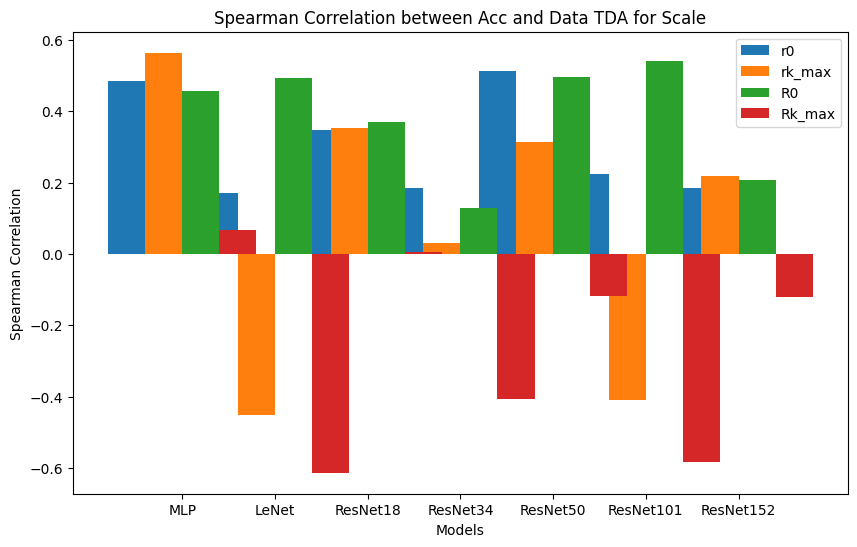

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_grouped_bar_chart_from_df(data_df, aug_names=None, label=['Data TDA v.s. Acc','Model output v.s. Acc'], title_key='TDA', aug_type='Scale', save_path='./neighbourhood/CIFAR10/Save_pdf'):
    """
    Plot a grouped bar chart from a DataFrame.

    Parameters:
    - data_df (pd.DataFrame): Input DataFrame.
    - aug_names (list): List of augmentation names (using DataFrame index).
    - label1 (str): Label for the first set of bars.
    - label2 (str): Label for the second set of bars.
    - title_key (str): Key for the chart title.
    - save_path (str): Path to save the plot as a PDF.
    
    Returns:
    - None
    """
    if aug_names is None:
        aug_names = data_df.index

    # Organize data for plotting
    columns = data_df.columns
    positions = np.arange(len(columns))
    bar_width = 0.4

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    for idx, aug_name in enumerate(aug_names):
        row_data = data_df.loc[aug_name].values
        ax.bar(positions + bar_width * idx, row_data, bar_width, label=f'{label[idx]}')

    # Set labels and title
    ax.set_xlabel('Models')
    ax.set_ylabel('Spearman Correlation')
    titlepdf = f'Spearman Correlation between Acc and {title_key} for {aug_type}'
    ax.set_title(titlepdf)
    ax.set_xticks(positions + bar_width * (len(aug_names) - 1) / 2)
    ax.set_xticklabels(columns)
    
    # Set legend and set its alpha
    legend = ax.legend()
    legend.set_alpha(0.5)


    if save_path:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        plt.savefig(os.path.join(save_path, f"{titlepdf}.pdf"), format='pdf')
    else:
        plt.show()



# 使用示例
data_df = pd.DataFrame({
    'MLP': [0.485294, 0.563636, 0.455882, 0.066667],
    'LeNet': [0.172136, -0.451684, 0.493492, -0.612647],
    'ResNet18': [0.347826, 0.352941, 0.368577, 0.005882],
    'ResNet34': [0.183936, 0.030303, 0.129982, -0.406061],
    'ResNet50': [0.513168, 0.312776, 0.495109, -0.118943],
    'ResNet101': [0.223078, -0.409744, 0.540189, -0.583276],
    'ResNet152': [0.183840, 0.217807, 0.207561, -0.120677]
})
index_list = ['r0', 'rk_max','R0','Rk_max']
# 给 DataFrame 添加行索引
data_df.index = index_list
print(data_df)
plot_grouped_bar_chart_from_df(data_df, save_path='./neighbourhood/CIFAR10/Save_pdf', title_key='Data TDA', label=index_list)


## 考察BOF的情况

### Scale

Dictionary saving the correlation:
              MLP     LeNet  ResNet18  ResNet34  ResNet50  ResNet101  ResNet152
r0      0.720280 -0.224010  0.517647  0.237762  0.504473  -0.139596   0.420898
rk_max  0.828571 -0.465909  0.381818  0.028571  0.393309  -0.433660   0.164010


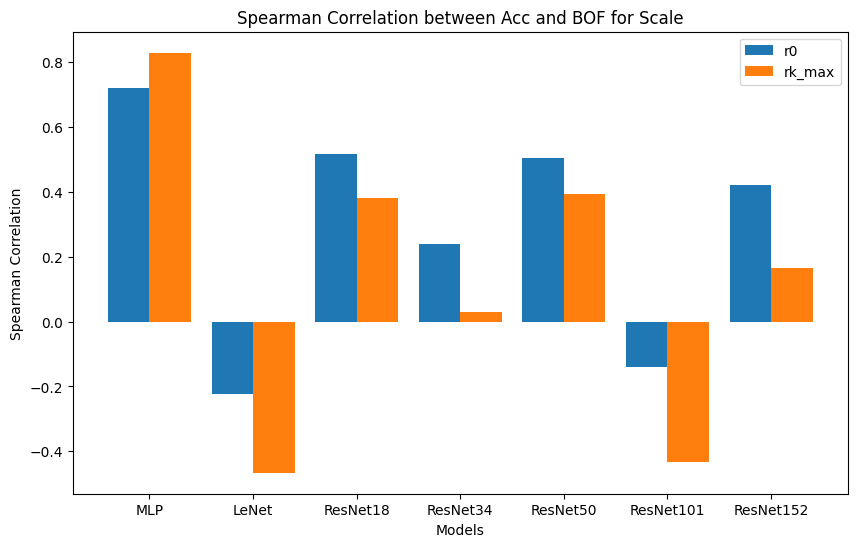

In [ ]:
control_file_path = './neighbourhood/CIFAR10/Scale_output.xlsx'
acc_file_path = './input_data/best_val_acc_kaiming.xlsx'
file_path = './input_data/BOF_data.xlsx'
focus_models = ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']
focus_features = ['r0', 'rk_max']

BOF_Scale_result = get_correlation_dict(control_file_path, acc_file_path, file_path, focus_models, focus_features, sheet_name='Scale')
print('Dictionary saving the correlation:\n', BOF_Scale_result)
plot_grouped_bar_chart_from_df(BOF_Scale_result, label=focus_features, title_key='BOF', aug_type='Scale')

### Angle

Dictionary saving the correlation:
              MLP  LeNet  ResNet18  ResNet34  ResNet50  ResNet101  ResNet152
r0     -0.222012   -1.0 -0.142901 -0.328424 -0.345553  -0.428571   0.283010
rk_max -0.243590    1.0 -0.363864 -0.269535 -0.362376   1.000000   0.179691


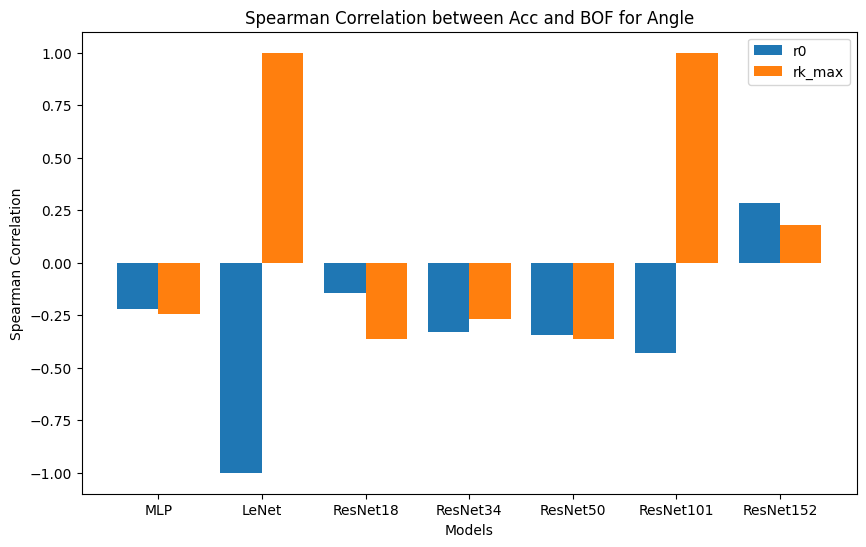

In [ ]:
control_file_path = './neighbourhood/CIFAR10/Angle_output.xlsx'
acc_file_path = './input_data/best_val_acc_kaiming.xlsx'
file_path = './input_data/BOF_data.xlsx'
focus_models = ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']
focus_features = ['r0', 'rk_max']

BOF_Angle_result = get_correlation_dict(control_file_path, acc_file_path, file_path, focus_models, focus_features, sheet_name='Angle')
print('Dictionary saving the correlation:\n', BOF_Angle_result)
plot_grouped_bar_chart_from_df(BOF_Angle_result, label=focus_features, title_key='BOF', aug_type='Angle')

## TDA

### Scale

                MLP     LeNet  ResNet18  ResNet34  ResNet50  ResNet101  \
Data       0.573427  0.051327  0.567647  0.244755  0.588552   0.172646   
Model_TDA -0.761905 -0.207612  0.072727 -0.100000  0.035778   0.116623   

           ResNet152  
Data        0.568065  
Model_TDA   0.496584  


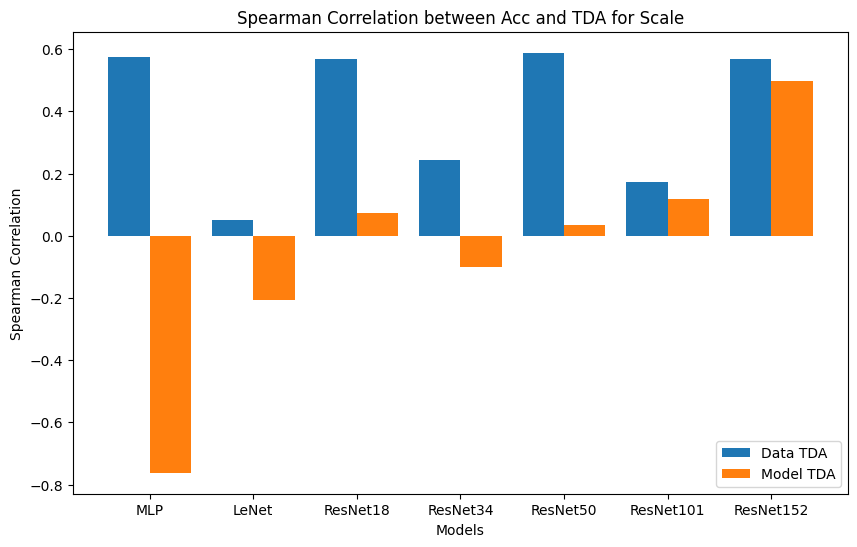

In [ ]:
control_file_path = './neighbourhood/CIFAR10/Scale_output.xlsx'
acc_file_path = './input_data/best_val_acc_kaiming.xlsx'
data_file_path = './input_data/TDA_data.xlsx'
focus_models = ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']
data_focus_features = ['Data']

TDA_Scale_result = get_correlation_dict(control_file_path, acc_file_path, data_file_path, focus_models, data_focus_features, sheet_name='Scale')
# print('Dictionary saving the correlation:\n', TDA_Scale_result)
# plot_grouped_bar_chart_from_df(TDA_Scale_result, label1='Data TDA v.s. Acc', title_key='Data TDA', aug_type='Scale')


model_file_path = './input_data/TDA_out_2_all_bars_surviver_time.xlsx'

model_focus_features =  ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']

TDA_model_Scale_result = get_correlation_dict(control_file_path, acc_file_path, model_file_path, focus_models, model_focus_features, sheet_name='Scale')
# print('Dictionary saving the correlation:\n', TDA_model_Scale_result)
# plot_grouped_bar_chart_from_df(TDA_model_Scale_result, label1='Model TDA v.s. Acc', title_key='Model TDA', aug_type='Scale')

# 使用 pd.concat() 进行拼接，axis=0 表示沿着行的方向拼接
result_df = pd.concat([TDA_Scale_result, TDA_model_Scale_result], axis=0)
print(result_df)
plot_grouped_bar_chart_from_df(result_df, label=['Data TDA', 'Model TDA'],title_key='TDA', aug_type='Scale')

### Angle

                MLP     LeNet  ResNet18  ResNet34  ResNet50  ResNet101  \
Data       0.178912  0.447664  0.405656  0.191834  0.269420   0.252553   
Model_TDA  0.152337  0.656010  0.382324  0.216300  0.291131   0.225809   

           ResNet152  
Data        0.035884  
Model_TDA  -0.089421  


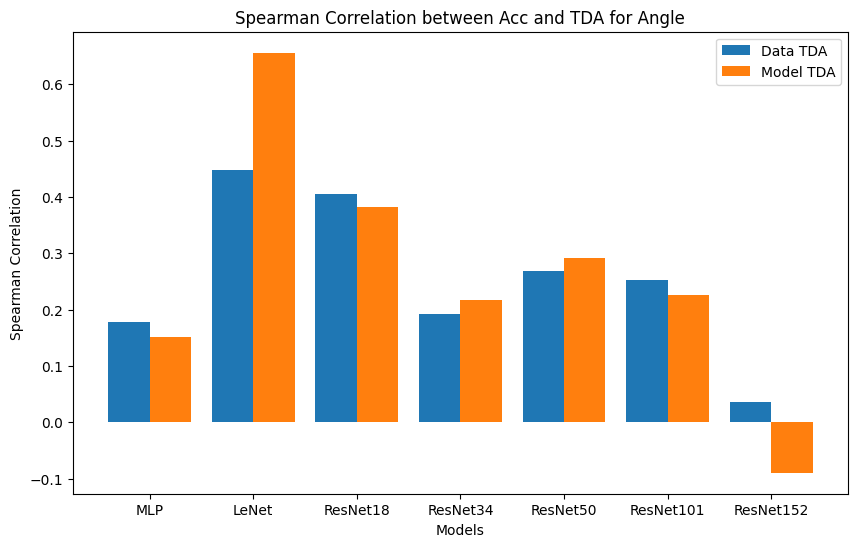

In [ ]:
control_file_path = './neighbourhood/CIFAR10/Scale_output.xlsx'
acc_file_path = './input_data/best_val_acc_kaiming.xlsx'
data_file_path = './input_data/TDA_data.xlsx'
focus_models = ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']
data_focus_features = ['Data']

TDA_Scale_result = get_correlation_dict(control_file_path, acc_file_path, data_file_path, focus_models, data_focus_features, sheet_name='Angle')
# print('Dictionary saving the correlation:\n', TDA_Scale_result)
# plot_grouped_bar_chart_from_df(TDA_Scale_result, label1='Data TDA v.s. Acc', title_key='Data TDA', aug_type='Scale')


model_file_path = './input_data/TDA_out_2_all_bars_surviver_time.xlsx'

model_focus_features =  ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']

TDA_model_Scale_result = get_correlation_dict(control_file_path, acc_file_path, model_file_path, focus_models, model_focus_features, sheet_name='Angle')
# print('Dictionary saving the correlation:\n', TDA_model_Scale_result)
# plot_grouped_bar_chart_from_df(TDA_model_Scale_result, label1='Model TDA v.s. Acc', title_key='Model TDA', aug_type='Scale')

# 使用 pd.concat() 进行拼接，axis=0 表示沿着行的方向拼接
result_df = pd.concat([TDA_Scale_result, TDA_model_Scale_result], axis=0)
print(result_df)
plot_grouped_bar_chart_from_df(result_df, label=['Data TDA', 'Model TDA'],title_key='TDA', aug_type='Angle')

# 考察区间信息

## 定义函数

### 加载数据

In [42]:
import pandas as pd
import numpy as np

def load_excel_sheet(file_path, sheet_name):
    """
    Load a specified sheet from an Excel file into a DataFrame.

    Parameters:
    - file_path (str): Path to the Excel file.
    - sheet_name (str): Name of the sheet to load.

    Returns:
    - pd.DataFrame: Loaded DataFrame.
    """
    try:
        # 读取指定的sheet为DataFrame
        df = pd.read_excel(file_path, sheet_name, index_col=0)
        
        # 创建新的 DataFrame 用于存储数据转化后的元素
        converted_df = pd.DataFrame(index=df.index, columns=df.columns)
        
        # 迭代处理每个元素
        for col in df.columns:
            for index, value in df[col].items():
                # print(f"Element at row {index}, column {col} has data type: {type(value)}")
                
                # 去除括号并按空格分割字符串
                values = str(value).strip('[]').split()

                # 将字符串列表转化为浮点数
                try:
                    converted_value = np.array([float(val) for val in values])
                    converted_df.at[index, col] = converted_value
                    # print(f"Converted value: {converted_value}")
                    # print(f"Data type after conversion: {converted_value.dtype}")
                except ValueError:
                    print(f"Conversion to float failed for value: {value}")
        
        return converted_df
    except Exception as e:
        print(f"Error loading sheet '{sheet_name}' from Excel file '{file_path}': {e}")
        return None

# 例子
excel_file_path = './neighbourhood/CIFAR10/Scale_output_new.xlsx'
sheet_to_load = "Sheet1"  # 你需要加载的 sheet 名称
scale_loaded_df = load_excel_sheet(excel_file_path, sheet_to_load)

# 打印加载的 DataFrame
if scale_loaded_df is not None:
    print(scale_loaded_df)
    print(scale_loaded_df['LeNet']['r0'], type(scale_loaded_df['LeNet']['r0']))


                         LeNet               MLP          ResNet18  \
r0            [0.0435, 0.2826]  [0.0435, 0.1739]  [0.0435, 0.2609]   
R0             [0.413, 0.2826]   [0.413, 0.1739]   [0.413, 0.2609]   
rk_max_index  [0.0652, 0.2826]  [0.0652, 0.1739]  [0.0652, 0.2609]   
rk_max        [0.1087, 0.2826]  [0.1087, 0.1739]  [0.1087, 0.2609]   
Rk_max        [0.1087, 0.2826]  [0.1087, 0.1739]  [0.1087, 0.2609]   
Data          [0.0435, 0.2826]  [0.0435, 0.1739]  [0.0435, 0.2609]   
Model_TDA     [0.0652, 0.2826]   [0.087, 0.1739]  [0.1087, 0.2609]   

                      ResNet34          ResNet50         ResNet101  \
r0            [0.0435, 0.2609]  [0.0435, 0.1957]  [0.0435, 0.3913]   
R0             [0.413, 0.2609]   [0.413, 0.1957]   [0.413, 0.3913]   
rk_max_index  [0.0652, 0.2609]  [0.0652, 0.1957]  [0.0652, 0.3913]   
rk_max        [0.1087, 0.2609]  [0.1087, 0.1957]  [0.1087, 0.3913]   
Rk_max        [0.1087, 0.2609]  [0.1087, 0.1957]  [0.1087, 0.3913]   
Data          [0.04

### 数据转化

In [43]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

def convert_df_to_differences(input_df):
    """
    Convert a DataFrame with numpy vectors to differences between vector elements.

    Parameters:
    - input_df (pd.DataFrame): DataFrame with numpy vectors as elements.

    Returns:
    - pd.DataFrame: DataFrame with absolute differences between vector elements as elements.
    """
    # 使用 applymap 对每个元素应用函数
    output_df = input_df.applymap(lambda x: np.abs(np.diff(x))[0] if isinstance(x, np.ndarray) and len(x) > 1 else x)
    return output_df


# 示例

# 使用函数进行转换
scale_converted_df = convert_df_to_differences(scale_loaded_df)

# 打印原始 DataFrame 和转换后的 DataFrame
print("Original DataFrame:")
print(scale_loaded_df)

print("\nDataFrame after conversion:")
print(scale_converted_df)


Original DataFrame:
                         LeNet               MLP          ResNet18  \
r0            [0.0435, 0.2826]  [0.0435, 0.1739]  [0.0435, 0.2609]   
R0             [0.413, 0.2826]   [0.413, 0.1739]   [0.413, 0.2609]   
rk_max_index  [0.0652, 0.2826]  [0.0652, 0.1739]  [0.0652, 0.2609]   
rk_max        [0.1087, 0.2826]  [0.1087, 0.1739]  [0.1087, 0.2609]   
Rk_max        [0.1087, 0.2826]  [0.1087, 0.1739]  [0.1087, 0.2609]   
Data          [0.0435, 0.2826]  [0.0435, 0.1739]  [0.0435, 0.2609]   
Model_TDA     [0.0652, 0.2826]   [0.087, 0.1739]  [0.1087, 0.2609]   

                      ResNet34          ResNet50         ResNet101  \
r0            [0.0435, 0.2609]  [0.0435, 0.1957]  [0.0435, 0.3913]   
R0             [0.413, 0.2609]   [0.413, 0.1957]   [0.413, 0.3913]   
rk_max_index  [0.0652, 0.2609]  [0.0652, 0.1957]  [0.0652, 0.3913]   
rk_max        [0.1087, 0.2609]  [0.1087, 0.1957]  [0.1087, 0.3913]   
Rk_max        [0.1087, 0.2609]  [0.1087, 0.1957]  [0.1087, 0.3913]   

### 绘制对应的图像

In [44]:
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

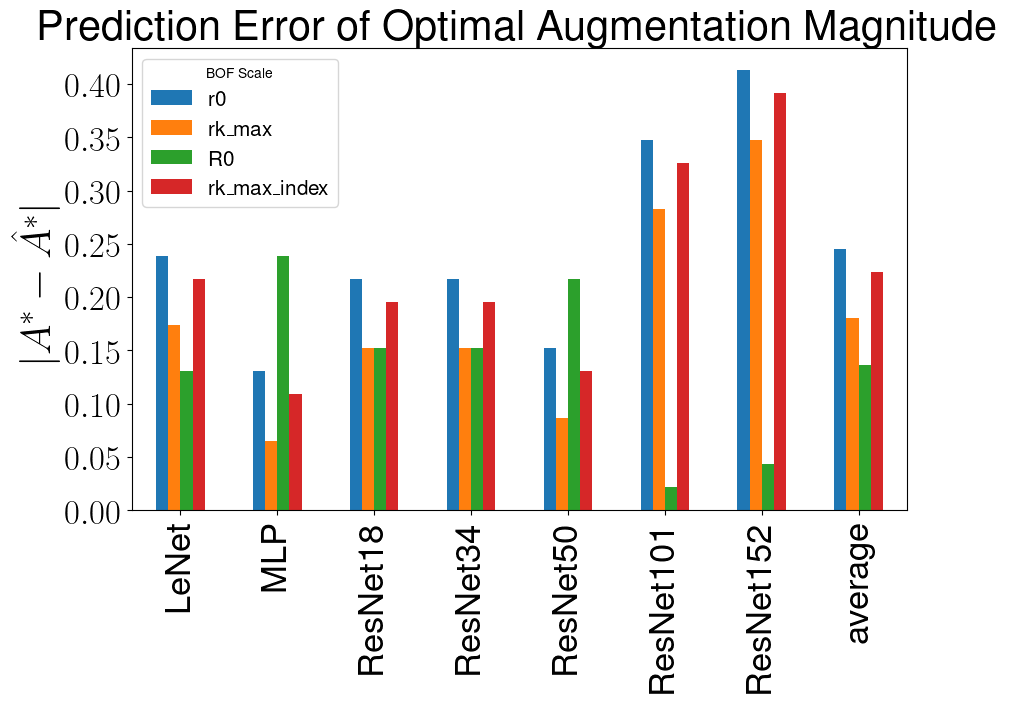

In [49]:
def plot_bar_chart(df, features_of_interest, title, xlabel, ylabel, save_folder, save_filename, my_legend='BOF Scale'):
    """
    Plot bar charts for selected features in the DataFrame and save as a PDF.

    Parameters:
    - df (pd.DataFrame): DataFrame with samples as columns and features as rows.
    - features_of_interest (list): List of features to be plotted.
    - title (str): Title for the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - save_folder (str): Folder path where the PDF will be saved.
    - save_filename (str): Filename for the saved PDF.

    Returns:
    - None
    """
    # 提取关心的特征列
    selected_df = df.loc[features_of_interest]
    
    # 转置以便每个样本为一行
    transposed_df = selected_df.T
    
    # 绘制柱状图
    ax = transposed_df.plot(kind='bar', figsize=(10, 6), fontsize=25)
    
    # 设置标题和标签
    ax.set_title(title, fontsize=30)
    ax.set_xlabel(xlabel, fontsize=30)
    ax.set_ylabel(ylabel, fontsize=30)
    
    # 设置图例
    legend = ax.legend(title=f'{my_legend}', fontsize=15)
    
    # 调整图例的透明度
    legend.get_frame().set_alpha(0.8)

    # 保存为 PDF 文件
    save_path = os.path.join(save_folder, save_filename)
    plt.savefig(save_path, format='pdf', bbox_inches='tight')

    # 显示图形
    plt.show()
# 示例
# 假设 df 是一个包含样本和特征的 DataFrame
# data = {'Sample1': [1, 2, 3, 4],
#         'Sample2': [5, 6, 7, 8],
#         'Sample3': [9, 10, 11, 12]}
# features = ['Feature1', 'Feature2', 'Feature3', 'Feature4']
# df = pd.DataFrame(data, index=features)
df = scale_converted_df
# 计算每行前面列的平均值，并添加到 DataFrame 中
df['average'] = df.iloc[:, :-1].mean(axis=1)
# print(df)
# 指定关心的特征，以及图表的标题和标签
selected_features = ['r0', 'rk_max', 'R0', 'rk_max_index']
plot_title = 'Prediction Error of Optimal Augmentation Magnitude'
x_label = None
y_label = r'$|A^* - \hat{A^*}|$'

# 指定保存文件夹和文件名
save_folder_path = './neighbourhood/CIFAR10/interal_size'
save_filename = 'BOF_Scale_new.pdf'

# 如果文件夹不存在，则创建它
if not os.path.exists(save_folder_path):
    os.makedirs(save_folder_path)

# 调用绘图函数并保存为 PDF
plot_bar_chart(df, selected_features, plot_title, x_label, y_label, save_folder_path, save_filename)


## 批量处理

### BOF

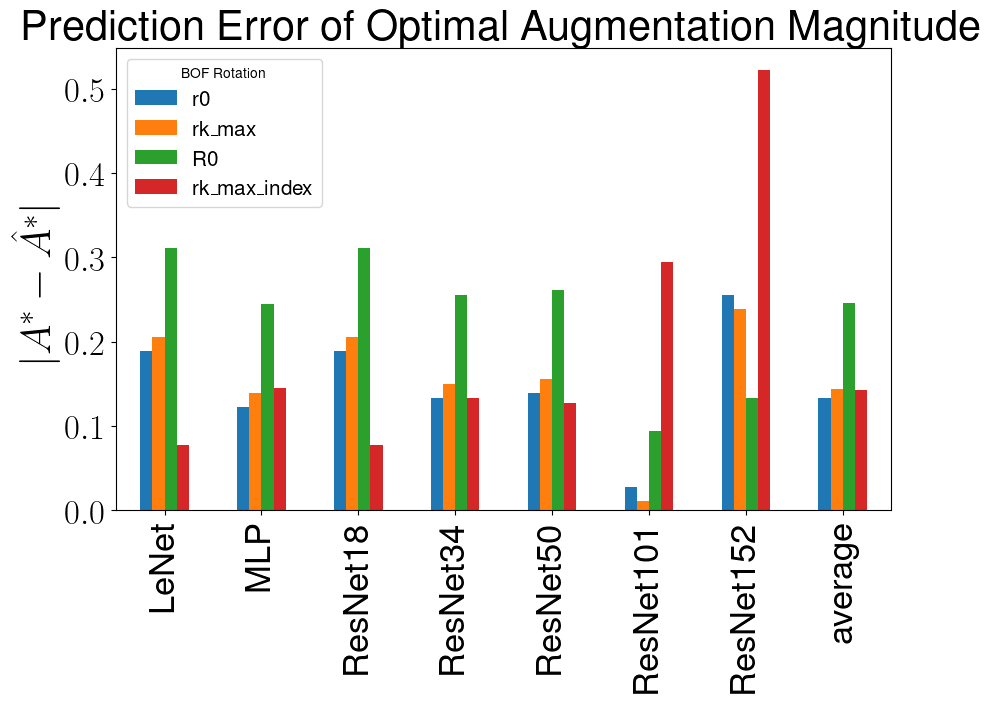

In [50]:
excel_file_path = './neighbourhood/CIFAR10/Angle_output_new.xlsx'
sheet_to_load = "Sheet1"  # 你需要加载的 sheet 名称
scale_loaded_df = load_excel_sheet(excel_file_path, sheet_to_load)
# 使用函数进行转换
scale_converted_df = convert_df_to_differences(scale_loaded_df)
df = scale_converted_df
# 计算每行前面列的平均值，并添加到 DataFrame 中
df['average'] = df.iloc[:, :-1].mean(axis=1)
# 指定关心的特征，以及图表的标题和标签
selected_features = ['r0', 'rk_max', 'R0', 'rk_max_index']
plot_title = 'Prediction Error of Optimal Augmentation Magnitude'
x_label = None
y_label = r'$|A^* - \hat{A^*}|$'

# 指定保存文件夹和文件名
save_folder_path = './neighbourhood/CIFAR10/interal_size'
save_filename = 'BOF_Angle_new.pdf'

# 如果文件夹不存在，则创建它
if not os.path.exists(save_folder_path):
    os.makedirs(save_folder_path)

# 调用绘图函数并保存为 PDF
plot_bar_chart(df, selected_features, plot_title, x_label, y_label, save_folder_path, save_filename, my_legend='BOF Rotation')

### TDA

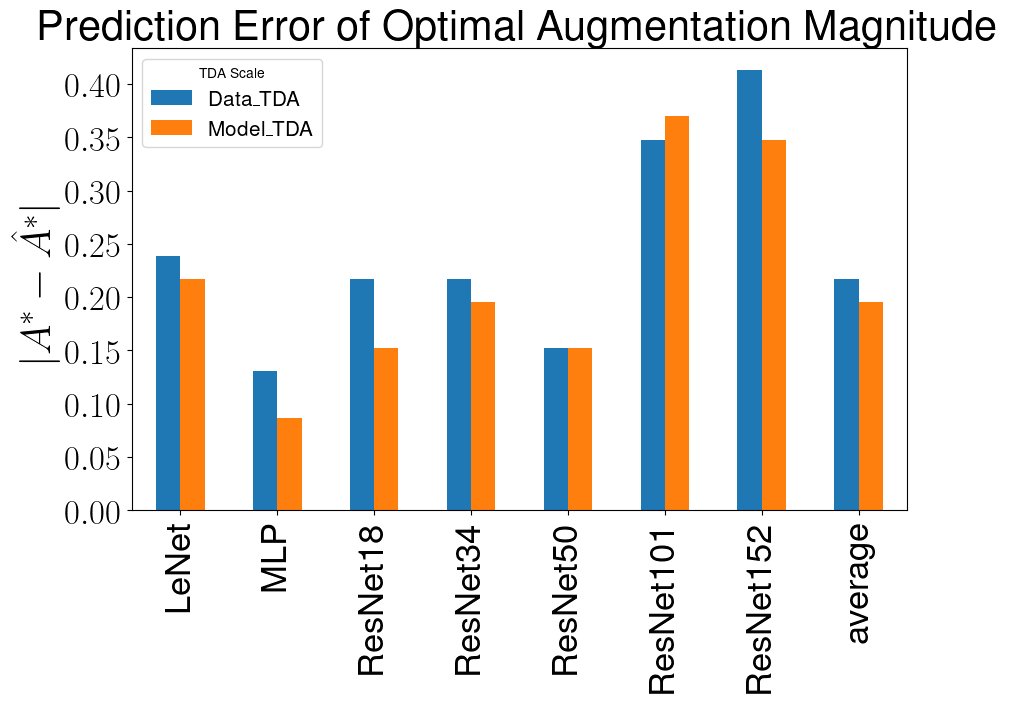

In [54]:
excel_file_path = './neighbourhood/CIFAR10/Scale_output_new.xlsx'
sheet_to_load = "Sheet1"  # 你需要加载的 sheet 名称
scale_loaded_df = load_excel_sheet(excel_file_path, sheet_to_load)
# 使用函数进行转换
scale_converted_df = convert_df_to_differences(scale_loaded_df)
df = scale_converted_df
# 计算每行前面列的平均值，并添加到 DataFrame 中
df['average'] = df.iloc[:, :-1].mean(axis=1)
# 指定关心的特征，以及图表的标题和标签
selected_features = ['Data_TDA', 'Model_TDA']
plot_title = 'Prediction Error of Optimal Augmentation Magnitude'
x_label = None
y_label = r'$|A^* - \hat{A^*}|$'

# 指定保存文件夹和文件名
save_folder_path = './neighbourhood/CIFAR10/interal_size'
save_filename = 'TDA_Scale_new.pdf'

# 如果文件夹不存在，则创建它
if not os.path.exists(save_folder_path):
    os.makedirs(save_folder_path)

# 调用绘图函数并保存为 PDF
plot_bar_chart(df, selected_features, plot_title, x_label, y_label, save_folder_path, save_filename, my_legend='TDA Scale')

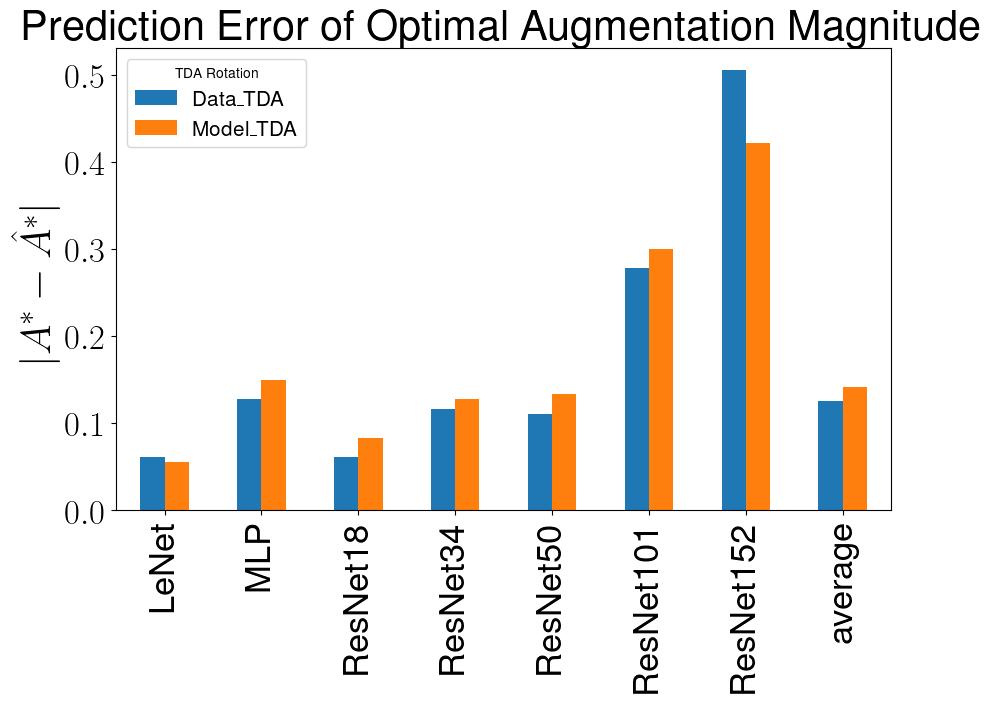

In [53]:
excel_file_path = './neighbourhood/CIFAR10/Angle_output_new.xlsx'
sheet_to_load = "Sheet1"  # 你需要加载的 sheet 名称
scale_loaded_df = load_excel_sheet(excel_file_path, sheet_to_load)
# 使用函数进行转换
scale_converted_df = convert_df_to_differences(scale_loaded_df)
df = scale_converted_df
# 计算每行前面列的平均值，并添加到 DataFrame 中
df['average'] = df.iloc[:, :-1].mean(axis=1)
# 指定关心的特征，以及图表的标题和标签
selected_features = ['Data_TDA', 'Model_TDA']
plot_title = 'Prediction Error of Optimal Augmentation Magnitude'
x_label = None
y_label = r'$|A^* - \hat{A^*}|$'

# 指定保存文件夹和文件名
save_folder_path = './neighbourhood/CIFAR10/interal_size'
save_filename = 'TDA_Angle_new.pdf'

# 如果文件夹不存在，则创建它
if not os.path.exists(save_folder_path):
    os.makedirs(save_folder_path)

# 调用绘图函数并保存为 PDF
plot_bar_chart(df, selected_features, plot_title, x_label, y_label, save_folder_path, save_filename, my_legend='TDA Rotation')

# 考察医学数据集

## 定义函数

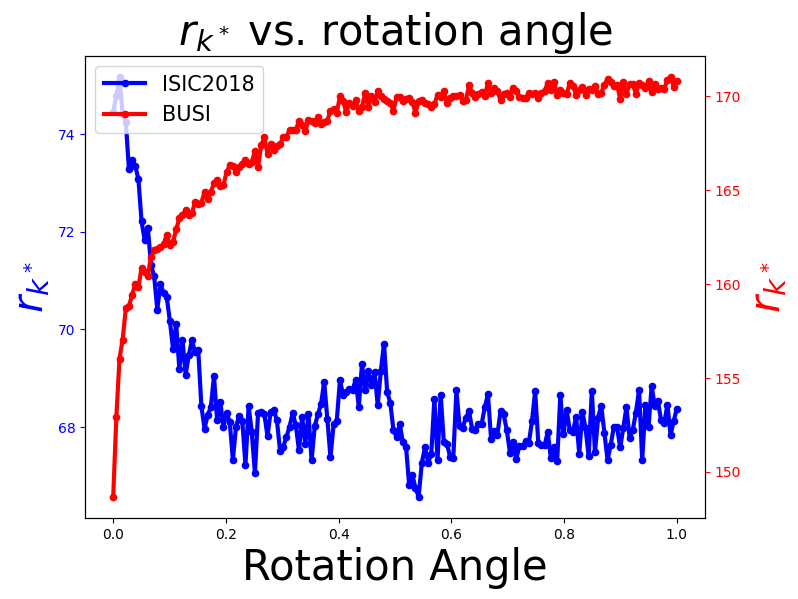

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def plot_excel_data(file_path1, file_path2, sheet_name, column_name1, column_name2, 
                    legend1, legend2, title, x_label, y_label, font_size=30, normalize_x=True,
                    line_width=3.0, marker_size=4.5, save_path='./draw_input/BOF_isic/'):
    """
    读取两个Excel文件中指定Sheet和列的数据，绘制在一张图上，并设置legend、title、x-label、y-label的属性。

    参数:
    - file_path1: 第一个Excel文件路径。
    - file_path2: 第二个Excel文件路径。
    - sheet_name: 指定的Sheet名称。
    - column_name1: 第一个列名称。
    - column_name2: 第二个列名称。
    - legend1: 第一个legend标签。
    - legend2: 第二个legend标签。
    - title: 图表标题。
    - x_label: x轴标签。
    - y_label: y轴标签。
    - font_size: 字体大小，默认为12。
    - normalize_x: 是否对横坐标进行归一化，默认为True。
    - line_width: 线宽度，默认为3.0。
    - marker_size: 点的大小，默认为4.5。
    - save_path: 图片保存路径，默认为'./draw_input/BOF_isic/'。
    """
    # 读取数据
    data1 = pd.read_excel(file_path1, sheet_name=sheet_name)[[column_name1]]
    data2 = pd.read_excel(file_path2, sheet_name=sheet_name)[[column_name2]]

    # 绘图
    fig, ax1 = plt.subplots(figsize=(8, 6))

    if normalize_x:
        max_len1, max_len2 = len(data1), len(data2)
        normalized_x1, normalized_x2 = np.linspace(0, 1, max_len1), np.linspace(0, 1, max_len2)
        ax1.plot(normalized_x1, data1, label=legend1, linewidth=line_width, markersize=marker_size, marker='o', color='b')
    else:
        ax1.plot(data1, label=legend1, linewidth=line_width, markersize=marker_size, marker='o', color='b')

    # 设置第一个y轴的属性
    ax1.set_xlabel(x_label, fontsize=font_size)
    ax1.set_ylabel(y_label, color='b', fontsize=font_size)
    ax1.tick_params('y', colors='b')

    # 创建第二个y轴
    ax2 = ax1.twinx()

    if normalize_x:
        ax2.plot(normalized_x2, data2, label=legend2, linewidth=line_width, markersize=marker_size, marker='o', color='r')
    else:
        ax2.plot(data2, label=legend2, linewidth=line_width, markersize=marker_size, marker='o', color='r')

    # 设置第二个y轴的属性
    ax2.set_ylabel(y_label, color='r', fontsize=font_size)
    ax2.tick_params('y', colors='r')

    # 设置legend和title的属性
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best', fontsize=15)
    plt.title(title, fontsize=font_size)

    # 保存图表
    save_pdf = save_path + sheet_name + column_name1 + '_' + column_name2 + '.pdf'
    plt.savefig(save_pdf)

    # 显示图表
    plt.show()


# 示例用法
isic_path = './input_data_medtical/BOF_med_isic.xlsx'
busi_path = './input_data_medtical/BOF_med_busi.xlsx'
sheet_care = 'Angle'
column_care = 'rk_max'
legend1 = 'ISIC2018'
legend2 = 'BUSI'
my_title = r'$r_{k^*}$' + ' vs.' + ' rotation angle'
x_label = 'Rotation Angle'
y_label = r'$r_{k^*}$'
# plot_excel_data(isic_path, busi_path, sheet_care, column_care,column_care,
#                 legend1, legend2, my_title, x_label, y_label, font_size=14)

# 示例用法，对横坐标进行归一化
plot_excel_data(isic_path, busi_path, sheet_care, column_care,column_care,
                legend1, legend2, my_title, x_label, y_label, font_size=30, normalize_x=True)

# 示例用法，不对横坐标进行归一化
# plot_excel_data(isic_path, busi_path, sheet_care, column_care,column_care,
#                 legend1, legend2, my_title, x_label, y_label,font_size=14, normalize_x=False)


## BOF

### ISIC

In [ ]:
# 调用函数
ISIC_BOF_data_file_path = "./input_data_medtical/BOF_med_isic.xlsx"
ISIC_BOF_data_save_dic = process_extreme_value(ISIC_BOF_data_file_path, 'local_min')
print(ISIC_BOF_data_save_dic)

         r0         R0  rk_max_index     rk_max      Rk_max
0  3.893085  13.375069     64.599998  72.245071  129.333832
1  0.062500   0.156200      0.046900   0.046900    0.015600
         r0        R0  rk_max_index     rk_max      Rk_max
0  2.527714  5.225862     83.099998  73.271866  130.194214
1  0.122200  0.127800      0.016700   0.027800    0.005600
{'Scale': {'r0': [0.0625], 'R0': [0.1562], 'rk_max_index': [0.0469], 'rk_max': [0.0469], 'Rk_max': [0.0156]}, 'Angle': {'r0': [0.1222], 'R0': [0.1278], 'rk_max_index': [0.0167], 'rk_max': [0.0278], 'Rk_max': [0.0056]}}


### BUSI

In [ ]:
# 调用函数
BUSI_BOF_data_file_path = "./input_data_medtical/BOF_med_busi.xlsx"
BUSI_BOF_data_save_dic = process_extreme_value(BUSI_BOF_data_file_path, 'local_min')
print(BUSI_BOF_data_save_dic)

         r0         R0  rk_max_index rk_max      Rk_max
0  4.779502  14.596182    156.800003   None  272.467194
1  0.843800   0.812500      0.093800   None    0.062500
         r0        R0  rk_max_index      rk_max      Rk_max
0  2.614736  6.305239    160.600006  159.848862  276.665955
1  0.127800  0.122200      0.022200    0.044400    0.027800
{'Scale': {'r0': [0.8438], 'R0': [0.8125], 'rk_max_index': [0.0938], 'rk_max': [None], 'Rk_max': [0.0625]}, 'Angle': {'r0': [0.1278], 'R0': [0.1222], 'rk_max_index': [0.0222], 'rk_max': [0.0444], 'Rk_max': [0.0278]}}


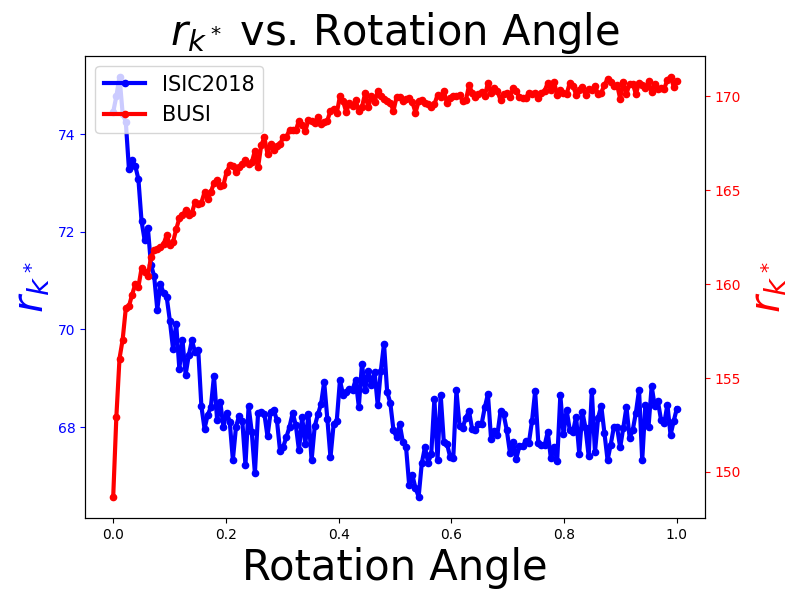

In [ ]:
# 示例用法
isic_path = './input_data_medtical/BOF_med_isic.xlsx'
busi_path = './input_data_medtical/BOF_med_busi.xlsx'
sheet_care = 'Angle'
column_care = 'rk_max'
legend1 = 'ISIC2018'
legend2 = 'BUSI'
my_title = r'$r_{k^*}$' + ' vs.' + ' Rotation Angle'
x_label = 'Rotation Angle'
y_label = r'$r_{k^*}$'
# plot_excel_data(isic_path, busi_path, sheet_care, column_care,column_care,
#                 legend1, legend2, my_title, x_label, y_label, font_size=14)

# 示例用法，对横坐标进行归一化
plot_excel_data(isic_path, busi_path, sheet_care, column_care,column_care,
                legend1, legend2, my_title, x_label, y_label, font_size=30, normalize_x=True, save_path='./draw_input/BOF_med/')

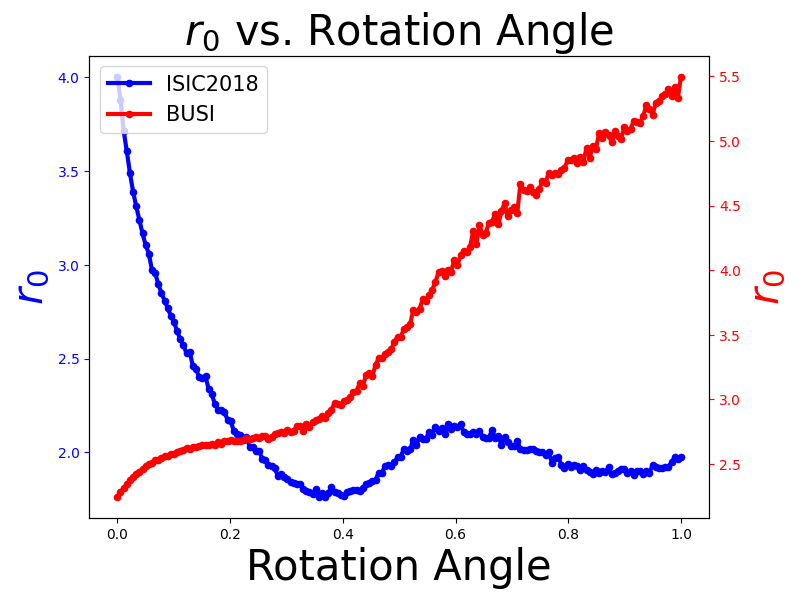

In [ ]:
# 示例用法
isic_path = './input_data_medtical/BOF_med_isic.xlsx'
busi_path = './input_data_medtical/BOF_med_busi.xlsx'
sheet_care = 'Angle'
column_care = 'r0'
legend1 = 'ISIC2018'
legend2 = 'BUSI'
my_title = r'$r_0$' + ' vs.' + ' Rotation Angle'
x_label = 'Rotation Angle'
y_label = r'$r_0$'
# plot_excel_data(isic_path, busi_path, sheet_care, column_care,column_care,
#                 legend1, legend2, my_title, x_label, y_label, font_size=14)

# 示例用法，对横坐标进行归一化
plot_excel_data(isic_path, busi_path, sheet_care, column_care,column_care,
                legend1, legend2, my_title, x_label, y_label, font_size=30, normalize_x=True, save_path='./draw_input/BOF_med/')

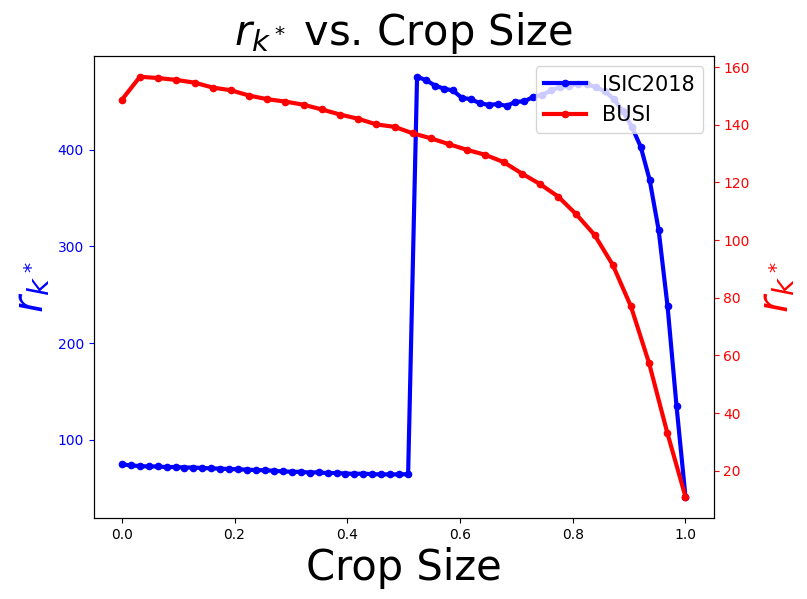

In [ ]:
# 示例用法
isic_path = './input_data_medtical/BOF_med_isic.xlsx'
busi_path = './input_data_medtical/BOF_med_busi.xlsx'
sheet_care = 'Scale'
column_care = 'rk_max'
legend1 = 'ISIC2018'
legend2 = 'BUSI'
my_title = r'$r_{k^*}$' + ' vs.' + ' Crop Size'
x_label = 'Crop Size'
y_label = r'$r_{k^*}$'
# plot_excel_data(isic_path, busi_path, sheet_care, column_care,column_care,
#                 legend1, legend2, my_title, x_label, y_label, font_size=14)

# 示例用法，对横坐标进行归一化
plot_excel_data(isic_path, busi_path, sheet_care, column_care,column_care,
                legend1, legend2, my_title, x_label, y_label, font_size=30, normalize_x=True, save_path='./draw_input/BOF_med/')

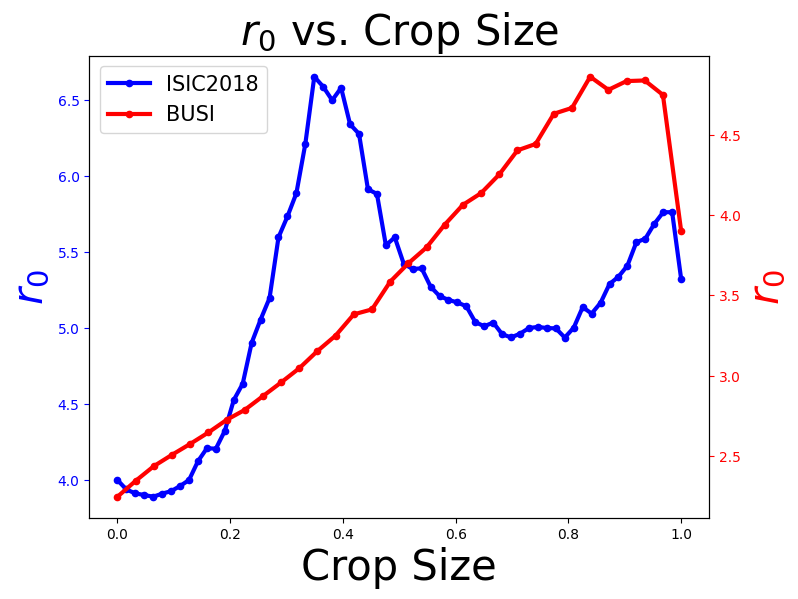

In [ ]:
# 示例用法
isic_path = './input_data_medtical/BOF_med_isic.xlsx'
busi_path = './input_data_medtical/BOF_med_busi.xlsx'
sheet_care = 'Scale'
column_care = 'r0'
legend1 = 'ISIC2018'
legend2 = 'BUSI'
my_title = r'$r_0$' + ' vs.' + ' Crop Size'
x_label = 'Crop Size'
y_label = r'$r_0$'
# plot_excel_data(isic_path, busi_path, sheet_care, column_care,column_care,
#                 legend1, legend2, my_title, x_label, y_label, font_size=14)

# 示例用法，对横坐标进行归一化
plot_excel_data(isic_path, busi_path, sheet_care, column_care,column_care,
                legend1, legend2, my_title, x_label, y_label, font_size=30, normalize_x=True, save_path='./draw_input/BOF_med/')

## TDA

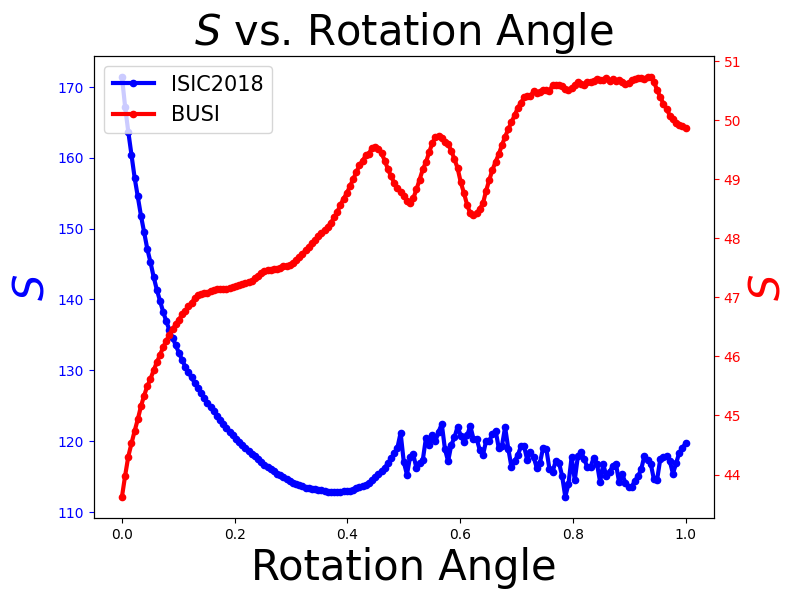

In [ ]:
### INPUT

# 示例用法
isic_path = './input_data_medtical/TDA_input_isic.xlsx'
busi_path = './input_data_medtical/TDA_input_busi.xlsx'
sheet_care = 'Angle'
column_care = 'Data'
legend1 = 'ISIC2018'
legend2 = 'BUSI'
my_title = r'$S$' + ' vs.' + ' Rotation Angle'
x_label = 'Rotation Angle'
y_label = r'$S$'
# plot_excel_data(isic_path, busi_path, sheet_care, column_care,column_care,
#                 legend1, legend2, my_title, x_label, y_label, font_size=14)

# 示例用法，对横坐标进行归一化
plot_excel_data(isic_path, busi_path, sheet_care, column_care,column_care,
                legend1, legend2, my_title, x_label, y_label, font_size=30, normalize_x=True, save_path='./draw_input/TDA_input_med/')

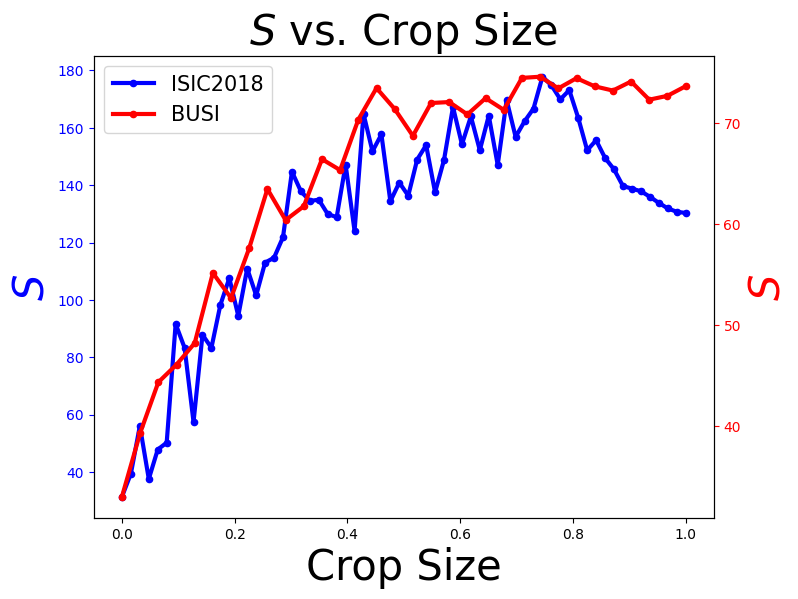

In [ ]:
### INPUT

# 示例用法
isic_path = './input_data_medtical/TDA_input_isic.xlsx'
busi_path = './input_data_medtical/TDA_input_busi.xlsx'
sheet_care = 'Scale'
column_care = 'Data'
legend1 = 'ISIC2018'
legend2 = 'BUSI'
my_title = r'$S$' + ' vs.' + ' Crop Size'
x_label = 'Crop Size'
y_label = r'$S$'
# plot_excel_data(isic_path, busi_path, sheet_care, column_care,column_care,
#                 legend1, legend2, my_title, x_label, y_label, font_size=14)

# 示例用法，对横坐标进行归一化
plot_excel_data(isic_path, busi_path, sheet_care, column_care,column_care,
                legend1, legend2, my_title, x_label, y_label, font_size=30, normalize_x=True,save_path='./draw_input/TDA_input_med/')

In [ ]:
range(8, 512, 8)[int(len(range(8, 512, 8))*0.75)]

384